In [1]:
import numpy as np
import cv2
import scipy.io
import os
from numpy.linalg import norm
from matplotlib import pyplot as plt
from numpy.linalg import det
from numpy.linalg import inv
from scipy.linalg import rq
from numpy.linalg import svd
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import sys
from scipy import ndimage, spatial
from tqdm.notebook import tqdm, trange

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from skimage import io, transform,data
from torchvision import transforms, utils
import numpy as np
import math
import glob
import matplotlib.pyplot as plt
import time
import os
import copy
import sklearn.svm
import cv2
from matplotlib import pyplot as plt
import numpy as np
from os.path import exists
import pandas as pd
import PIL
import random
from google.colab import drive
from sklearn.metrics.cluster import completeness_score
from sklearn.cluster import KMeans
from tqdm import tqdm, tqdm_notebook
from functools import partial
from torchsummary import summary
from torchvision.datasets import ImageFolder
from torch.utils.data.sampler import SubsetRandomSampler
import h5py as h5

#cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
#accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

#print("Accelerator type = ",accelerator)
#print("Pytorch verision: ", torch.__version__)

In [2]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!pip install ipython-autotime

#%load_ext autotime

In [4]:
!pip install opencv-python==3.4.2.17
!pip install opencv-contrib-python==3.4.2.17

In [5]:
class Image:
    def __init__(self, img, position):
        
        self.img = img
        self.position = position

inlier_matchset = []
def features_matching(a,keypointlength,threshold):
  #threshold=0.2
  bestmatch=np.empty((keypointlength),dtype= np.int16)
  img1index=np.empty((keypointlength),dtype=np.int16)
  distance=np.empty((keypointlength))
  index=0
  for j in range(0,keypointlength):
    #For a descriptor fa in Ia, take the two closest descriptors fb1 and fb2 in Ib
    x=a[j]
    listx=x.tolist()
    x.sort()
    minval1=x[0]                                # min 
    minval2=x[1]                                # 2nd min
    itemindex1 = listx.index(minval1)           #index of min val    
    itemindex2 = listx.index(minval2)           #index of second min value 
    ratio=minval1/minval2                       #Ratio Test
    
    if ratio<threshold: 
      #Low distance ratio: fb1 can be a good match
      bestmatch[index]=itemindex1
      distance[index]=minval1
      img1index[index]=j
      index=index+1
  return  [cv2.DMatch(img1index[i],bestmatch[i].astype(int),distance[i]) for i in range(0,index)]
          
   
  
def compute_Homography(im1_pts,im2_pts):
  """
  im1_pts and im2_pts are 2×n matrices with
  4 point correspondences from the two images
  """
  num_matches=len(im1_pts)
  num_rows = 2 * num_matches
  num_cols = 9
  A_matrix_shape = (num_rows,num_cols)
  A = np.zeros(A_matrix_shape)
  a_index = 0
  for i in range(0,num_matches):
    (a_x, a_y) = im1_pts[i]
    (b_x, b_y) = im2_pts[i]
    row1 = [a_x, a_y, 1, 0, 0, 0, -b_x*a_x, -b_x*a_y, -b_x] # First row 
    row2 = [0, 0, 0, a_x, a_y, 1, -b_y*a_x, -b_y*a_y, -b_y] # Second row 

    # place the rows in the matrix
    A[a_index] = row1
    A[a_index+1] = row2

    a_index += 2
    
  U, s, Vt = np.linalg.svd(A)

  #s is a 1-D array of singular values sorted in descending order
  #U, Vt are unitary matrices
  #Rows of Vt are the eigenvectors of A^TA.
  #Columns of U are the eigenvectors of AA^T.
  H = np.eye(3)
  H = Vt[-1].reshape(3,3) # take the last row of the Vt matrix
  return H
  
  
def displayplot(img,title):
  
  plt.figure(figsize=(15,15))
  plt.title(title)
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.show()

In [6]:
def get_inliers(f1, f2, matches, H, RANSACthresh):

  inlier_indices = []
  for i in range(len(matches)):
    queryInd = matches[i].queryIdx
    trainInd = matches[i].trainIdx

    #queryInd = matches[i][0]
    #trainInd = matches[i][1]

    queryPoint = np.array([f1[queryInd].pt[0],  f1[queryInd].pt[1], 1]).T 
    trans_query = H.dot(queryPoint) 

   
    comp1 = [trans_query[0]/trans_query[2], trans_query[1]/trans_query[2]] # normalize with respect to z
    comp2 = np.array(f2[trainInd].pt)[:2]
    

    if(np.linalg.norm(comp1-comp2) <= RANSACthresh): # check against threshold
      inlier_indices.append(i)
  return inlier_indices


def RANSAC_alg(f1, f2, matches, nRANSAC, RANSACthresh):

      
    minMatches = 4
    nBest = 0
    best_inliers = []
    H_estimate = np.eye(3,3)
    global inlier_matchset
    inlier_matchset=[]
    for iteration in range(nRANSAC):
      
        #Choose a minimal set of feature matches.
        matchSample = random.sample(matches, minMatches)
        
        #Estimate the Homography implied by these matches
        im1_pts=np.empty((minMatches,2))
        im2_pts=np.empty((minMatches,2))
        for i in range(0,minMatches):
          m = matchSample[i]
          im1_pts[i] = f1[m.queryIdx].pt
          im2_pts[i] = f2[m.trainIdx].pt
          #im1_pts[i] = f1[m[0]].pt
          #im2_pts[i] = f2[m[1]].pt             
          
        H_estimate=compute_Homography(im1_pts,im2_pts)
        
               
        # Calculate the inliers for the H
        inliers = get_inliers(f1, f2, matches, H_estimate, RANSACthresh)

        # if the number of inliers is higher than previous iterations, update the best estimates
        if len(inliers) > nBest:
            nBest= len(inliers)
            best_inliers = inliers

    print("Number of best inliers",len(best_inliers))
    for i in range(len(best_inliers)):
      inlier_matchset.append(matches[best_inliers[i]])
    
    # compute a homography given this set of matches
    im1_pts=np.empty((len(best_inliers),2))
    im2_pts=np.empty((len(best_inliers),2))
    for i in range(0,len(best_inliers)):
      m = inlier_matchset[i]
      im1_pts[i] = f1[m.queryIdx].pt
      im2_pts[i] = f2[m.trainIdx].pt
      #im1_pts[i] = f1[m[0]].pt
      #im2_pts[i] = f2[m[1]].pt

    M=compute_Homography(im1_pts,im2_pts)
    return M, best_inliers

In [7]:
tqdm = partial(tqdm, position=0, leave=True)

In [8]:
files_all=[]
for file in os.listdir("/content/drive/MyDrive/MAP-20210707T092105Z-001/MAP"):
    if file.endswith(".JPG"):
      files_all.append(file)


files_all.sort()
folder_path = '/content/drive/MyDrive/MAP-20210707T092105Z-001/MAP/'

#centre_file = folder_path + files_all[50]
left_files_path_rev = []
right_files_path = []


#Change this according to your dataset split

for file in files_all[:61]:
  left_files_path_rev.append(folder_path + file)

left_files_path = left_files_path_rev[::-1]

for file in files_all[60:120]:
  right_files_path.append(folder_path + file)

In [9]:
print(len(files_all))

176


In [10]:
from multiprocessing import Pool

In [11]:
import multiprocessing
print(multiprocessing.cpu_count())


2


In [12]:
gridsize = 8
clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(gridsize,gridsize))

images_left_bgr = []
images_right_bgr = []

images_left = []
images_right = []

for file in tqdm(left_files_path):
  left_image_sat= cv2.imread(file)
  lab = cv2.cvtColor(left_image_sat, cv2.COLOR_BGR2LAB)
  lab[...,0] = clahe.apply(lab[...,0])
  left_image_sat = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
  left_img = cv2.resize(left_image_sat,None,fx=0.5, fy=0.5, interpolation = cv2.INTER_CUBIC )
  images_left.append(cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY).astype('float32')/255.)
  images_left_bgr.append(left_img)


for file in tqdm(right_files_path):
  right_image_sat= cv2.imread(file)
  lab = cv2.cvtColor(right_image_sat, cv2.COLOR_BGR2LAB)
  lab[...,0] = clahe.apply(lab[...,0])
  right_image_sat = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
  right_img = cv2.resize(right_image_sat,None,fx=0.5,fy=0.5, interpolation = cv2.INTER_CUBIC )
  images_right.append(cv2.cvtColor(right_img, cv2.COLOR_BGR2GRAY).astype('float32')/255.)
  images_right_bgr.append(right_img)

100%|██████████| 60/60 [00:59<00:00,  1.00it/s]


In [13]:
Dataset = 'MAP Dataset'

In [14]:
f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','w')
t0=time.time()
f.create_dataset('data',data=images_left_bgr + images_right_bgr)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize(f'drive/MyDrive/all_images_bgr_{Dataset}.h5')/1.e6,'MB')

HDF5  w/o comp.: 16.42362380027771 [s] ... size 1811.54048 MB


In [ ]:
'''
f=h5.File(f'drive/MyDrive/all_images_gray_{Dataset}.h5','w')
t0=time.time()
f.create_dataset('data',data=images_left + images_right)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize(f'drive/MyDrive/all_images_gray_{Dataset}.h5')/1.e6,'MB')

In [15]:
del images_left_bgr,images_right_bgr

In [ ]:
#images_left_bgr_no_enhance = []
#images_right_bgr_no_enhance = []

#for file in tqdm(left_files_path):
#  left_image_sat= cv2.imread(file)
#  left_img = cv2.resize(left_image_sat,None,fx=0.35, fy=0.35, interpolation = cv2.INTER_CUBIC)
#  images_left_bgr_no_enhance.append(left_img)

#for file in tqdm(right_files_path):
# right_image_sat= cv2.imread(file)
#  right_img = cv2.resize(right_image_sat,None,fx=0.35,fy=0.35, interpolation = cv2.INTER_CUBIC)
#  images_right_bgr_no_enhance.append(right_img)

In [16]:
from timeit import default_timer as timer

In [17]:
time_all = []

In [18]:
num_kps_sift = []
num_kps_brisk = []
num_kps_agast = []
num_kps_kaze = []
num_kps_akaze = []
num_kps_orb = []
num_kps_mser = []
num_kps_daisy = []
num_kps_surfsift = []
num_kps_fast = []
num_kps_freak = []
num_kps_gftt = []
num_kps_star = []
num_kps_surf = []
num_kps_rootsift = []
num_kps_superpoint = []


In [19]:
images_left_bgr=[]
images_right_bgr=[]

BRISK

In [ ]:
'''
Threshl=60;
Octaves=6; 
#PatternScales=1.0f;

start = timer()

brisk = cv2.BRISK_create(Threshl,Octaves)


keypoints_all_left_brisk = []
descriptors_all_left_brisk = []
points_all_left_brisk=[]

keypoints_all_right_brisk = []
descriptors_all_right_brisk = []
points_all_right_brisk=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()  
  kpt = brisk.detect(imgs,None)
  kpt,descrip =  brisk.compute(imgs, kpt)
  keypoints_all_left_brisk.append(kpt)
  descriptors_all_left_brisk.append(descrip)
  #points_all_left_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = brisk.detect(imgs,None)
  kpt,descrip =  brisk.compute(imgs, kpt)
  keypoints_all_right_brisk.append(kpt)
  descriptors_all_right_brisk.append(descrip)
  #points_all_right_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [02:53<00:00,  2.89s/it]


In [ ]:
'''
for j in tqdm(keypoints_all_left_brisk + keypoints_all_right_brisk[1:]):
  num_kps_brisk.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 297117.17it/s]


In [ ]:
'''
all_feat_brisk_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_brisk):
  all_feat_brisk_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_brisk[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_brisk_left_each.append(temp)
  all_feat_brisk_left.append(all_feat_brisk_left_each)

In [ ]:
'''
all_feat_brisk_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_brisk):
  all_feat_brisk_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_brisk[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_brisk_right_each.append(temp)
  all_feat_brisk_right.append(all_feat_brisk_right_each)

In [ ]:
'''
del keypoints_all_left_brisk, keypoints_all_right_brisk, descriptors_all_left_brisk, descriptors_all_right_brisk

In [ ]:
'''
import pickle
Fdb = open('all_feat_brisk_left.dat', 'wb')
pickle.dump(all_feat_brisk_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_brisk_right.dat', 'wb')
pickle.dump(all_feat_brisk_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_brisk_left, all_feat_brisk_right

ORB

In [ ]:
'''
orb = cv2.ORB_create(20000)

start = timer()


keypoints_all_left_orb = []
descriptors_all_left_orb = []
points_all_left_orb=[]

keypoints_all_right_orb = []
descriptors_all_right_orb = []
points_all_right_orb=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()    
  kpt = orb.detect(imgs,None)
  kpt,descrip =  orb.compute(imgs, kpt)
  keypoints_all_left_orb.append(kpt)
  descriptors_all_left_orb.append(descrip)
  #points_all_left_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = orb.detect(imgs,None)
  kpt,descrip =  orb.compute(imgs, kpt)
  keypoints_all_right_orb.append(kpt)
  descriptors_all_right_orb.append(descrip)
  #points_all_right_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [01:04<00:00,  1.08s/it]


In [ ]:
'''
for j in tqdm(keypoints_all_left_orb + keypoints_all_right_orb[1:]):
  num_kps_orb.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 54424.36it/s]


In [ ]:
'''
all_feat_orb_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_orb):
  all_feat_orb_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_orb[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_orb_left_each.append(temp)
  all_feat_orb_left.append(all_feat_orb_left_each)

In [ ]:
'''
all_feat_orb_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_orb):
  all_feat_orb_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_orb[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_orb_right_each.append(temp)
  all_feat_orb_right.append(all_feat_orb_right_each)

In [ ]:
'''
del keypoints_all_left_orb, keypoints_all_right_orb, descriptors_all_left_orb, descriptors_all_right_orb

In [ ]:
'''
import pickle
Fdb = open('all_feat_orb_left.dat', 'wb')
pickle.dump(all_feat_orb_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_orb_right.dat', 'wb')
pickle.dump(all_feat_orb_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_orb_left, all_feat_orb_right

KAZE


In [ ]:
'''
start = timer()

kaze = cv2.KAZE_create()


keypoints_all_left_kaze = []
descriptors_all_left_kaze = []
points_all_left_kaze=[]

keypoints_all_right_kaze = []
descriptors_all_right_kaze = []
points_all_right_kaze=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = kaze.detect(imgs,None)
  kpt,descrip =  kaze.compute(imgs, kpt)
  keypoints_all_left_kaze.append(kpt)
  descriptors_all_left_kaze.append(descrip)
  #points_all_left_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = kaze.detect(imgs,None)
  kpt,descrip =  kaze.compute(imgs, kpt)
  keypoints_all_right_kaze.append(kpt)
  descriptors_all_right_kaze.append(descrip)
  #points_all_right_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [17:04<00:00, 17.07s/it]


In [ ]:
'''
for j in tqdm(keypoints_all_left_kaze + keypoints_all_right_kaze[1:]):
  num_kps_kaze.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 58682.11it/s]


In [ ]:
''''
all_feat_kaze_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_kaze):
  all_feat_kaze_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_kaze[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_kaze_left_each.append(temp)
  all_feat_kaze_left.append(all_feat_kaze_left_each)

In [ ]:
'''
all_feat_kaze_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_kaze):
  all_feat_kaze_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_kaze[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_kaze_right_each.append(temp)
  all_feat_kaze_right.append(all_feat_kaze_right_each)

In [ ]:
'''
del keypoints_all_left_kaze, keypoints_all_right_kaze, descriptors_all_left_kaze, descriptors_all_right_kaze

In [ ]:
'''
import pickle
Fdb = open('all_feat_kaze_left.dat', 'wb')
pickle.dump(all_feat_kaze_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_kaze_right.dat', 'wb')
pickle.dump(all_feat_kaze_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_kaze_left, all_feat_kaze_right

AKAZE

In [ ]:
'''
from functools import partial
from tqdm import tqdm
tqdm = partial(tqdm, position=0, leave=True)

In [ ]:
'''
start = timer()

akaze = cv2.AKAZE_create()


keypoints_all_left_akaze = []
descriptors_all_left_akaze = []
points_all_left_akaze=[]

keypoints_all_right_akaze = []
descriptors_all_right_akaze = []
points_all_right_akaze=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = akaze.detect(imgs,None)
  kpt,descrip =  akaze.compute(imgs, kpt)
  keypoints_all_left_akaze.append(kpt)
  descriptors_all_left_akaze.append(descrip)
  #points_all_left_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = akaze.detect(imgs,None)
  kpt,descrip = akaze.compute(imgs, kpt)
  keypoints_all_right_akaze.append(kpt)
  descriptors_all_right_akaze.append(descrip)
  #points_all_right_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [03:01<00:00,  3.02s/it]


In [ ]:
'''
for j in tqdm(keypoints_all_left_akaze + keypoints_all_right_akaze[1:]):
  num_kps_akaze.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 13886.89it/s]


In [ ]:
'''
all_feat_akaze_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_akaze):
  all_feat_akaze_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_akaze[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_akaze_left_each.append(temp)
  all_feat_akaze_left.append(all_feat_akaze_left_each)

In [ ]:
''''
all_feat_akaze_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_akaze):
  all_feat_akaze_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_akaze[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_akaze_right_each.append(temp)
  all_feat_akaze_right.append(all_feat_akaze_right_each)

In [ ]:
'''
del keypoints_all_left_akaze, keypoints_all_right_akaze, descriptors_all_left_akaze, descriptors_all_right_akaze

In [ ]:
'''
import pickle
Fdb = open('all_feat_akaze_left.dat', 'wb')
pickle.dump(all_feat_akaze_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_akaze_right.dat', 'wb')
pickle.dump(all_feat_akaze_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_akaze_left, all_feat_akaze_right


STAR + BRIEF

In [ ]:
'''
start = timer()

star = cv2.xfeatures2d.StarDetector_create()
brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()

keypoints_all_left_star = []
descriptors_all_left_brief = []
points_all_left_star=[]

keypoints_all_right_star = []
descriptors_all_right_brief = []
points_all_right_star=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = star.detect(imgs,None)
  kpt,descrip =  brief.compute(imgs, kpt)
  keypoints_all_left_star.append(kpt)
  descriptors_all_left_brief.append(descrip)
  #points_all_left_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = star.detect(imgs,None)
  kpt,descrip =  brief.compute(imgs, kpt)
  keypoints_all_right_star.append(kpt)
  descriptors_all_right_brief.append(descrip)
  #points_all_right_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [00:29<00:00,  2.06it/s]


In [ ]:
'''
for j in tqdm(keypoints_all_left_star + keypoints_all_right_star[1:]):
  num_kps_star.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 22251.93it/s]


In [ ]:
'''
all_feat_star_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_star):
  all_feat_star_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_brief[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_star_left_each.append(temp)
  all_feat_star_left.append(all_feat_star_left_each)

In [ ]:
'''
all_feat_star_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_star):
  all_feat_star_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_brief[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_star_right_each.append(temp)
  all_feat_star_right.append(all_feat_star_right_each)

In [ ]:
'''
del keypoints_all_left_star, keypoints_all_right_star, descriptors_all_left_brief, descriptors_all_right_brief

In [ ]:
'''
import pickle
Fdb = open('all_feat_star_left.dat', 'wb')
pickle.dump(all_feat_star_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_star_right.dat', 'wb')
pickle.dump(all_feat_star_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_star_left, all_feat_star_right


BRISK + FREAK

In [ ]:
'''
start = timer()

Threshl=60;
Octaves=8; 
#PatternScales=1.0f;
brisk = cv2.BRISK_create(Threshl,Octaves)

freak = cv2.xfeatures2d.FREAK_create()
keypoints_all_left_freak = []
descriptors_all_left_freak = []
points_all_left_freak=[]

keypoints_all_right_freak = []
descriptors_all_right_freak = []
points_all_right_freak=[]


for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = brisk.detect(imgs)
  kpt,descrip =  freak.compute(imgs, kpt)
  keypoints_all_left_freak.append(kpt)
  descriptors_all_left_freak.append(descrip)
  #points_all_left_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = brisk.detect(imgs,None)
  kpt,descrip =  freak.compute(imgs, kpt)
  keypoints_all_right_freak.append(kpt)
  descriptors_all_right_freak.append(descrip)
  #points_all_right_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [03:14<00:00,  3.24s/it]


In [ ]:
'''
for j in tqdm(keypoints_all_left_freak + keypoints_all_right_freak[1:]):
  num_kps_freak.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 319566.02it/s]


In [ ]:
'''
all_feat_freak_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_freak):
  all_feat_freak_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_freak[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_freak_left_each.append(temp)
  all_feat_freak_left.append(all_feat_freak_left_each)

In [ ]:
'''
all_feat_freak_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_freak):
  all_feat_freak_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_freak[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_freak_right_each.append(temp)
  all_feat_freak_right.append(all_feat_freak_right_each)

In [ ]:
'''
del keypoints_all_left_freak, keypoints_all_right_freak, descriptors_all_left_freak, descriptors_all_right_freak

In [ ]:
'''
import pickle
Fdb = open('all_feat_freak_left.dat', 'wb')
pickle.dump(all_feat_freak_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_freak_right.dat', 'wb')
pickle.dump(all_feat_freak_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_freak_left, all_feat_freak_right

MSER + SIFT

In [ ]:
'''
start = timer()

mser = cv2.MSER_create()
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_mser = []
descriptors_all_left_mser = []
points_all_left_mser=[]

keypoints_all_right_mser = []
descriptors_all_right_mser = []
points_all_right_mser=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = mser.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_mser.append(kpt)
  descriptors_all_left_mser.append(descrip)
  #points_all_left_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = mser.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_mser.append(kpt)
  descriptors_all_right_mser.append(descrip)
  #points_all_right_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_mser + keypoints_all_right_mser[1:]):
  num_kps_mser.append(len(j))

In [ ]:
'''
all_feat_mser_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_mser):
  all_feat_mser_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_mser[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_mser_left_each.append(temp)
  all_feat_mser_left.append(all_feat_mser_left_each)

In [ ]:
'''
all_feat_mser_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_mser):
  all_feat_mser_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_mser[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_mser_right_each.append(temp)
  all_feat_mser_right.append(all_feat_mser_right_each)

In [ ]:
'''
del keypoints_all_left_mser, keypoints_all_right_mser, descriptors_all_left_mser, descriptors_all_right_mser

In [ ]:
'''
import pickle
Fdb = open('all_feat_mser_left.dat', 'wb')
pickle.dump(all_feat_mser_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_mser_right.dat', 'wb')
pickle.dump(all_feat_mser_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_mser_left, all_feat_mser_right

AGAST + SIFT

In [ ]:
'''
start = timer()

agast = cv2.AgastFeatureDetector_create(threshold = 40)
sift = cv2.xfeatures2d.SIFT_create(nfeatures = 500, contrastThreshold=0.02, edgeThreshold=4)

keypoints_all_left_agast = []
descriptors_all_left_agast = []
points_all_left_agast=[]

keypoints_all_right_agast = []
descriptors_all_right_agast = []
points_all_right_agast=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = agast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_agast.append(kpt)
  descriptors_all_left_agast.append(descrip)
  #points_all_left_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = agast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_agast.append(kpt)
  descriptors_all_right_agast.append(descrip)
  #points_all_right_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

 52%|█████▏    | 31/60 [06:22<05:38, 11.67s/it]

In [ ]:
'''
for j in tqdm(keypoints_all_left_agast + keypoints_all_right_agast[1:]):
  num_kps_agast.append(len(j))

In [ ]:
'''
all_feat_agast_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_agast):
  all_feat_agast_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_agast[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_agast_left_each.append(temp)
  all_feat_agast_left.append(all_feat_agast_left_each)

In [ ]:
'''
all_feat_agast_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_agast):
  all_feat_agast_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_agast[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_agast_right_each.append(temp)
  all_feat_agast_right.append(all_feat_agast_right_each)

In [ ]:
'''
del keypoints_all_left_agast, keypoints_all_right_agast, descriptors_all_left_agast, descriptors_all_right_agast

In [ ]:
'''
import pickle
Fdb = open('all_feat_agast_left.dat', 'wb')
pickle.dump(all_feat_agast_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_agast_left

In [ ]:
'''
import pickle
Fdb = open('all_feat_agast_right.dat', 'wb')
pickle.dump(all_feat_agast_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_agast_right

FAST + SIFT

In [ ]:
'''
start = timer()


fast = cv2.FastFeatureDetector_create(threshold=40)
sift = cv2.xfeatures2d.SIFT_create(nfeatures = 1000, contrastThreshold=0.02, edgeThreshold=4)

keypoints_all_left_fast = []
descriptors_all_left_fast = []
points_all_left_fast=[]

keypoints_all_right_fast = []
descriptors_all_right_fast = []
points_all_right_fast=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = fast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_fast.append(kpt)
  descriptors_all_left_fast.append(descrip)
  #points_all_left_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = fast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_fast.append(kpt)
  descriptors_all_right_fast.append(descrip)
  #points_all_right_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_fast + keypoints_all_right_fast[1:]):
  num_kps_fast.append(len(j))

In [ ]:
'''
all_feat_fast_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_fast):
  all_feat_fast_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_fast[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_fast_left_each.append(temp)
  all_feat_fast_left.append(all_feat_fast_left_each)

In [ ]:
'''
all_feat_fast_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_fast):
  all_feat_fast_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_fast[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_fast_right_each.append(temp)
  all_feat_fast_right.append(all_feat_fast_right_each)

In [ ]:
'''
del keypoints_all_left_fast, keypoints_all_right_fast, descriptors_all_left_fast, descriptors_all_right_fast

In [ ]:
'''
import pickle
Fdb = open('all_feat_fast_left.dat', 'wb')
pickle.dump(all_feat_fast_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_fast_right.dat', 'wb')
pickle.dump(all_feat_fast_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_fast_left, all_feat_fast_right

GFTT + SIFT

In [ ]:
'''
start = timer()

gftt = cv2.GFTTDetector_create()
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_gftt = []
descriptors_all_left_gftt = []
points_all_left_gftt=[]

keypoints_all_right_gftt = []
descriptors_all_right_gftt = []
points_all_right_gftt=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = gftt.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_gftt.append(kpt)
  descriptors_all_left_gftt.append(descrip)
  #points_all_left_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = gftt.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_gftt.append(kpt)
  descriptors_all_right_gftt.append(descrip)
  #points_all_right_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_gftt + keypoints_all_right_gftt[1:]):
  num_kps_gftt.append(len(j))

In [ ]:
'''
all_feat_gftt_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_gftt):
  all_feat_gftt_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_gftt[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_gftt_left_each.append(temp)
  all_feat_gftt_left.append(all_feat_gftt_left_each)

In [ ]:
'''
all_feat_gftt_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_gftt):
  all_feat_gftt_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_gftt[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_gftt_right_each.append(temp)
  all_feat_gftt_right.append(all_feat_gftt_right_each)

In [ ]:
'''
del keypoints_all_left_gftt, keypoints_all_right_gftt, descriptors_all_left_gftt, descriptors_all_right_gftt

In [ ]:
'''
import pickle
Fdb = open('all_feat_gftt_left.dat', 'wb')
pickle.dump(all_feat_gftt_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_gftt_right.dat', 'wb')
pickle.dump(all_feat_gftt_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_gftt_left, all_feat_gftt_right

DAISY+SIFT

In [38]:

start = timer()

daisy = cv2.xfeatures2d.DAISY_create()
sift = cv2.xfeatures2d.SIFT_create(nfeatures = 5000, contrastThreshold=0.02, edgeThreshold=4)

keypoints_all_left_daisy = []
descriptors_all_left_daisy = []
points_all_left_daisy=[]

keypoints_all_right_daisy = []
descriptors_all_right_daisy = []
points_all_right_daisy=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = sift.detect(imgs,None)
  kpt,descrip =  daisy.compute(imgs, kpt)
  keypoints_all_left_daisy.append(kpt)
  descriptors_all_left_daisy.append(descrip)
  #points_all_left_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = sift.detect(imgs,None)
  kpt,descrip =  daisy.compute(imgs, kpt)
  keypoints_all_right_daisy.append(kpt)
  descriptors_all_right_daisy.append(descrip)
  #points_all_right_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [02:31<00:00,  2.53s/it]


In [39]:

for j in tqdm(keypoints_all_left_daisy + keypoints_all_right_daisy[1:]):
  num_kps_daisy.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 21124.67it/s]


In [ ]:
'''
all_feat_daisy_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_daisy):
  all_feat_daisy_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_daisy[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_daisy_left_each.append(temp)
  all_feat_daisy_left.append(all_feat_daisy_left_each)

In [ ]:
'''
all_feat_daisy_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_daisy):
  all_feat_daisy_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_daisy[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_daisy_right_each.append(temp)
  all_feat_daisy_right.append(all_feat_daisy_right_each)

In [ ]:
'''
del keypoints_all_left_daisy, keypoints_all_right_daisy, descriptors_all_left_daisy, descriptors_all_right_daisy

In [ ]:
'''
import pickle
Fdb = open('all_feat_daisy_left.dat', 'wb')
pickle.dump(all_feat_daisy_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_daisy_right.dat', 'wb')
pickle.dump(all_feat_daisy_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_daisy_left, all_feat_daisy_right

SURF + SIFT

In [ ]:
'''
start = timer()

surf = cv2.xfeatures2d.SURF_create(upright=1)
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_surfsift = []
descriptors_all_left_surfsift = []
points_all_left_surfsift=[]

keypoints_all_right_surfsift = []
descriptors_all_right_surfsift = []
points_all_right_surfsift=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File('drive/MyDrive/all_images_bgr_sift_40.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = surf.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_surfsift.append(kpt)
  descriptors_all_left_surfsift.append(descrip)
  #points_all_left_surfsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File('drive/MyDrive/all_images_bgr_sift_40.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = surf.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_surfsift.append(kpt)
  descriptors_all_right_surfsift.append(descrip)
  #points_all_right_surfsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_surfsift + keypoints_all_right_surfsift[1:]):
  num_kps_surfsift.append(len(j))

In [ ]:
'''
all_feat_surfsift_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_surfsift):
  all_feat_surfsift_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_surfsift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_surfsift_left_each.append(temp)
  all_feat_surfsift_left.append(all_feat_surfsift_left_each)

In [ ]:
'''
all_feat_surfsift_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_surfsift):
  all_feat_surfsift_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_surfsift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_surfsift_right_each.append(temp)
  all_feat_surfsift_right.append(all_feat_surfsift_right_each)

In [ ]:
'''
del keypoints_all_left_surfsift, keypoints_all_right_surfsift, descriptors_all_left_surfsift, descriptors_all_right_surfsift

In [ ]:
'''
import pickle
Fdb = open('all_feat_surfsift_left.dat', 'wb')
pickle.dump(all_feat_surfsift_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_surfsift_right.dat', 'wb')
pickle.dump(all_feat_surfsift_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_surfsift_left, all_feat_surfsift_right

SIFT

In [ ]:
'''
print(len(left_files_path))

In [ ]:
'''
print(len(right_files_path))

In [ ]:
# H5 file w/o compression
#t0=time.time()
#f=h5.File('drive/MyDrive/all_images_bgr_sift.h5','r')
#print('HDF5  w/o comp.: data shape =',len(f['data'][0]),time.time()-t0,'[s]')
#f.close()

In [ ]:
#del f

In [ ]:
'''
start = timer()

sift = cv2.xfeatures2d.SIFT_create()
keypoints_all_left_sift = []
descriptors_all_left_sift = []
points_all_left_sift=[]

keypoints_all_right_sift = []
descriptors_all_right_sift = []
points_all_right_sift=[]


for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()
  kpt = sift.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_sift.append(kpt)
  descriptors_all_left_sift.append(descrip)
  #points_all_left_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()
  kpt = sift.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_sift.append(kpt)
  descriptors_all_right_sift.append(descrip)
  #points_all_right_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_sift + keypoints_all_right_sift[1:]):
  num_kps_sift.append(len(j))

In [ ]:
'''
all_feat_sift_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_sift):
  all_feat_sift_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_sift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_sift_left_each.append(temp)
  all_feat_sift_left.append(all_feat_sift_left_each)

In [ ]:
'''
all_feat_sift_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_sift):
  all_feat_sift_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_sift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_sift_right_each.append(temp)
  all_feat_sift_right.append(all_feat_sift_right_each)

In [ ]:
'''
del keypoints_all_left_sift, keypoints_all_right_sift, descriptors_all_left_sift, descriptors_all_right_sift

In [ ]:
'''
import pickle
Fdb = open('all_feat_sift_left.dat', 'wb')
pickle.dump(all_feat_sift_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_sift_right.dat', 'wb')
pickle.dump(all_feat_sift_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_sift_left, all_feat_sift_right

In [ ]:
#del keypoints_all_right_sift, keypoints_all_left_sift, descriptors_all_right_sift, descriptors_all_left_sift, points_all_right_sift, points_all_left_sift

SURF

In [69]:

start = timer()

surf  = cv2.xfeatures2d.SURF_create(nOctaves = 3, hessianThreshold = 20 ,upright=1)
keypoints_all_left_surf = []
descriptors_all_left_surf = []
points_all_left_surf=[]

keypoints_all_right_surf = []
descriptors_all_right_surf = []
points_all_right_surf=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()  
  kpt = surf.detect(imgs,None)
  kpt,descrip =  surf.compute(imgs, kpt)
  keypoints_all_left_surf.append(kpt)
  descriptors_all_left_surf.append(descrip)
  #points_all_left_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = surf.detect(imgs,None)
  kpt,descrip =  surf.compute(imgs, kpt)
  keypoints_all_right_surf.append(kpt)
  descriptors_all_right_surf.append(descrip)
  #points_all_right_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [04:44<00:00,  4.75s/it]


In [70]:

for j in tqdm(keypoints_all_left_surf + keypoints_all_right_surf[1:]):
  num_kps_surf.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 453438.27it/s]


In [ ]:
'''
all_feat_surf_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_surf):
  all_feat_surf_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_surf[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_surf_left_each.append(temp)
  all_feat_surf_left.append(all_feat_surf_left_each)

In [ ]:
'''
all_feat_surf_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_surf):
  all_feat_surf_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_surf[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_surf_right_each.append(temp)
  all_feat_surf_right.append(all_feat_surf_right_each)

In [ ]:
'''
del keypoints_all_left_surf, keypoints_all_right_surf, descriptors_all_left_surf, descriptors_all_right_surf

In [ ]:
'''
import pickle
Fdb = open('all_feat_surf_left.dat', 'wb')
pickle.dump(all_feat_surf_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_surf_right.dat', 'wb')
pickle.dump(all_feat_surf_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_surf_left, all_feat_surf_right

ROOTSIFT

In [20]:

class RootSIFT:
  def __init__(self):
    # initialize the SIFT feature extractor
    #self.extractor = cv2.DescriptorExtractor_create("SIFT")
    self.sift = cv2.xfeatures2d.SIFT_create()

  def compute(self, image, kps, eps=1e-7):
    # compute SIFT descriptors
    (kps, descs) = self.sift.compute(image, kps)

    # if there are no keypoints or descriptors, return an empty tuple
    if len(kps) == 0:
      return ([], None)

    # apply the Hellinger kernel by first L1-normalizing, taking the
    # square-root, and then L2-normalizing
    descs /= (np.linalg.norm(descs, axis=0, ord=2) + eps)
    descs /= (descs.sum(axis=0) + eps)
    descs = np.sqrt(descs)
    #descs /= (np.linalg.norm(descs, axis=0, ord=2) + eps)

    # return a tuple of the keypoints and descriptors
    return (kps, descs)

In [21]:

start = timer()

sift = cv2.xfeatures2d.SIFT_create(nfeatures = 1000, contrastThreshold=0.02, edgeThreshold=4)
rootsift = RootSIFT()
keypoints_all_left_rootsift = []
descriptors_all_left_rootsift = []
points_all_left_rootsift=[]

keypoints_all_right_rootsift = []
descriptors_all_right_rootsift = []
points_all_right_rootsift=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()  
  kpt = sift.detect(imgs,None)
  kpt,descrip =  rootsift.compute(imgs, kpt)
  keypoints_all_left_rootsift.append(kpt)
  descriptors_all_left_rootsift.append(descrip)
  #points_all_left_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = sift.detect(imgs,None)
  kpt,descrip =  rootsift.compute(imgs, kpt)
  keypoints_all_right_rootsift.append(kpt)
  descriptors_all_right_rootsift.append(descrip)
  #points_all_right_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [02:27<00:00,  2.45s/it]


In [22]:

for j in tqdm(keypoints_all_left_rootsift + keypoints_all_right_rootsift[1:]):
  num_kps_rootsift.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 113206.59it/s]


In [ ]:
'''
all_feat_rootsift_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_rootsift):
  all_feat_rootsift_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_rootsift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_rootsift_left_each.append(temp)
  all_feat_rootsift_left.append(all_feat_rootsift_left_each)

In [ ]:
'''
all_feat_rootsift_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_rootsift):
  all_feat_rootsift_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_rootsift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_rootsift_right_each.append(temp)
  all_feat_rootsift_right.append(all_feat_rootsift_right_each)

In [ ]:
'''
del keypoints_all_left_rootsift, keypoints_all_right_rootsift, descriptors_all_left_rootsift, descriptors_all_right_rootsift

In [ ]:
'''
import pickle
Fdb = open('all_feat_rootsift_left.dat', 'wb')
pickle.dump(all_feat_rootsift_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_rootsift_right.dat', 'wb')
pickle.dump(all_feat_rootsift_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_rootsift_left, all_feat_rootsift_right

SuperPoint

In [ ]:
'''
!git clone https://github.com/magicleap/SuperPointPretrainedNetwork.git

In [ ]:
'''
weights_path = 'SuperPointPretrainedNetwork/superpoint_v1.pth'

cuda = 'True'

In [ ]:
'''
def to_kpts(pts, size=1):
  return [cv2.KeyPoint(pt[0], pt[1], size) for pt in pts]

In [ ]:
'''
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.cuda.empty_cache()

class SuperPointNet(nn.Module):
    def __init__(self):
        super(SuperPointNet, self).__init__()
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        c1, c2, c3, c4, c5, d1 = 64, 64, 128, 128, 256, 256
        # Shared Encoder.
        self.conv1a = nn.Conv2d(1, c1, kernel_size=3, stride=1, padding=1)
        self.conv1b = nn.Conv2d(c1, c1, kernel_size=3, stride=1, padding=1)
        self.conv2a = nn.Conv2d(c1, c2, kernel_size=3, stride=1, padding=1)
        self.conv2b = nn.Conv2d(c2, c2, kernel_size=3, stride=1, padding=1)
        self.conv3a = nn.Conv2d(c2, c3, kernel_size=3, stride=1, padding=1)
        self.conv3b = nn.Conv2d(c3, c3, kernel_size=3, stride=1, padding=1)
        self.conv4a = nn.Conv2d(c3, c4, kernel_size=3, stride=1, padding=1)
        self.conv4b = nn.Conv2d(c4, c4, kernel_size=3, stride=1, padding=1)
        # Detector Head.
        self.convPa = nn.Conv2d(c4, c5, kernel_size=3, stride=1, padding=1)
        self.convPb = nn.Conv2d(c5, 65, kernel_size=1, stride=1, padding=0)
        # Descriptor Head.
        self.convDa = nn.Conv2d(c4, c5, kernel_size=3, stride=1, padding=1)
        self.convDb = nn.Conv2d(c5, d1, kernel_size=1, stride=1, padding=0)

    def forward(self, x):

        # Shared Encoder.
        x = self.relu(self.conv1a(x))
        x = self.relu(self.conv1b(x))
        x = self.pool(x)
        x = self.relu(self.conv2a(x))
        x = self.relu(self.conv2b(x))
        x = self.pool(x)
        x = self.relu(self.conv3a(x))
        x = self.relu(self.conv3b(x))
        x = self.pool(x)
        x = self.relu(self.conv4a(x))
        x = self.relu(self.conv4b(x))
        # Detector Head.
        cPa = self.relu(self.convPa(x))
        semi = self.convPb(cPa)
        # Descriptor Head.
        cDa = self.relu(self.convDa(x))
        desc = self.convDb(cDa)
        dn = torch.norm(desc, p=2, dim=1) # Compute the norm.
        desc = desc.div(torch.unsqueeze(dn, 1)) # Divide by norm to normalize.
        return semi, desc


class SuperPointFrontend(object):
    def __init__(self, weights_path, nms_dist, conf_thresh, nn_thresh,cuda=True):
        self.name = 'SuperPoint'
        self.cuda = cuda
        self.nms_dist = nms_dist
        self.conf_thresh = conf_thresh
        self.nn_thresh = nn_thresh # L2 descriptor distance for good match.
        self.cell = 8 # Size of each output cell. Keep this fixed.
        self.border_remove = 4 # Remove points this close to the border.

        # Load the network in inference mode.
        self.net = SuperPointNet()
        if cuda:
          # Train on GPU, deploy on GPU.
            self.net.load_state_dict(torch.load(weights_path))
            self.net = self.net.cuda()
        else:
          # Train on GPU, deploy on CPU.
            self.net.load_state_dict(torch.load(weights_path, map_location=lambda storage, loc: storage))
        self.net.eval()

    def nms_fast(self, in_corners, H, W, dist_thresh):

        grid = np.zeros((H, W)).astype(int) # Track NMS data.
        inds = np.zeros((H, W)).astype(int) # Store indices of points.
        # Sort by confidence and round to nearest int.
        inds1 = np.argsort(-in_corners[2,:])
        corners = in_corners[:,inds1]
        rcorners = corners[:2,:].round().astype(int) # Rounded corners.
        # Check for edge case of 0 or 1 corners.
        if rcorners.shape[1] == 0:
            return np.zeros((3,0)).astype(int), np.zeros(0).astype(int)
        if rcorners.shape[1] == 1:
            out = np.vstack((rcorners, in_corners[2])).reshape(3,1)
            return out, np.zeros((1)).astype(int)
        # Initialize the grid.
        for i, rc in enumerate(rcorners.T):
            grid[rcorners[1,i], rcorners[0,i]] = 1
            inds[rcorners[1,i], rcorners[0,i]] = i
        # Pad the border of the grid, so that we can NMS points near the border.
        pad = dist_thresh
        grid = np.pad(grid, ((pad,pad), (pad,pad)), mode='constant')
        # Iterate through points, highest to lowest conf, suppress neighborhood.
        count = 0
        for i, rc in enumerate(rcorners.T):
          # Account for top and left padding.
            pt = (rc[0]+pad, rc[1]+pad)
            if grid[pt[1], pt[0]] == 1: # If not yet suppressed.
                grid[pt[1]-pad:pt[1]+pad+1, pt[0]-pad:pt[0]+pad+1] = 0
                grid[pt[1], pt[0]] = -1
                count += 1
        # Get all surviving -1's and return sorted array of remaining corners.
        keepy, keepx = np.where(grid==-1)
        keepy, keepx = keepy - pad, keepx - pad
        inds_keep = inds[keepy, keepx]
        out = corners[:, inds_keep]
        values = out[-1, :]
        inds2 = np.argsort(-values)
        out = out[:, inds2]
        out_inds = inds1[inds_keep[inds2]]
        return out, out_inds

    def run(self, img):
        assert img.ndim == 2 #Image must be grayscale.
        assert img.dtype == np.float32 #Image must be float32.
        H, W = img.shape[0], img.shape[1]
        inp = img.copy()
        inp = (inp.reshape(1, H, W))
        inp = torch.from_numpy(inp)
        inp = torch.autograd.Variable(inp).view(1, 1, H, W)
        if self.cuda:
            inp = inp.cuda()
        # Forward pass of network.
        outs = self.net.forward(inp)
        semi, coarse_desc = outs[0], outs[1]
        # Convert pytorch -> numpy.
        semi = semi.data.cpu().numpy().squeeze()
        
        # --- Process points.
        dense = np.exp(semi) # Softmax.
        dense = dense / (np.sum(dense, axis=0)+.00001) # Should sum to 1.
        nodust = dense[:-1, :, :]
        # Reshape to get full resolution heatmap.
        Hc = int(H / self.cell)
        Wc = int(W / self.cell)
        nodust = np.transpose(nodust, [1, 2, 0])
        heatmap = np.reshape(nodust, [Hc, Wc, self.cell, self.cell])
        heatmap = np.transpose(heatmap, [0, 2, 1, 3])
        heatmap = np.reshape(heatmap, [Hc*self.cell, Wc*self.cell]) 
        prob_map = heatmap/np.sum(np.sum(heatmap))
        
        return heatmap, coarse_desc


    def key_pt_sampling(self, img, heat_map, coarse_desc, sampled):
        
        H, W = img.shape[0], img.shape[1]

        xs, ys = np.where(heat_map >= self.conf_thresh) # Confidence threshold.
        if len(xs) == 0:
            return np.zeros((3, 0)), None, None
        print("number of pts selected :", len(xs))
        
        
        pts = np.zeros((3, len(xs))) # Populate point data sized 3xN.
        pts[0, :] = ys
        pts[1, :] = xs
        pts[2, :] = heat_map[xs, ys]
        pts, _ = self.nms_fast(pts, H, W, dist_thresh=self.nms_dist) # Apply NMS.
        inds = np.argsort(pts[2,:])
        pts = pts[:,inds[::-1]] # Sort by confidence.
        bord = self.border_remove
        toremoveW = np.logical_or(pts[0, :] < bord, pts[0, :] >= (W-bord))
        toremoveH = np.logical_or(pts[1, :] < bord, pts[1, :] >= (H-bord))
        toremove = np.logical_or(toremoveW, toremoveH)
        pts = pts[:, ~toremove]
        pts = pts[:,0:sampled] #we take 2000 keypoints with highest probability from heatmap for our benchmark
        
        # --- Process descriptor.
        D = coarse_desc.shape[1]
        if pts.shape[1] == 0:
            desc = np.zeros((D, 0))
        else:
          # Interpolate into descriptor map using 2D point locations.
            samp_pts = torch.from_numpy(pts[:2, :].copy())
            samp_pts[0, :] = (samp_pts[0, :] / (float(W)/2.)) - 1.
            samp_pts[1, :] = (samp_pts[1, :] / (float(H)/2.)) - 1.
            samp_pts = samp_pts.transpose(0, 1).contiguous()
            samp_pts = samp_pts.view(1, 1, -1, 2)
            samp_pts = samp_pts.float()
            if self.cuda:
                samp_pts = samp_pts.cuda()            
            desc = nn.functional.grid_sample(coarse_desc, samp_pts)
            desc = desc.data.cpu().numpy().reshape(D, -1)
            desc /= np.linalg.norm(desc, axis=0)[np.newaxis, :]

            
        return pts, desc

In [ ]:
'''
print('Loading pre-trained network.')
# This class runs the SuperPoint network and processes its outputs.
fe = SuperPointFrontend(weights_path=weights_path,nms_dist = 3,conf_thresh = 0.01,nn_thresh=0.5)
print('Successfully loaded pre-trained network.')

In [ ]:
'''
start = timer()

keypoints_all_left_superpoint = []
descriptors_all_left_superpoint = []
points_all_left_superpoint=[]

keypoints_all_right_superpoint = []
descriptors_all_right_superpoint = []
points_all_right_superpoint=[]

tqdm = partial(tqdm, position=0, leave=True)

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_gray_{Dataset}.h5','r')
  lfpth = f['data'][cnt]
  f.close()  
  heatmap1, coarse_desc1 = fe.run(lfpth)
  pts_1, desc_1 = fe.key_pt_sampling(lfpth, heatmap1, coarse_desc1, 80000) #Getting keypoints and descriptors for 1st image

  keypoints_all_left_superpoint.append(to_kpts(pts_1.T))
  descriptors_all_left_superpoint.append(desc_1.T)
  #points_all_left_superpoint.append(pts_1.T)


for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_gray_{Dataset}.h5','r')
  rfpth = f['data'][cnt]
  f.close()  
  heatmap1, coarse_desc1 = fe.run(rfpth)
  pts_1, desc_1 = fe.key_pt_sampling(rfpth, heatmap1, coarse_desc1, 80000) #Getting keypoints and descriptors for 1st image

  keypoints_all_right_superpoint.append(to_kpts(pts_1.T))
  descriptors_all_right_superpoint.append(desc_1.T)
  #points_all_right_superpoint.append(pts_1.T)

end = timer()
time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_superpoint + keypoints_all_right_superpoint[1:]):
  num_kps_superpoint.append(len(j))

In [ ]:
'''
all_feat_superpoint_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_superpoint):
  all_feat_superpoint_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_superpoint[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_superpoint_left_each.append(temp)
  all_feat_superpoint_left.append(all_feat_superpoint_left_each)

In [ ]:
'''
all_feat_superpoint_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_superpoint):
  all_feat_superpoint_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_superpoint[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_superpoint_right_each.append(temp)
  all_feat_superpoint_right.append(all_feat_superpoint_right_each)

In [ ]:
'''
del keypoints_all_left_superpoint, keypoints_all_right_superpoint, descriptors_all_left_superpoint, descriptors_all_right_superpoint

In [ ]:
'''
import pickle
Fdb = open('all_feat_superpoint_left.dat', 'wb')
pickle.dump(all_feat_superpoint_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_superpoint_right.dat', 'wb')
pickle.dump(all_feat_superpoint_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_superpoint_left, all_feat_superpoint_right

Total Matches,Robust Matches and Homography Computation

In [24]:
def compute_homography_fast(matched_pts1, matched_pts2,thresh=4):
    #matched_pts1 = cv2.KeyPoint_convert(matched_kp1)
    #matched_pts2 = cv2.KeyPoint_convert(matched_kp2)

    # Estimate the homography between the matches using RANSAC
    H, inliers = cv2.findHomography(matched_pts1,
                                    matched_pts2,
                                    cv2.RANSAC, ransacReprojThreshold =thresh, maxIters=3000)
    inliers = inliers.flatten()
    return H, inliers

In [25]:
def compute_homography_fast_other(matched_pts1, matched_pts2):
    #matched_pts1 = cv2.KeyPoint_convert(matched_kp1)
    #matched_pts2 = cv2.KeyPoint_convert(matched_kp2)

    # Estimate the homography between the matches using RANSAC
    H, inliers = cv2.findHomography(matched_pts1,
                                    matched_pts2,
                                    0)
    inliers = inliers.flatten()
    return H, inliers

In [26]:
def get_Hmatrix(imgs,keypts,pts,descripts,ratio=0.75,thresh=4,use_lowe=True,disp=False,no_ransac=False,binary=False):
  lff1 = descripts[0]
  lff = descripts[1]

  if use_lowe==False:
    #FLANN_INDEX_KDTREE = 2
    #index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    #search_params = dict(checks=50)
    #flann = cv2.FlannBasedMatcher(index_params, search_params)
    #flann = cv2.BFMatcher()
    if binary==True:
      bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    else:
      bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
      lff1 = np.float32(descripts[0])
      lff = np.float32(descripts[1])


    #matches_lf1_lf = flann.knnMatch(lff1, lff, k=2)
    matches_4 = bf.knnMatch(lff1, lff,k=2)
    matches_lf1_lf = []


    print("\nNumber of matches",len(matches_4))
    '''
    matches_4 = []
    ratio = ratio
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      #if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
      matches_4.append(m[0])
    '''
    print("Number of matches After Lowe's Ratio",len(matches_4))
  else:
    FLANN_INDEX_KDTREE = 2
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    if binary==True:
      bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
      lff1 = np.float32(descripts[0])
      lff = np.float32(descripts[1])
    else:
      bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
      lff1 = np.float32(descripts[0])
      lff = np.float32(descripts[1])


    matches_lf1_lf = flann.knnMatch(lff1, lff, k=2)
    #matches_lf1_lf = bf.knnMatch(lff1, lff,k=2)


    print("\nNumber of matches",len(matches_lf1_lf))
    matches_4 = []
    ratio = ratio
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
        matches_4.append(m[0])
  
    print("Number of matches After Lowe's Ratio",len(matches_4))


  
  matches_idx = np.array([m.queryIdx for m in matches_4])
  imm1_pts = np.array([keypts[0][idx].pt for idx in matches_idx])
  matches_idx = np.array([m.trainIdx for m in matches_4])
  imm2_pts = np.array([keypts[1][idx].pt for idx in matches_idx])
  '''
  # Estimate homography 1
  #Compute H1
  # Estimate homography 1
  #Compute H1
  imm1_pts=np.empty((len(matches_4),2))
  imm2_pts=np.empty((len(matches_4),2))
  for i in range(0,len(matches_4)):
    m = matches_4[i]
    (a_x, a_y) = keypts[0][m.queryIdx].pt
    (b_x, b_y) = keypts[1][m.trainIdx].pt
    imm1_pts[i]=(a_x, a_y)
    imm2_pts[i]=(b_x, b_y)    
  H=compute_Homography(imm1_pts,imm2_pts) 
  #Robustly estimate Homography 1 using RANSAC
  Hn, best_inliers=RANSAC_alg(keypts[0] ,keypts[1], matches_4,  nRANSAC=1000, RANSACthresh=6)
  '''
  
  if no_ransac==True:
    Hn,inliers = compute_homography_fast_other(imm1_pts,imm2_pts)
  else:
    Hn,inliers = compute_homography_fast(imm1_pts,imm2_pts,thresh)  

  inlier_matchset = np.array(matches_4)[inliers.astype(bool)].tolist()
  print("Number of Robust matches",len(inlier_matchset))
  print("\n")
  
  if len(inlier_matchset)<25:
    matches_4 = []
    ratio = 0.85
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
          matches_4.append(m[0])
    print("Number of matches After Lowe's Ratio New",len(matches_4))
  
    matches_idx = np.array([m.queryIdx for m in matches_4])
    imm1_pts = np.array([keypts[0][idx].pt for idx in matches_idx])
    matches_idx = np.array([m.trainIdx for m in matches_4])
    imm2_pts = np.array([keypts[1][idx].pt for idx in matches_idx])
    Hn,inliers = compute_homography_fast(imm1_pts,imm2_pts)  
    inlier_matchset = np.array(matches_4)[inliers.astype(bool)].tolist()
    print("Number of Robust matches New",len(inlier_matchset))
    print("\n")    
  
  #H=compute_Homography(imm1_pts,imm2_pts) 
  #Robustly estimate Homography 1 using RANSAC
  #Hn=RANSAC_alg(keypts[0] ,keypts[1], matches_4,  nRANSAC=1500, RANSACthresh=6)

  #global inlier_matchset   
  
  if disp==True:
    dispimg1=cv2.drawMatches(imgs[0], keypts[0], imgs[1], keypts[1], inlier_matchset, None,flags=2)
    displayplot(dispimg1,'Robust Matching between Reference Image and Right Image ')
  
  
  return Hn/Hn[2,2], len(matches_lf1_lf), len(inlier_matchset)

In [27]:
def get_Hmatrix_rfnet(imgs,pts,descripts,disp=True):

  des1 = descripts[0]
  des2 = descripts[1]

  kp1 = pts[0]
  kp2 = pts[1]


  predict_label, nn_kp2 = nearest_neighbor_distance_ratio_match(des1, des2, kp2, 0.7)
  idx = predict_label.nonzero().view(-1)
  mkp1 = kp1.index_select(dim=0, index=idx.long())  # predict match keypoints in I1
  mkp2 = nn_kp2.index_select(dim=0, index=idx.long())  # predict match keypoints in I2

  #img1, img2 = reverse_img(img1), reverse_img(img2)
  keypoints1 = list(map(to_cv2_kp, mkp1))
  keypoints2 = list(map(to_cv2_kp, mkp2))
  DMatch = list(map(to_cv2_dmatch, np.arange(0, len(keypoints1))))

  imm1_pts=np.empty((len(DMatch),2))
  imm2_pts=np.empty((len(DMatch),2))
  for i in range(0,len(DMatch)):
    m = DMatch[i]
    (a_x, a_y) = keypoints1[m.queryIdx].pt
    (b_x, b_y) = keypoints2[m.trainIdx].pt
    imm1_pts[i]=(a_x, a_y)
    imm2_pts[i]=(b_x, b_y)    
  H=compute_Homography_fast(imm1_pts,imm2_pts) 


  if disp==True:
    dispimg1 = cv2.drawMatches(imgs[0], keypoints1, imgs[1], keypoints2, DMatch, None)
    displayplot(dispimg1,'Robust Matching between Reference Image and Right Image ')


  return H/H[2,2]

In [ ]:
'''
import pickle
Fdb = open('all_feat_brisk_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_brisk = []
descriptors_all_left_brisk = []
points_all_left_brisk = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_brisk.append(keypoints_each)
  descriptors_all_left_brisk.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_brisk_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_brisk = []
descriptors_all_right_brisk = []
points_all_right_brisk = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_brisk.append(keypoints_each)
  descriptors_all_right_brisk.append(descrip_each)

In [ ]:
'''
H_left_brisk = []
H_right_brisk = []

num_matches_brisk = []
num_good_matches_brisk = []

images_left_bgr = []
images_right_bgr = []
for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_brisk[j:j+2][::-1],points_all_left_brisk[j:j+2][::-1],descriptors_all_left_brisk[j:j+2][::-1],0.7,3,use_lowe=True,binary=True)
  H_left_brisk.append(H_a)
  num_matches_brisk.append(matches)
  num_good_matches_brisk.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_brisk[j:j+2][::-1],points_all_right_brisk[j:j+2][::-1],descriptors_all_right_brisk[j:j+2][::-1],0.7,3,use_lowe=True,binary=True)
  H_right_brisk.append(H_a)
  num_matches_brisk.append(matches)
  num_good_matches_brisk.append(gd_matches)

  2%|▏         | 1/61 [00:14<14:30, 14.50s/it]


Number of matches 108812
Number of matches After Lowe's Ratio 4001
Number of Robust matches 3499




  3%|▎         | 2/61 [00:30<14:41, 14.95s/it]


Number of matches 110526
Number of matches After Lowe's Ratio 3473
Number of Robust matches 2692



Number of matches 115502
Number of matches After Lowe's Ratio 3246


  5%|▍         | 3/61 [00:46<14:47, 15.30s/it]

Number of Robust matches 2791




  7%|▋         | 4/61 [01:03<15:03, 15.85s/it]


Number of matches 116085
Number of matches After Lowe's Ratio 2877
Number of Robust matches 2571




  8%|▊         | 5/61 [01:20<15:05, 16.17s/it]


Number of matches 120804
Number of matches After Lowe's Ratio 234
Number of Robust matches 187




 10%|▉         | 6/61 [01:37<15:04, 16.44s/it]


Number of matches 102104
Number of matches After Lowe's Ratio 7984
Number of Robust matches 7227




 11%|█▏        | 7/61 [01:53<14:33, 16.17s/it]


Number of matches 100102
Number of matches After Lowe's Ratio 4795
Number of Robust matches 4364



Number of matches 90811
Number of matches After Lowe's Ratio 4741


 13%|█▎        | 8/61 [02:09<14:21, 16.26s/it]

Number of Robust matches 4065



Number of matches 84637
Number of matches After Lowe's Ratio 4859


 15%|█▍        | 9/61 [02:25<13:56, 16.09s/it]

Number of Robust matches 4366




 16%|█▋        | 10/61 [02:38<12:51, 15.13s/it]


Number of matches 83617
Number of matches After Lowe's Ratio 4650
Number of Robust matches 4471




 18%|█▊        | 11/61 [02:51<12:07, 14.55s/it]


Number of matches 77384
Number of matches After Lowe's Ratio 4834
Number of Robust matches 4447




 20%|█▉        | 12/61 [03:04<11:24, 13.97s/it]


Number of matches 79221
Number of matches After Lowe's Ratio 4722
Number of Robust matches 4622




 21%|██▏       | 13/61 [03:16<10:43, 13.41s/it]


Number of matches 73944
Number of matches After Lowe's Ratio 4411
Number of Robust matches 3972




 23%|██▎       | 14/61 [03:28<10:17, 13.14s/it]


Number of matches 71061
Number of matches After Lowe's Ratio 4465
Number of Robust matches 4333




 25%|██▍       | 15/61 [03:41<09:54, 12.93s/it]


Number of matches 68314
Number of matches After Lowe's Ratio 3939
Number of Robust matches 3878




 26%|██▌       | 16/61 [03:52<09:18, 12.42s/it]


Number of matches 63309
Number of matches After Lowe's Ratio 3428
Number of Robust matches 3227




 28%|██▊       | 17/61 [04:02<08:42, 11.87s/it]


Number of matches 57107
Number of matches After Lowe's Ratio 2867
Number of Robust matches 2357




 30%|██▉       | 18/61 [04:12<07:55, 11.05s/it]


Number of matches 57190
Number of matches After Lowe's Ratio 2774
Number of Robust matches 2335




 31%|███       | 19/61 [04:20<07:04, 10.12s/it]


Number of matches 52910
Number of matches After Lowe's Ratio 2566
Number of Robust matches 2387




 33%|███▎      | 20/61 [04:28<06:35,  9.64s/it]


Number of matches 54437
Number of matches After Lowe's Ratio 2484
Number of Robust matches 2203




 34%|███▍      | 21/61 [04:37<06:15,  9.40s/it]


Number of matches 54669
Number of matches After Lowe's Ratio 2769
Number of Robust matches 2454




 36%|███▌      | 22/61 [04:45<05:51,  9.01s/it]


Number of matches 56414
Number of matches After Lowe's Ratio 2700
Number of Robust matches 2649




 38%|███▊      | 23/61 [04:54<05:40,  8.96s/it]


Number of matches 52121
Number of matches After Lowe's Ratio 2329
Number of Robust matches 1985




 39%|███▉      | 24/61 [05:02<05:23,  8.73s/it]


Number of matches 58442
Number of matches After Lowe's Ratio 2149
Number of Robust matches 1810




 41%|████      | 25/61 [05:12<05:32,  9.23s/it]


Number of matches 61191
Number of matches After Lowe's Ratio 126
Number of Robust matches 103




 43%|████▎     | 26/61 [05:23<05:38,  9.66s/it]


Number of matches 61491
Number of matches After Lowe's Ratio 8505
Number of Robust matches 8475




 44%|████▍     | 27/61 [05:31<05:12,  9.20s/it]


Number of matches 51662
Number of matches After Lowe's Ratio 3167
Number of Robust matches 3086




 46%|████▌     | 28/61 [05:40<04:56,  8.99s/it]


Number of matches 52035
Number of matches After Lowe's Ratio 2640
Number of Robust matches 2284




 48%|████▊     | 29/61 [05:49<04:46,  8.94s/it]


Number of matches 56236
Number of matches After Lowe's Ratio 2833
Number of Robust matches 2511




 49%|████▉     | 30/61 [05:56<04:27,  8.62s/it]


Number of matches 52189
Number of matches After Lowe's Ratio 2906
Number of Robust matches 2575




 51%|█████     | 31/61 [06:05<04:18,  8.62s/it]


Number of matches 52701
Number of matches After Lowe's Ratio 2902
Number of Robust matches 2852




 52%|█████▏    | 32/61 [06:13<04:07,  8.52s/it]


Number of matches 59876
Number of matches After Lowe's Ratio 2967
Number of Robust matches 2940




 54%|█████▍    | 33/61 [06:24<04:17,  9.18s/it]


Number of matches 61172
Number of matches After Lowe's Ratio 3667
Number of Robust matches 3517




 56%|█████▌    | 34/61 [06:35<04:23,  9.76s/it]


Number of matches 66392
Number of matches After Lowe's Ratio 3830
Number of Robust matches 3619




 57%|█████▋    | 35/61 [06:47<04:29, 10.35s/it]


Number of matches 72780
Number of matches After Lowe's Ratio 4429
Number of Robust matches 3601




 59%|█████▉    | 36/61 [06:59<04:33, 10.93s/it]


Number of matches 74389
Number of matches After Lowe's Ratio 4435
Number of Robust matches 4043



Number of matches 76764
Number of matches After Lowe's Ratio 4919


 61%|██████    | 37/61 [07:12<04:33, 11.40s/it]

Number of Robust matches 4756




 62%|██████▏   | 38/61 [07:24<04:25, 11.54s/it]


Number of matches 83509
Number of matches After Lowe's Ratio 4666
Number of Robust matches 4124




 64%|██████▍   | 39/61 [07:37<04:25, 12.05s/it]


Number of matches 78512
Number of matches After Lowe's Ratio 4191
Number of Robust matches 4037




 66%|██████▌   | 40/61 [07:50<04:19, 12.37s/it]


Number of matches 95841
Number of matches After Lowe's Ratio 4094
Number of Robust matches 3660




 67%|██████▋   | 41/61 [08:05<04:24, 13.21s/it]


Number of matches 97898
Number of matches After Lowe's Ratio 146
Number of Robust matches 122



Number of matches 87838
Number of matches After Lowe's Ratio 9021


 69%|██████▉   | 42/61 [08:22<04:29, 14.17s/it]

Number of Robust matches 8977



Number of matches 83115
Number of matches After Lowe's Ratio 4223


 70%|███████   | 43/61 [08:35<04:11, 13.99s/it]

Number of Robust matches 3399




 72%|███████▏  | 44/61 [08:47<03:48, 13.45s/it]


Number of matches 78367
Number of matches After Lowe's Ratio 4333
Number of Robust matches 3533




 74%|███████▍  | 45/61 [08:59<03:27, 13.00s/it]


Number of matches 73279
Number of matches After Lowe's Ratio 3999
Number of Robust matches 3601




 75%|███████▌  | 46/61 [09:12<03:12, 12.85s/it]


Number of matches 71592
Number of matches After Lowe's Ratio 3710
Number of Robust matches 3313




 77%|███████▋  | 47/61 [09:24<02:57, 12.67s/it]


Number of matches 70885
Number of matches After Lowe's Ratio 3636
Number of Robust matches 3362




 79%|███████▊  | 48/61 [09:37<02:45, 12.71s/it]


Number of matches 72927
Number of matches After Lowe's Ratio 3248
Number of Robust matches 2813




 80%|████████  | 49/61 [09:48<02:27, 12.30s/it]


Number of matches 69163
Number of matches After Lowe's Ratio 2636
Number of Robust matches 2470




 82%|████████▏ | 50/61 [10:00<02:14, 12.23s/it]


Number of matches 66808
Number of matches After Lowe's Ratio 2608
Number of Robust matches 2156




 84%|████████▎ | 51/61 [10:12<02:02, 12.23s/it]


Number of matches 78906
Number of matches After Lowe's Ratio 2215
Number of Robust matches 2010




 85%|████████▌ | 52/61 [10:24<01:48, 12.08s/it]


Number of matches 71699
Number of matches After Lowe's Ratio 207
Number of Robust matches 115




 87%|████████▋ | 53/61 [10:37<01:37, 12.21s/it]


Number of matches 71467
Number of matches After Lowe's Ratio 8866
Number of Robust matches 8723




 89%|████████▊ | 54/61 [10:47<01:20, 11.56s/it]


Number of matches 56848
Number of matches After Lowe's Ratio 3203
Number of Robust matches 3070




 90%|█████████ | 55/61 [10:57<01:07, 11.22s/it]


Number of matches 63880
Number of matches After Lowe's Ratio 2897
Number of Robust matches 2808




 92%|█████████▏| 56/61 [11:08<00:55, 11.15s/it]


Number of matches 64991
Number of matches After Lowe's Ratio 3148
Number of Robust matches 3108




 93%|█████████▎| 57/61 [11:20<00:45, 11.29s/it]


Number of matches 70134
Number of matches After Lowe's Ratio 3275
Number of Robust matches 3182




 95%|█████████▌| 58/61 [11:33<00:35, 11.96s/it]


Number of matches 81498
Number of matches After Lowe's Ratio 3261
Number of Robust matches 3200




 97%|█████████▋| 59/61 [11:44<00:23, 11.53s/it]


Number of matches 73062
Number of matches After Lowe's Ratio 447
Number of Robust matches 316




  0%|          | 0/60 [00:00<?, ?it/s]


Number of matches 69252
Number of matches After Lowe's Ratio 5724
Number of Robust matches 5678




  2%|▏         | 1/60 [00:15<15:22, 15.63s/it]


Number of matches 107248
Number of matches After Lowe's Ratio 4175
Number of Robust matches 3827




  3%|▎         | 2/60 [00:31<15:14, 15.76s/it]


Number of matches 96796
Number of matches After Lowe's Ratio 4237
Number of Robust matches 3944




  5%|▌         | 3/60 [00:47<15:06, 15.90s/it]


Number of matches 94262
Number of matches After Lowe's Ratio 4404
Number of Robust matches 3711




  7%|▋         | 4/60 [01:00<13:56, 14.94s/it]


Number of matches 81655
Number of matches After Lowe's Ratio 4498
Number of Robust matches 4108



Number of matches 88840
Number of matches After Lowe's Ratio 4681


  8%|▊         | 5/60 [01:16<13:57, 15.23s/it]

Number of Robust matches 4461




 10%|█         | 6/60 [01:29<13:01, 14.48s/it]


Number of matches 81310
Number of matches After Lowe's Ratio 4003
Number of Robust matches 3311




 12%|█▏        | 7/60 [01:41<12:06, 13.72s/it]


Number of matches 75816
Number of matches After Lowe's Ratio 3940
Number of Robust matches 3309




 13%|█▎        | 8/60 [01:53<11:26, 13.20s/it]


Number of matches 71280
Number of matches After Lowe's Ratio 3443
Number of Robust matches 3167




 15%|█▌        | 9/60 [02:05<10:55, 12.84s/it]


Number of matches 66476
Number of matches After Lowe's Ratio 3175
Number of Robust matches 3134




 17%|█▋        | 10/60 [02:16<10:17, 12.35s/it]


Number of matches 66416
Number of matches After Lowe's Ratio 2844
Number of Robust matches 2737




 18%|█▊        | 11/60 [02:26<09:28, 11.60s/it]


Number of matches 58122
Number of matches After Lowe's Ratio 2627
Number of Robust matches 2359




 20%|██        | 12/60 [02:35<08:42, 10.89s/it]


Number of matches 54839
Number of matches After Lowe's Ratio 2639
Number of Robust matches 2468




 22%|██▏       | 13/60 [02:43<07:49,  9.98s/it]


Number of matches 51204
Number of matches After Lowe's Ratio 2409
Number of Robust matches 2314




 23%|██▎       | 14/60 [02:51<07:19,  9.55s/it]


Number of matches 50709
Number of matches After Lowe's Ratio 2659
Number of Robust matches 2534




 25%|██▌       | 15/60 [02:59<06:37,  8.83s/it]


Number of matches 48555
Number of matches After Lowe's Ratio 2455
Number of Robust matches 2352




 27%|██▋       | 16/60 [03:06<06:15,  8.54s/it]


Number of matches 48979
Number of matches After Lowe's Ratio 2311
Number of Robust matches 1966




 28%|██▊       | 17/60 [03:14<05:56,  8.30s/it]


Number of matches 50221
Number of matches After Lowe's Ratio 2458
Number of Robust matches 2375




 30%|███       | 18/60 [03:21<05:25,  7.75s/it]


Number of matches 43141
Number of matches After Lowe's Ratio 2448
Number of Robust matches 2217




 32%|███▏      | 19/60 [03:28<05:10,  7.58s/it]


Number of matches 45447
Number of matches After Lowe's Ratio 2933
Number of Robust matches 2483




 33%|███▎      | 20/60 [03:34<04:48,  7.22s/it]


Number of matches 47420
Number of matches After Lowe's Ratio 6664
Number of Robust matches 6499




 35%|███▌      | 21/60 [03:42<04:51,  7.47s/it]


Number of matches 52617
Number of matches After Lowe's Ratio 250
Number of Robust matches 207




 37%|███▋      | 22/60 [03:50<04:44,  7.50s/it]


Number of matches 44903
Number of matches After Lowe's Ratio 3211
Number of Robust matches 3023




 38%|███▊      | 23/60 [03:57<04:32,  7.37s/it]


Number of matches 44662
Number of matches After Lowe's Ratio 3358
Number of Robust matches 3101




 40%|████      | 24/60 [04:03<04:11,  6.99s/it]


Number of matches 45787
Number of matches After Lowe's Ratio 3351
Number of Robust matches 2994




 42%|████▏     | 25/60 [04:10<04:05,  7.01s/it]


Number of matches 46123
Number of matches After Lowe's Ratio 2866
Number of Robust matches 2416




 43%|████▎     | 26/60 [04:16<03:49,  6.76s/it]


Number of matches 48017
Number of matches After Lowe's Ratio 2931
Number of Robust matches 2247




 45%|████▌     | 27/60 [04:24<03:52,  7.04s/it]


Number of matches 50098
Number of matches After Lowe's Ratio 2570
Number of Robust matches 2313



Number of matches 55599
Number of matches After Lowe's Ratio 2659


 47%|████▋     | 28/60 [04:32<03:58,  7.45s/it]

Number of Robust matches 2368




 48%|████▊     | 29/60 [04:42<04:10,  8.09s/it]


Number of matches 61834
Number of matches After Lowe's Ratio 3045
Number of Robust matches 2999




 50%|█████     | 30/60 [04:53<04:29,  8.99s/it]


Number of matches 64939
Number of matches After Lowe's Ratio 3049
Number of Robust matches 3012




 52%|█████▏    | 31/60 [05:05<04:43,  9.78s/it]


Number of matches 70970
Number of matches After Lowe's Ratio 2970
Number of Robust matches 2523



Number of matches 73141
Number of matches After Lowe's Ratio 4071


 53%|█████▎    | 32/60 [05:17<04:58, 10.67s/it]

Number of Robust matches 3762




 55%|█████▌    | 33/60 [05:29<04:54, 10.89s/it]


Number of matches 71156
Number of matches After Lowe's Ratio 3541
Number of Robust matches 3108




 57%|█████▋    | 34/60 [05:42<05:00, 11.54s/it]


Number of matches 77633
Number of matches After Lowe's Ratio 3607
Number of Robust matches 3285




 58%|█████▊    | 35/60 [05:54<04:53, 11.76s/it]


Number of matches 82796
Number of matches After Lowe's Ratio 3713
Number of Robust matches 3459




 60%|██████    | 36/60 [06:09<05:04, 12.67s/it]


Number of matches 91368
Number of matches After Lowe's Ratio 4100
Number of Robust matches 3191




 62%|██████▏   | 37/60 [06:24<05:05, 13.29s/it]


Number of matches 101192
Number of matches After Lowe's Ratio 4146
Number of Robust matches 3867



Number of matches 105158
Number of matches After Lowe's Ratio 4408


 63%|██████▎   | 38/60 [06:40<05:11, 14.14s/it]

Number of Robust matches 3872




 65%|██████▌   | 39/60 [06:56<05:08, 14.70s/it]


Number of matches 123625
Number of matches After Lowe's Ratio 4466
Number of Robust matches 3361




 67%|██████▋   | 40/60 [07:13<05:11, 15.58s/it]


Number of matches 127401
Number of matches After Lowe's Ratio 3970
Number of Robust matches 3846




 68%|██████▊   | 41/60 [07:32<05:15, 16.63s/it]


Number of matches 123506
Number of matches After Lowe's Ratio 3728
Number of Robust matches 3324




 70%|███████   | 42/60 [07:50<05:05, 17.00s/it]


Number of matches 120150
Number of matches After Lowe's Ratio 3655
Number of Robust matches 2873




 72%|███████▏  | 43/60 [08:08<04:54, 17.30s/it]


Number of matches 114430
Number of matches After Lowe's Ratio 3209
Number of Robust matches 2733




 73%|███████▎  | 44/60 [08:26<04:40, 17.52s/it]


Number of matches 118418
Number of matches After Lowe's Ratio 2679
Number of Robust matches 2016




 75%|███████▌  | 45/60 [08:45<04:27, 17.81s/it]


Number of matches 112768
Number of matches After Lowe's Ratio 2739
Number of Robust matches 1802




 77%|███████▋  | 46/60 [09:03<04:10, 17.92s/it]


Number of matches 111457
Number of matches After Lowe's Ratio 2406
Number of Robust matches 1692




 78%|███████▊  | 47/60 [09:21<03:51, 17.80s/it]


Number of matches 108681
Number of matches After Lowe's Ratio 1985
Number of Robust matches 1274




 80%|████████  | 48/60 [09:36<03:25, 17.10s/it]


Number of matches 100926
Number of matches After Lowe's Ratio 1810
Number of Robust matches 867




 82%|████████▏ | 49/60 [09:52<03:03, 16.64s/it]


Number of matches 99054
Number of matches After Lowe's Ratio 3250
Number of Robust matches 1764




 83%|████████▎ | 50/60 [10:05<02:36, 15.62s/it]


Number of matches 63633
Number of matches After Lowe's Ratio 253
Number of Robust matches 191




 85%|████████▌ | 51/60 [10:16<02:08, 14.26s/it]


Number of matches 59992
Number of matches After Lowe's Ratio 1574
Number of Robust matches 1496




 87%|████████▋ | 52/60 [10:28<01:49, 13.73s/it]


Number of matches 78015
Number of matches After Lowe's Ratio 2096
Number of Robust matches 1656




 88%|████████▊ | 53/60 [10:41<01:34, 13.52s/it]


Number of matches 94064
Number of matches After Lowe's Ratio 2135
Number of Robust matches 1725




 90%|█████████ | 54/60 [10:56<01:22, 13.70s/it]


Number of matches 84239
Number of matches After Lowe's Ratio 2109
Number of Robust matches 1798




 92%|█████████▏| 55/60 [11:10<01:09, 13.95s/it]


Number of matches 87252
Number of matches After Lowe's Ratio 1930
Number of Robust matches 1369




 93%|█████████▎| 56/60 [11:25<00:57, 14.27s/it]


Number of matches 90583
Number of matches After Lowe's Ratio 1981
Number of Robust matches 1343




 95%|█████████▌| 57/60 [11:40<00:43, 14.39s/it]


Number of matches 102385
Number of matches After Lowe's Ratio 2121
Number of Robust matches 1449




 97%|█████████▋| 58/60 [11:55<00:29, 14.62s/it]


Number of matches 100849
Number of matches After Lowe's Ratio 2082
Number of Robust matches 1483




 98%|█████████▊| 59/60 [12:10<00:14, 14.68s/it]


Number of matches 108149
Number of matches After Lowe's Ratio 2546
Number of Robust matches 2083




In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_brisk_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_brisk)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_brisk_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.013306856155395508 [s] ... size 0.006368 MB


In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_brisk_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_brisk)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_brisk_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.00548243522644043 [s] ... size 0.006296 MB


In [ ]:
'''
del H_left_brisk, H_right_brisk,keypoints_all_left_brisk, keypoints_all_right_brisk, descriptors_all_left_brisk, descriptors_all_right_brisk, points_all_left_brisk, points_all_right_brisk

In [ ]:
'''
import pickle
Fdb = open('all_feat_sift_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_sift = []
descriptors_all_left_sift = []



for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_sift.append(keypoints_each)
  descriptors_all_left_sift.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_sift_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_sift = []
descriptors_all_right_sift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_sift.append(keypoints_each)
  descriptors_all_right_sift.append(descrip_each)

In [ ]:
'''
H_left_sift = []
H_right_sift = []

num_matches_sift = []
num_good_matches_sift = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_sift[j:j+2][::-1],points_all_left_sift[j:j+2][::-1],descriptors_all_left_sift[j:j+2][::-1],0.75)
  H_left_sift.append(H_a)
  num_matches_sift.append(matches)
  num_good_matches_sift.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_sift[j:j+2][::-1],points_all_right_sift[j:j+2][::-1],descriptors_all_right_sift[j:j+2][::-1],0.75)
  H_right_sift.append(H_a)
  num_matches_sift.append(matches)
  num_good_matches_sift.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_sift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_sift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_sift_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_sift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_sift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_sift_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_sift, H_right_sift,keypoints_all_left_sift, keypoints_all_right_sift, descriptors_all_left_sift, descriptors_all_right_sift, points_all_left_sift, points_all_right_sift

In [ ]:
'''
import pickle
Fdb = open('all_feat_fast_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_fast = []
descriptors_all_left_fast = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_fast.append(keypoints_each)
  descriptors_all_left_fast.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_fast_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_fast = []
descriptors_all_right_fast = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_fast.append(keypoints_each)
  descriptors_all_right_fast.append(descrip_each)

In [ ]:
'''
H_left_fast = []
H_right_fast = []

num_matches_fast = []
num_good_matches_fast = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_fast[j:j+2][::-1],points_all_left_fast[j:j+2][::-1],descriptors_all_left_fast[j:j+2][::-1],0.9,6)
  H_left_fast.append(H_a)
  num_matches_fast.append(matches)
  num_good_matches_fast.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_fast[j:j+2][::-1],points_all_right_fast[j:j+2][::-1],descriptors_all_right_fast[j:j+2][::-1],0.9,6)
  H_right_fast.append(H_a)
  num_matches_fast.append(matches)
  num_good_matches_fast.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_fast_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_fast)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_fast_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_fast_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_fast)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_fast_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_fast, H_right_fast,keypoints_all_left_fast, keypoints_all_right_fast, descriptors_all_left_fast, descriptors_all_right_fast, points_all_left_fast, points_all_right_fast

In [ ]:
'''
import pickle
Fdb = open('all_feat_orb_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_orb = []
descriptors_all_left_orb = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_orb.append(keypoints_each)
  descriptors_all_left_orb.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_orb_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_orb = []
descriptors_all_right_orb = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_orb.append(keypoints_each)
  descriptors_all_right_orb.append(descrip_each)

In [ ]:
'''
H_left_orb = []
H_right_orb = []

num_matches_orb = []
num_good_matches_orb = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_orb[j:j+2][::-1],points_all_left_orb[j:j+2][::-1],descriptors_all_left_orb[j:j+2][::-1],0.7)
  H_left_orb.append(H_a)
  num_matches_orb.append(matches)
  num_good_matches_orb.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_orb[j:j+2][::-1],points_all_right_orb[j:j+2][::-1],descriptors_all_right_orb[j:j+2][::-1],0.7)
  H_right_orb.append(H_a)
  num_matches_orb.append(matches)
  num_good_matches_orb.append(gd_matches)

  2%|▏         | 1/61 [00:01<01:02,  1.04s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 323
Number of Robust matches 190




  3%|▎         | 2/61 [00:02<01:02,  1.06s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 241
Number of Robust matches 131




  5%|▍         | 3/61 [00:03<01:02,  1.08s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 180
Number of Robust matches 66




  7%|▋         | 4/61 [00:04<01:07,  1.19s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 144
Number of Robust matches 38




  8%|▊         | 5/61 [00:06<01:08,  1.22s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 72
Number of Robust matches 5


Number of matches After Lowe's Ratio New 1532
Number of Robust matches New 7




 10%|▉         | 6/61 [00:07<01:05,  1.19s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 684
Number of Robust matches 471




 11%|█▏        | 7/61 [00:08<01:02,  1.16s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 426
Number of Robust matches 326




 13%|█▎        | 8/61 [00:09<01:00,  1.14s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 684
Number of Robust matches 590




 15%|█▍        | 9/61 [00:10<01:04,  1.24s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 758
Number of Robust matches 643




 16%|█▋        | 10/61 [00:11<01:00,  1.20s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 748
Number of Robust matches 596




 18%|█▊        | 11/61 [00:12<00:58,  1.17s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 1032
Number of Robust matches 940




 20%|█▉        | 12/61 [00:14<00:56,  1.16s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 1017
Number of Robust matches 833




 21%|██▏       | 13/61 [00:15<00:59,  1.24s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 835
Number of Robust matches 741




 23%|██▎       | 14/61 [00:16<00:56,  1.20s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 883
Number of Robust matches 634




 25%|██▍       | 15/61 [00:17<00:54,  1.17s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 933
Number of Robust matches 794




 26%|██▌       | 16/61 [00:18<00:51,  1.15s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 728
Number of Robust matches 605




 28%|██▊       | 17/61 [00:19<00:50,  1.14s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 611
Number of Robust matches 541




 30%|██▉       | 18/61 [00:21<00:52,  1.23s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 677
Number of Robust matches 547




 31%|███       | 19/61 [00:22<00:50,  1.19s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 680
Number of Robust matches 591




 33%|███▎      | 20/61 [00:23<00:47,  1.17s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 754
Number of Robust matches 664




 34%|███▍      | 21/61 [00:24<00:45,  1.15s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 790
Number of Robust matches 709




 36%|███▌      | 22/61 [00:25<00:44,  1.13s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 698
Number of Robust matches 590




 38%|███▊      | 23/61 [00:27<00:46,  1.23s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 597
Number of Robust matches 404




 39%|███▉      | 24/61 [00:28<00:44,  1.20s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 455
Number of Robust matches 354




 41%|████      | 25/61 [00:29<00:43,  1.22s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 82
Number of Robust matches 6


Number of matches After Lowe's Ratio New 1647
Number of Robust matches New 8




 43%|████▎     | 26/61 [00:30<00:41,  1.19s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 2142
Number of Robust matches 2082




 44%|████▍     | 27/61 [00:32<00:43,  1.27s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 823
Number of Robust matches 736




 46%|████▌     | 28/61 [00:33<00:40,  1.22s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 778
Number of Robust matches 687




 48%|████▊     | 29/61 [00:34<00:37,  1.19s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 836
Number of Robust matches 697




 49%|████▉     | 30/61 [00:35<00:36,  1.18s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 830
Number of Robust matches 702




 51%|█████     | 31/61 [00:36<00:34,  1.16s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 809
Number of Robust matches 638




 52%|█████▏    | 32/61 [00:38<00:36,  1.25s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 709
Number of Robust matches 549




 54%|█████▍    | 33/61 [00:39<00:34,  1.22s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 847
Number of Robust matches 678




 56%|█████▌    | 34/61 [00:40<00:32,  1.19s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 867
Number of Robust matches 769




 57%|█████▋    | 35/61 [00:41<00:30,  1.17s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 907
Number of Robust matches 768




 59%|█████▉    | 36/61 [00:42<00:28,  1.16s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 948
Number of Robust matches 822




 61%|██████    | 37/61 [00:44<00:29,  1.24s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 989
Number of Robust matches 885




 62%|██████▏   | 38/61 [00:45<00:27,  1.20s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 931
Number of Robust matches 798




 64%|██████▍   | 39/61 [00:46<00:25,  1.17s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 901
Number of Robust matches 781




 66%|██████▌   | 40/61 [00:47<00:24,  1.15s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 771
Number of Robust matches 666




 67%|██████▋   | 41/61 [00:49<00:25,  1.30s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 83
Number of Robust matches 12


Number of matches After Lowe's Ratio New 1596
Number of Robust matches New 7




 69%|██████▉   | 42/61 [00:50<00:23,  1.24s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 1671
Number of Robust matches 1470




 70%|███████   | 43/61 [00:51<00:21,  1.21s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 896
Number of Robust matches 698




 72%|███████▏  | 44/61 [00:52<00:20,  1.18s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 960
Number of Robust matches 876




 74%|███████▍  | 45/61 [00:53<00:18,  1.17s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 906
Number of Robust matches 720




 75%|███████▌  | 46/61 [00:55<00:18,  1.25s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 797
Number of Robust matches 657




 77%|███████▋  | 47/61 [00:56<00:16,  1.21s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 809
Number of Robust matches 729




 79%|███████▊  | 48/61 [00:57<00:15,  1.18s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 716
Number of Robust matches 625




 80%|████████  | 49/61 [00:58<00:14,  1.17s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 599
Number of Robust matches 490




 82%|████████▏ | 50/61 [00:59<00:12,  1.17s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 672
Number of Robust matches 523




 84%|████████▎ | 51/61 [01:01<00:12,  1.26s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 611
Number of Robust matches 492




 85%|████████▌ | 52/61 [01:02<00:10,  1.22s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 145
Number of Robust matches 47




 87%|████████▋ | 53/61 [01:03<00:09,  1.20s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 2558
Number of Robust matches 2507




 89%|████████▊ | 54/61 [01:04<00:08,  1.18s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 1026
Number of Robust matches 926




 90%|█████████ | 55/61 [01:05<00:07,  1.27s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 870
Number of Robust matches 767




 92%|█████████▏| 56/61 [01:07<00:06,  1.23s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 836
Number of Robust matches 773




 93%|█████████▎| 57/61 [01:08<00:04,  1.21s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 870
Number of Robust matches 784




 95%|█████████▌| 58/61 [01:09<00:03,  1.19s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 696
Number of Robust matches 532




 97%|█████████▋| 59/61 [01:10<00:02,  1.18s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 149
Number of Robust matches 79




  0%|          | 0/60 [00:00<?, ?it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 1274
Number of Robust matches 1199




  2%|▏         | 1/60 [00:01<01:07,  1.14s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 381
Number of Robust matches 273




  3%|▎         | 2/60 [00:02<01:06,  1.14s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 445
Number of Robust matches 318




  5%|▌         | 3/60 [00:03<01:05,  1.14s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 538
Number of Robust matches 449




  7%|▋         | 4/60 [00:04<01:03,  1.14s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 689
Number of Robust matches 523




  8%|▊         | 5/60 [00:06<01:08,  1.25s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 635
Number of Robust matches 546




 10%|█         | 6/60 [00:07<01:06,  1.23s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 607
Number of Robust matches 461




 12%|█▏        | 7/60 [00:08<01:03,  1.20s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 686
Number of Robust matches 565




 13%|█▎        | 8/60 [00:09<01:02,  1.19s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 633
Number of Robust matches 476




 15%|█▌        | 9/60 [00:10<01:00,  1.18s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 633
Number of Robust matches 520




 17%|█▋        | 10/60 [00:12<01:03,  1.26s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 605
Number of Robust matches 468




 18%|█▊        | 11/60 [00:13<01:00,  1.23s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 640
Number of Robust matches 531




 20%|██        | 12/60 [00:14<00:57,  1.19s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 692
Number of Robust matches 574




 22%|██▏       | 13/60 [00:15<00:55,  1.18s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 726
Number of Robust matches 596




 23%|██▎       | 14/60 [00:17<00:58,  1.27s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 734
Number of Robust matches 632




 25%|██▌       | 15/60 [00:18<00:55,  1.23s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 670
Number of Robust matches 554




 27%|██▋       | 16/60 [00:19<00:52,  1.19s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 643
Number of Robust matches 508




 28%|██▊       | 17/60 [00:20<00:50,  1.18s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 648
Number of Robust matches 535




 30%|███       | 18/60 [00:21<00:49,  1.17s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 753
Number of Robust matches 618




 32%|███▏      | 19/60 [00:23<00:52,  1.27s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 935
Number of Robust matches 818




 33%|███▎      | 20/60 [00:24<00:49,  1.25s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 2010
Number of Robust matches 1775




 35%|███▌      | 21/60 [00:25<00:47,  1.22s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 129
Number of Robust matches 56




 37%|███▋      | 22/60 [00:26<00:44,  1.18s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 1014
Number of Robust matches 944




 38%|███▊      | 23/60 [00:27<00:42,  1.16s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 1270
Number of Robust matches 1198




 40%|████      | 24/60 [00:29<00:44,  1.24s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 1178
Number of Robust matches 1052




 42%|████▏     | 25/60 [00:30<00:42,  1.21s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 884
Number of Robust matches 791




 43%|████▎     | 26/60 [00:31<00:40,  1.18s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 869
Number of Robust matches 748




 45%|████▌     | 27/60 [00:32<00:38,  1.16s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 681
Number of Robust matches 572




 47%|████▋     | 28/60 [00:33<00:39,  1.25s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 633
Number of Robust matches 512




 48%|████▊     | 29/60 [00:34<00:37,  1.21s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 694
Number of Robust matches 595




 50%|█████     | 30/60 [00:36<00:35,  1.19s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 716
Number of Robust matches 616




 52%|█████▏    | 31/60 [00:37<00:33,  1.17s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 667
Number of Robust matches 562




 53%|█████▎    | 32/60 [00:38<00:32,  1.15s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 764
Number of Robust matches 604




 55%|█████▌    | 33/60 [00:39<00:33,  1.24s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 713
Number of Robust matches 573




 57%|█████▋    | 34/60 [00:40<00:31,  1.20s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 667
Number of Robust matches 503




 58%|█████▊    | 35/60 [00:42<00:29,  1.18s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 624
Number of Robust matches 497




 60%|██████    | 36/60 [00:43<00:27,  1.16s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 622
Number of Robust matches 515




 62%|██████▏   | 37/60 [00:44<00:26,  1.14s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 573
Number of Robust matches 468




 63%|██████▎   | 38/60 [00:45<00:27,  1.23s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 536
Number of Robust matches 407




 65%|██████▌   | 39/60 [00:46<00:25,  1.20s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 468
Number of Robust matches 352




 67%|██████▋   | 40/60 [00:47<00:23,  1.17s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 365
Number of Robust matches 255




 68%|██████▊   | 41/60 [00:49<00:21,  1.15s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 243
Number of Robust matches 159




 70%|███████   | 42/60 [00:50<00:22,  1.25s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 270
Number of Robust matches 165




 72%|███████▏  | 43/60 [00:51<00:20,  1.22s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 285
Number of Robust matches 137




 73%|███████▎  | 44/60 [00:52<00:19,  1.20s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 253
Number of Robust matches 112




 75%|███████▌  | 45/60 [00:53<00:17,  1.18s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 256
Number of Robust matches 90




 77%|███████▋  | 46/60 [00:55<00:16,  1.17s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 192
Number of Robust matches 55




 78%|███████▊  | 47/60 [00:56<00:16,  1.26s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 178
Number of Robust matches 42




 80%|████████  | 48/60 [00:57<00:14,  1.22s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 211
Number of Robust matches 57




 82%|████████▏ | 49/60 [00:58<00:13,  1.19s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 469
Number of Robust matches 187




 83%|████████▎ | 50/60 [01:00<00:12,  1.22s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 74
Number of Robust matches 5


Number of matches After Lowe's Ratio New 1702
Number of Robust matches New 9




 85%|████████▌ | 51/60 [01:01<00:10,  1.20s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 218
Number of Robust matches 114




 87%|████████▋ | 52/60 [01:02<00:10,  1.29s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 174
Number of Robust matches 100




 88%|████████▊ | 53/60 [01:03<00:08,  1.25s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 196
Number of Robust matches 100




 90%|█████████ | 54/60 [01:05<00:07,  1.21s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 238
Number of Robust matches 108




 92%|█████████▏| 55/60 [01:06<00:05,  1.19s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 228
Number of Robust matches 94




 93%|█████████▎| 56/60 [01:07<00:04,  1.18s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 316
Number of Robust matches 120




 95%|█████████▌| 57/60 [01:08<00:03,  1.26s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 253
Number of Robust matches 96




 97%|█████████▋| 58/60 [01:09<00:02,  1.23s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 272
Number of Robust matches 85




 98%|█████████▊| 59/60 [01:11<00:01,  1.20s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 285
Number of Robust matches 115




In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_orb_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_orb)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_orb_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.005414485931396484 [s] ... size 0.006368 MB


In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_orb_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_orb)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_orb_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.003815174102783203 [s] ... size 0.006296 MB


In [ ]:
'''
del H_left_orb, H_right_orb,keypoints_all_left_orb, keypoints_all_right_orb, descriptors_all_left_orb, descriptors_all_right_orb, points_all_left_orb, points_all_right_orb

In [ ]:
'''
import pickle
Fdb = open('all_feat_kaze_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_kaze = []
descriptors_all_left_kaze = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_kaze.append(keypoints_each)
  descriptors_all_left_kaze.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_kaze_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_kaze = []
descriptors_all_right_kaze = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_kaze.append(keypoints_each)
  descriptors_all_right_kaze.append(descrip_each)

In [ ]:
'''
H_left_kaze = []
H_right_kaze = []

num_matches_kaze = []
num_good_matches_kaze = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_kaze[j:j+2][::-1],points_all_left_kaze[j:j+2][::-1],descriptors_all_left_kaze[j:j+2][::-1])
  H_left_kaze.append(H_a)
  num_matches_kaze.append(matches)
  num_good_matches_kaze.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_kaze[j:j+2][::-1],points_all_right_kaze[j:j+2][::-1],descriptors_all_right_kaze[j:j+2][::-1])
  H_right_kaze.append(H_a)
  num_matches_kaze.append(matches)
  num_good_matches_kaze.append(gd_matches)

  2%|▏         | 1/61 [00:07<07:00,  7.02s/it]


Number of matches 55878
Number of matches After Lowe's Ratio 18986
Number of Robust matches 16836




  3%|▎         | 2/61 [00:14<07:10,  7.30s/it]


Number of matches 57560
Number of matches After Lowe's Ratio 18286
Number of Robust matches 15872




  5%|▍         | 3/61 [00:22<07:11,  7.45s/it]


Number of matches 59110
Number of matches After Lowe's Ratio 17103
Number of Robust matches 14660




  7%|▋         | 4/61 [00:30<07:17,  7.67s/it]


Number of matches 56794
Number of matches After Lowe's Ratio 16642
Number of Robust matches 12778




  8%|▊         | 5/61 [00:38<07:13,  7.74s/it]


Number of matches 55027
Number of matches After Lowe's Ratio 2867
Number of Robust matches 2258




 10%|▉         | 6/61 [00:46<07:09,  7.80s/it]


Number of matches 53285
Number of matches After Lowe's Ratio 28682
Number of Robust matches 24420




 11%|█▏        | 7/61 [00:53<06:45,  7.51s/it]


Number of matches 49956
Number of matches After Lowe's Ratio 19266
Number of Robust matches 17327




 13%|█▎        | 8/61 [01:00<06:29,  7.34s/it]


Number of matches 48089
Number of matches After Lowe's Ratio 19942
Number of Robust matches 18429




 15%|█▍        | 9/61 [01:07<06:13,  7.18s/it]


Number of matches 45940
Number of matches After Lowe's Ratio 20007
Number of Robust matches 18737




 16%|█▋        | 10/61 [01:13<05:54,  6.96s/it]


Number of matches 43620
Number of matches After Lowe's Ratio 18943
Number of Robust matches 16852




 18%|█▊        | 11/61 [01:19<05:36,  6.73s/it]


Number of matches 42806
Number of matches After Lowe's Ratio 18709
Number of Robust matches 17651




 20%|█▉        | 12/61 [01:25<05:13,  6.40s/it]


Number of matches 42371
Number of matches After Lowe's Ratio 18593
Number of Robust matches 17263




 21%|██▏       | 13/61 [01:31<05:06,  6.38s/it]


Number of matches 41898
Number of matches After Lowe's Ratio 17672
Number of Robust matches 17237




 23%|██▎       | 14/61 [01:38<04:56,  6.30s/it]


Number of matches 40395
Number of matches After Lowe's Ratio 17405
Number of Robust matches 15582




 25%|██▍       | 15/61 [01:43<04:35,  5.98s/it]


Number of matches 39310
Number of matches After Lowe's Ratio 16589
Number of Robust matches 16158




 26%|██▌       | 16/61 [01:48<04:22,  5.84s/it]


Number of matches 35647
Number of matches After Lowe's Ratio 14857
Number of Robust matches 14237



Number of matches 33920
Number of matches After Lowe's Ratio 13163


 28%|██▊       | 17/61 [01:54<04:08,  5.65s/it]

Number of Robust matches 10540




 30%|██▉       | 18/61 [01:58<03:43,  5.21s/it]


Number of matches 32904
Number of matches After Lowe's Ratio 12807
Number of Robust matches 12330




 31%|███       | 19/61 [02:02<03:31,  5.03s/it]


Number of matches 32462
Number of matches After Lowe's Ratio 12298
Number of Robust matches 10751




 33%|███▎      | 20/61 [02:06<03:14,  4.74s/it]


Number of matches 33666
Number of matches After Lowe's Ratio 12561
Number of Robust matches 11665




 34%|███▍      | 21/61 [02:11<03:09,  4.74s/it]


Number of matches 34075
Number of matches After Lowe's Ratio 13084
Number of Robust matches 12587




 36%|███▌      | 22/61 [02:15<02:58,  4.59s/it]


Number of matches 34316
Number of matches After Lowe's Ratio 13185
Number of Robust matches 11287




 38%|███▊      | 23/61 [02:20<02:56,  4.65s/it]


Number of matches 31764
Number of matches After Lowe's Ratio 11881
Number of Robust matches 11259




 39%|███▉      | 24/61 [02:24<02:43,  4.42s/it]


Number of matches 30400
Number of matches After Lowe's Ratio 10868
Number of Robust matches 9511




 41%|████      | 25/61 [02:28<02:37,  4.37s/it]


Number of matches 31042
Number of matches After Lowe's Ratio 1177
Number of Robust matches 901



Number of matches 30889
Number of matches After Lowe's Ratio 20945


 43%|████▎     | 26/61 [02:33<02:33,  4.39s/it]

Number of Robust matches 20806




 44%|████▍     | 27/61 [02:37<02:24,  4.24s/it]


Number of matches 31302
Number of matches After Lowe's Ratio 13046
Number of Robust matches 12072



Number of matches 31563
Number of matches After Lowe's Ratio 12388


 46%|████▌     | 28/61 [02:41<02:23,  4.34s/it]

Number of Robust matches 9971




 48%|████▊     | 29/61 [02:45<02:16,  4.25s/it]


Number of matches 31865
Number of matches After Lowe's Ratio 12609
Number of Robust matches 11294




 49%|████▉     | 30/61 [02:50<02:14,  4.34s/it]


Number of matches 32564
Number of matches After Lowe's Ratio 12974
Number of Robust matches 11770




 51%|█████     | 31/61 [02:54<02:07,  4.25s/it]


Number of matches 33386
Number of matches After Lowe's Ratio 12947
Number of Robust matches 12621




 52%|█████▏    | 32/61 [02:59<02:09,  4.46s/it]


Number of matches 35832
Number of matches After Lowe's Ratio 13801
Number of Robust matches 13165



Number of matches 37226
Number of matches After Lowe's Ratio 15894


 54%|█████▍    | 33/61 [03:04<02:12,  4.74s/it]

Number of Robust matches 15064




 56%|█████▌    | 34/61 [03:09<02:09,  4.81s/it]


Number of matches 39310
Number of matches After Lowe's Ratio 16727
Number of Robust matches 15405




 57%|█████▋    | 35/61 [03:15<02:11,  5.07s/it]


Number of matches 40382
Number of matches After Lowe's Ratio 17953
Number of Robust matches 14211




 59%|█████▉    | 36/61 [03:21<02:14,  5.39s/it]


Number of matches 41878
Number of matches After Lowe's Ratio 18114
Number of Robust matches 17588




 61%|██████    | 37/61 [03:27<02:12,  5.52s/it]


Number of matches 43204
Number of matches After Lowe's Ratio 19587
Number of Robust matches 18910




 62%|██████▏   | 38/61 [03:33<02:13,  5.82s/it]


Number of matches 42972
Number of matches After Lowe's Ratio 19003
Number of Robust matches 16747




 64%|██████▍   | 39/61 [03:40<02:11,  5.96s/it]


Number of matches 42609
Number of matches After Lowe's Ratio 18473
Number of Robust matches 17595



Number of matches 42997
Number of matches After Lowe's Ratio 18440


 66%|██████▌   | 40/61 [03:46<02:07,  6.06s/it]

Number of Robust matches 17346




 67%|██████▋   | 41/61 [03:52<02:00,  6.03s/it]


Number of matches 45794
Number of matches After Lowe's Ratio 2301
Number of Robust matches 2082




 69%|██████▉   | 42/61 [03:59<01:58,  6.23s/it]


Number of matches 45295
Number of matches After Lowe's Ratio 28620
Number of Robust matches 26826




 70%|███████   | 43/61 [04:05<01:54,  6.35s/it]


Number of matches 44466
Number of matches After Lowe's Ratio 19939
Number of Robust matches 18326




 72%|███████▏  | 44/61 [04:12<01:48,  6.39s/it]


Number of matches 43324
Number of matches After Lowe's Ratio 19558
Number of Robust matches 19281




 74%|███████▍  | 45/61 [04:17<01:39,  6.21s/it]


Number of matches 42549
Number of matches After Lowe's Ratio 18672
Number of Robust matches 17084




 75%|███████▌  | 46/61 [04:24<01:33,  6.26s/it]


Number of matches 40593
Number of matches After Lowe's Ratio 17963
Number of Robust matches 17640




 77%|███████▋  | 47/61 [04:30<01:27,  6.22s/it]


Number of matches 40406
Number of matches After Lowe's Ratio 17929
Number of Robust matches 17556




 79%|███████▊  | 48/61 [04:35<01:18,  6.01s/it]


Number of matches 39453
Number of matches After Lowe's Ratio 17184
Number of Robust matches 16905




 80%|████████  | 49/61 [04:41<01:11,  5.96s/it]


Number of matches 37683
Number of matches After Lowe's Ratio 15016
Number of Robust matches 13694




 82%|████████▏ | 50/61 [04:46<01:01,  5.59s/it]


Number of matches 34831
Number of matches After Lowe's Ratio 13505
Number of Robust matches 12831




 84%|████████▎ | 51/61 [04:51<00:53,  5.33s/it]


Number of matches 34009
Number of matches After Lowe's Ratio 11781
Number of Robust matches 11163




 85%|████████▌ | 52/61 [04:55<00:44,  4.91s/it]


Number of matches 30439
Number of matches After Lowe's Ratio 1734
Number of Robust matches 1048




 87%|████████▋ | 53/61 [04:59<00:37,  4.72s/it]


Number of matches 30454
Number of matches After Lowe's Ratio 21234
Number of Robust matches 21099




 89%|████████▊ | 54/61 [05:03<00:31,  4.44s/it]


Number of matches 31858
Number of matches After Lowe's Ratio 14080
Number of Robust matches 11520




 90%|█████████ | 55/61 [05:07<00:27,  4.53s/it]


Number of matches 34973
Number of matches After Lowe's Ratio 14237
Number of Robust matches 13908



Number of matches 38528
Number of matches After Lowe's Ratio 15996


 92%|█████████▏| 56/61 [05:13<00:23,  4.74s/it]

Number of Robust matches 15607




 93%|█████████▎| 57/61 [05:18<00:19,  4.85s/it]


Number of matches 41577
Number of matches After Lowe's Ratio 17075
Number of Robust matches 16347




 95%|█████████▌| 58/61 [05:24<00:15,  5.21s/it]


Number of matches 42556
Number of matches After Lowe's Ratio 17277
Number of Robust matches 14944



Number of matches 37036
Number of matches After Lowe's Ratio 3519


 97%|█████████▋| 59/61 [05:30<00:10,  5.40s/it]

Number of Robust matches 2709




  0%|          | 0/60 [00:00<?, ?it/s]


Number of matches 34986
Number of matches After Lowe's Ratio 19880
Number of Robust matches 19703




  2%|▏         | 1/60 [00:07<07:51,  7.99s/it]


Number of matches 53340
Number of matches After Lowe's Ratio 20032
Number of Robust matches 17245




  3%|▎         | 2/60 [00:15<07:33,  7.83s/it]


Number of matches 51713
Number of matches After Lowe's Ratio 19765
Number of Robust matches 16689




  5%|▌         | 3/60 [00:22<07:15,  7.63s/it]


Number of matches 50059
Number of matches After Lowe's Ratio 18961
Number of Robust matches 18143




  7%|▋         | 4/60 [00:29<06:57,  7.46s/it]


Number of matches 48681
Number of matches After Lowe's Ratio 19035
Number of Robust matches 17311




  8%|▊         | 5/60 [00:36<06:33,  7.16s/it]


Number of matches 46189
Number of matches After Lowe's Ratio 18203
Number of Robust matches 16877




 10%|█         | 6/60 [00:42<06:16,  6.97s/it]


Number of matches 43303
Number of matches After Lowe's Ratio 16680
Number of Robust matches 16135




 12%|█▏        | 7/60 [00:48<05:57,  6.75s/it]


Number of matches 41983
Number of matches After Lowe's Ratio 16447
Number of Robust matches 15688




 13%|█▎        | 8/60 [00:54<05:29,  6.33s/it]


Number of matches 39601
Number of matches After Lowe's Ratio 15159
Number of Robust matches 13034




 15%|█▌        | 9/60 [00:59<05:13,  6.14s/it]


Number of matches 36984
Number of matches After Lowe's Ratio 14794
Number of Robust matches 14164



Number of matches 36368
Number of matches After Lowe's Ratio 14056


 17%|█▋        | 10/60 [01:05<04:53,  5.87s/it]

Number of Robust matches 13222




 18%|█▊        | 11/60 [01:09<04:29,  5.50s/it]


Number of matches 34832
Number of matches After Lowe's Ratio 13395
Number of Robust matches 12535




 20%|██        | 12/60 [01:14<04:16,  5.34s/it]


Number of matches 33326
Number of matches After Lowe's Ratio 12777
Number of Robust matches 11785




 22%|██▏       | 13/60 [01:18<03:54,  4.99s/it]


Number of matches 33250
Number of matches After Lowe's Ratio 12247
Number of Robust matches 11085




 23%|██▎       | 14/60 [01:23<03:44,  4.89s/it]


Number of matches 33570
Number of matches After Lowe's Ratio 12881
Number of Robust matches 12381




 25%|██▌       | 15/60 [01:27<03:28,  4.64s/it]


Number of matches 32858
Number of matches After Lowe's Ratio 12412
Number of Robust matches 11348




 27%|██▋       | 16/60 [01:32<03:21,  4.59s/it]


Number of matches 32926
Number of matches After Lowe's Ratio 12460
Number of Robust matches 11762



Number of matches 31926
Number of matches After Lowe's Ratio 12672


 28%|██▊       | 17/60 [01:36<03:15,  4.54s/it]

Number of Robust matches 10692




 30%|███       | 18/60 [01:40<02:59,  4.27s/it]


Number of matches 29684
Number of matches After Lowe's Ratio 11952
Number of Robust matches 11255



Number of matches 27954
Number of matches After Lowe's Ratio 12217


 32%|███▏      | 19/60 [01:44<02:51,  4.18s/it]

Number of Robust matches 11638




 33%|███▎      | 20/60 [01:47<02:36,  3.92s/it]


Number of matches 27325
Number of matches After Lowe's Ratio 17825
Number of Robust matches 17633




 35%|███▌      | 21/60 [01:50<02:24,  3.71s/it]


Number of matches 30175
Number of matches After Lowe's Ratio 1926
Number of Robust matches 1797




 37%|███▋      | 22/60 [01:55<02:28,  3.92s/it]


Number of matches 30773
Number of matches After Lowe's Ratio 12258
Number of Robust matches 12001



Number of matches 32491
Number of matches After Lowe's Ratio 13689


 38%|███▊      | 23/60 [01:59<02:29,  4.03s/it]

Number of Robust matches 12897




 40%|████      | 24/60 [02:03<02:27,  4.11s/it]


Number of matches 33618
Number of matches After Lowe's Ratio 14931
Number of Robust matches 13880




 42%|████▏     | 25/60 [02:08<02:30,  4.31s/it]


Number of matches 33518
Number of matches After Lowe's Ratio 13923
Number of Robust matches 13479




 43%|████▎     | 26/60 [02:12<02:26,  4.32s/it]


Number of matches 33689
Number of matches After Lowe's Ratio 14359
Number of Robust matches 13877




 45%|████▌     | 27/60 [02:17<02:27,  4.47s/it]


Number of matches 34166
Number of matches After Lowe's Ratio 13025
Number of Robust matches 11757




 47%|████▋     | 28/60 [02:22<02:22,  4.44s/it]


Number of matches 35547
Number of matches After Lowe's Ratio 12794
Number of Robust matches 11207




 48%|████▊     | 29/60 [02:27<02:23,  4.62s/it]


Number of matches 36204
Number of matches After Lowe's Ratio 14346
Number of Robust matches 13384



Number of matches 37690
Number of matches After Lowe's Ratio 14820


 50%|█████     | 30/60 [02:32<02:23,  4.78s/it]

Number of Robust matches 13936




 52%|█████▏    | 31/60 [02:37<02:21,  4.88s/it]


Number of matches 39894
Number of matches After Lowe's Ratio 14753
Number of Robust matches 12062




 53%|█████▎    | 32/60 [02:43<02:25,  5.20s/it]


Number of matches 41285
Number of matches After Lowe's Ratio 17609
Number of Robust matches 14098




 55%|█████▌    | 33/60 [02:49<02:27,  5.45s/it]


Number of matches 41393
Number of matches After Lowe's Ratio 16002
Number of Robust matches 15422




 57%|█████▋    | 34/60 [02:55<02:23,  5.54s/it]


Number of matches 41909
Number of matches After Lowe's Ratio 15528
Number of Robust matches 14779




 58%|█████▊    | 35/60 [03:01<02:25,  5.81s/it]


Number of matches 45180
Number of matches After Lowe's Ratio 16666
Number of Robust matches 14136




 60%|██████    | 36/60 [03:08<02:26,  6.09s/it]


Number of matches 49102
Number of matches After Lowe's Ratio 18747
Number of Robust matches 17989




 62%|██████▏   | 37/60 [03:15<02:27,  6.43s/it]


Number of matches 54086
Number of matches After Lowe's Ratio 20140
Number of Robust matches 16788




 63%|██████▎   | 38/60 [03:23<02:32,  6.91s/it]


Number of matches 56967
Number of matches After Lowe's Ratio 21576
Number of Robust matches 20132




 65%|██████▌   | 39/60 [03:31<02:33,  7.29s/it]


Number of matches 60621
Number of matches After Lowe's Ratio 22062
Number of Robust matches 20870



Number of matches 63398
Number of matches After Lowe's Ratio 21614


 67%|██████▋   | 40/60 [03:41<02:39,  7.97s/it]

Number of Robust matches 18041




 68%|██████▊   | 41/60 [03:49<02:32,  8.03s/it]


Number of matches 63333
Number of matches After Lowe's Ratio 20926
Number of Robust matches 17037




 70%|███████   | 42/60 [03:58<02:30,  8.36s/it]


Number of matches 59854
Number of matches After Lowe's Ratio 20182
Number of Robust matches 17422




 72%|███████▏  | 43/60 [04:07<02:22,  8.40s/it]


Number of matches 58802
Number of matches After Lowe's Ratio 18701
Number of Robust matches 15314




 73%|███████▎  | 44/60 [04:15<02:14,  8.38s/it]


Number of matches 58389
Number of matches After Lowe's Ratio 16461
Number of Robust matches 10371




 75%|███████▌  | 45/60 [04:23<02:04,  8.32s/it]


Number of matches 55701
Number of matches After Lowe's Ratio 15793
Number of Robust matches 10144




 77%|███████▋  | 46/60 [04:31<01:54,  8.15s/it]


Number of matches 52725
Number of matches After Lowe's Ratio 13358
Number of Robust matches 7702




 78%|███████▊  | 47/60 [04:38<01:42,  7.88s/it]


Number of matches 50287
Number of matches After Lowe's Ratio 11579
Number of Robust matches 5791



Number of matches 48514
Number of matches After Lowe's Ratio 10979


 80%|████████  | 48/60 [04:45<01:31,  7.63s/it]

Number of Robust matches 5651




 82%|████████▏ | 49/60 [04:52<01:19,  7.27s/it]


Number of matches 45136
Number of matches After Lowe's Ratio 14862
Number of Robust matches 6659




 83%|████████▎ | 50/60 [04:57<01:07,  6.79s/it]


Number of matches 31330
Number of matches After Lowe's Ratio 1956
Number of Robust matches 1734




 85%|████████▌ | 51/60 [05:01<00:53,  5.97s/it]


Number of matches 31351
Number of matches After Lowe's Ratio 6139
Number of Robust matches 5359



Number of matches 37289
Number of matches After Lowe's Ratio 7575


 87%|████████▋ | 52/60 [05:06<00:44,  5.60s/it]

Number of Robust matches 6156




 88%|████████▊ | 53/60 [05:11<00:38,  5.47s/it]


Number of matches 41155
Number of matches After Lowe's Ratio 8431
Number of Robust matches 6581




 90%|█████████ | 54/60 [05:17<00:34,  5.70s/it]


Number of matches 41982
Number of matches After Lowe's Ratio 9402
Number of Robust matches 6853




 92%|█████████▏| 55/60 [05:23<00:28,  5.73s/it]


Number of matches 44977
Number of matches After Lowe's Ratio 8756
Number of Robust matches 5089




 93%|█████████▎| 56/60 [05:30<00:24,  6.02s/it]


Number of matches 48516
Number of matches After Lowe's Ratio 10136
Number of Robust matches 6058




 95%|█████████▌| 57/60 [05:37<00:18,  6.29s/it]


Number of matches 52995
Number of matches After Lowe's Ratio 11550
Number of Robust matches 6722



Number of matches 53090
Number of matches After Lowe's Ratio 12624


 97%|█████████▋| 58/60 [05:44<00:13,  6.58s/it]

Number of Robust matches 8394




 98%|█████████▊| 59/60 [05:51<00:06,  6.70s/it]


Number of matches 54538
Number of matches After Lowe's Ratio 14925
Number of Robust matches 11470




In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_kaze_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_kaze)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_kaze_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.0037660598754882812 [s] ... size 0.006368 MB


In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_kaze_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_kaze)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_kaze_40.h5')/1.e6,'MB')


HDF5  w/o comp.: 0.008255481719970703 [s] ... size 0.006296 MB


In [ ]:
'''
del H_left_kaze, H_right_kaze,keypoints_all_left_kaze, keypoints_all_right_kaze, descriptors_all_left_kaze, descriptors_all_right_kaze, points_all_left_kaze, points_all_right_kaze

In [ ]:
'''
import pickle
Fdb = open('all_feat_akaze_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_akaze = []
descriptors_all_left_akaze = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_akaze.append(keypoints_each)
  descriptors_all_left_akaze.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_akaze_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_akaze = []
descriptors_all_right_akaze = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_akaze.append(keypoints_each)
  descriptors_all_right_akaze.append(descrip_each)

In [ ]:
'''
H_left_akaze = []
H_right_akaze = []

num_matches_akaze = []
num_good_matches_akaze = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_akaze[j:j+2][::-1],points_all_left_akaze[j:j+2][::-1],descriptors_all_left_akaze[j:j+2][::-1])
  H_left_akaze.append(H_a)
  num_matches_akaze.append(matches)
  num_good_matches_akaze.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_akaze[j:j+2][::-1],points_all_right_akaze[j:j+2][::-1],descriptors_all_right_akaze[j:j+2][::-1])
  H_right_akaze.append(H_a)
  num_matches_akaze.append(matches)
  num_good_matches_akaze.append(gd_matches)

  2%|▏         | 1/61 [00:09<09:25,  9.42s/it]


Number of matches 54804
Number of matches After Lowe's Ratio 10677
Number of Robust matches 9459




  3%|▎         | 2/61 [00:18<09:18,  9.47s/it]


Number of matches 56044
Number of matches After Lowe's Ratio 9918
Number of Robust matches 8935




  5%|▍         | 3/61 [00:27<08:50,  9.15s/it]


Number of matches 56655
Number of matches After Lowe's Ratio 9130
Number of Robust matches 7923




  7%|▋         | 4/61 [00:36<08:36,  9.05s/it]


Number of matches 53927
Number of matches After Lowe's Ratio 8580
Number of Robust matches 7843




  8%|▊         | 5/61 [00:44<08:16,  8.86s/it]


Number of matches 55476
Number of matches After Lowe's Ratio 1117
Number of Robust matches 853



Number of matches 53809
Number of matches After Lowe's Ratio 19481


 10%|▉         | 6/61 [00:53<08:03,  8.78s/it]

Number of Robust matches 17781




 11%|█▏        | 7/61 [01:01<07:39,  8.51s/it]


Number of matches 50974
Number of matches After Lowe's Ratio 11851
Number of Robust matches 10560




 13%|█▎        | 8/61 [01:09<07:22,  8.35s/it]


Number of matches 49472
Number of matches After Lowe's Ratio 12200
Number of Robust matches 11994




 15%|█▍        | 9/61 [01:16<07:03,  8.15s/it]


Number of matches 47790
Number of matches After Lowe's Ratio 12190
Number of Robust matches 11374




 16%|█▋        | 10/61 [01:23<06:36,  7.77s/it]


Number of matches 45671
Number of matches After Lowe's Ratio 11902
Number of Robust matches 11711




 18%|█▊        | 11/61 [01:30<06:18,  7.56s/it]


Number of matches 45272
Number of matches After Lowe's Ratio 11752
Number of Robust matches 10802




 20%|█▉        | 12/61 [01:37<06:01,  7.39s/it]


Number of matches 44774
Number of matches After Lowe's Ratio 11558
Number of Robust matches 11129



Number of matches 44032
Number of matches After Lowe's Ratio 10806


 21%|██▏       | 13/61 [01:44<05:47,  7.25s/it]

Number of Robust matches 10146




 23%|██▎       | 14/61 [01:50<05:25,  6.92s/it]


Number of matches 42608
Number of matches After Lowe's Ratio 10643
Number of Robust matches 10527




 25%|██▍       | 15/61 [01:57<05:10,  6.75s/it]


Number of matches 41506
Number of matches After Lowe's Ratio 10109
Number of Robust matches 9850




 26%|██▌       | 16/61 [02:02<04:44,  6.33s/it]


Number of matches 38113
Number of matches After Lowe's Ratio 9113
Number of Robust matches 8954




 28%|██▊       | 17/61 [02:07<04:21,  5.95s/it]


Number of matches 36851
Number of matches After Lowe's Ratio 7992
Number of Robust matches 7848




 30%|██▉       | 18/61 [02:11<03:55,  5.48s/it]


Number of matches 35774
Number of matches After Lowe's Ratio 7501
Number of Robust matches 6356




 31%|███       | 19/61 [02:16<03:40,  5.25s/it]


Number of matches 35176
Number of matches After Lowe's Ratio 7157
Number of Robust matches 6971




 33%|███▎      | 20/61 [02:20<03:22,  4.94s/it]


Number of matches 36007
Number of matches After Lowe's Ratio 7419
Number of Robust matches 7283




 34%|███▍      | 21/61 [02:25<03:15,  4.88s/it]


Number of matches 36487
Number of matches After Lowe's Ratio 7699
Number of Robust matches 7002




 36%|███▌      | 22/61 [02:29<03:03,  4.69s/it]


Number of matches 36696
Number of matches After Lowe's Ratio 7876
Number of Robust matches 7115




 38%|███▊      | 23/61 [02:34<03:02,  4.80s/it]


Number of matches 34372
Number of matches After Lowe's Ratio 6961
Number of Robust matches 6733




 39%|███▉      | 24/61 [02:38<02:49,  4.58s/it]


Number of matches 33620
Number of matches After Lowe's Ratio 6120
Number of Robust matches 5395




 41%|████      | 25/61 [02:43<02:44,  4.57s/it]


Number of matches 34842
Number of matches After Lowe's Ratio 536
Number of Robust matches 425




 43%|████▎     | 26/61 [02:47<02:36,  4.47s/it]


Number of matches 34809
Number of matches After Lowe's Ratio 16610
Number of Robust matches 16566




 44%|████▍     | 27/61 [02:52<02:33,  4.53s/it]


Number of matches 34743
Number of matches After Lowe's Ratio 8263
Number of Robust matches 7184




 46%|████▌     | 28/61 [02:56<02:24,  4.38s/it]


Number of matches 34809
Number of matches After Lowe's Ratio 7166
Number of Robust matches 6346




 48%|████▊     | 29/61 [03:01<02:23,  4.49s/it]


Number of matches 35322
Number of matches After Lowe's Ratio 7668
Number of Robust matches 7496




 49%|████▉     | 30/61 [03:05<02:15,  4.37s/it]


Number of matches 35783
Number of matches After Lowe's Ratio 7996
Number of Robust matches 7830




 51%|█████     | 31/61 [03:09<02:13,  4.46s/it]


Number of matches 36302
Number of matches After Lowe's Ratio 7911
Number of Robust matches 7684




 52%|█████▏    | 32/61 [03:14<02:12,  4.56s/it]


Number of matches 38274
Number of matches After Lowe's Ratio 8347
Number of Robust matches 8234




 54%|█████▍    | 33/61 [03:20<02:15,  4.84s/it]


Number of matches 39341
Number of matches After Lowe's Ratio 9912
Number of Robust matches 9556




 56%|█████▌    | 34/61 [03:25<02:16,  5.07s/it]


Number of matches 41010
Number of matches After Lowe's Ratio 10318
Number of Robust matches 9513




 57%|█████▋    | 35/61 [03:31<02:15,  5.21s/it]


Number of matches 42299
Number of matches After Lowe's Ratio 11036
Number of Robust matches 10949




 59%|█████▉    | 36/61 [03:37<02:17,  5.50s/it]


Number of matches 43852
Number of matches After Lowe's Ratio 11097
Number of Robust matches 10912




 61%|██████    | 37/61 [03:43<02:18,  5.78s/it]


Number of matches 44606
Number of matches After Lowe's Ratio 12065
Number of Robust matches 11929




 62%|██████▏   | 38/61 [03:50<02:17,  5.98s/it]


Number of matches 44891
Number of matches After Lowe's Ratio 11534
Number of Robust matches 10552




 64%|██████▍   | 39/61 [03:57<02:16,  6.22s/it]


Number of matches 44881
Number of matches After Lowe's Ratio 10867
Number of Robust matches 10688




 66%|██████▌   | 40/61 [04:04<02:14,  6.41s/it]


Number of matches 45523
Number of matches After Lowe's Ratio 10726
Number of Robust matches 10527




 67%|██████▋   | 41/61 [04:10<02:09,  6.45s/it]


Number of matches 46850
Number of matches After Lowe's Ratio 798
Number of Robust matches 692




 69%|██████▉   | 42/61 [04:17<02:07,  6.71s/it]


Number of matches 46216
Number of matches After Lowe's Ratio 20754
Number of Robust matches 20723




 70%|███████   | 43/61 [04:24<02:01,  6.77s/it]


Number of matches 45439
Number of matches After Lowe's Ratio 12088
Number of Robust matches 11971




 72%|███████▏  | 44/61 [04:31<01:52,  6.60s/it]


Number of matches 44570
Number of matches After Lowe's Ratio 12031
Number of Robust matches 10142




 74%|███████▍  | 45/61 [04:37<01:46,  6.65s/it]


Number of matches 43998
Number of matches After Lowe's Ratio 11231
Number of Robust matches 11008



Number of matches 43005
Number of matches After Lowe's Ratio 10900


 75%|███████▌  | 46/61 [04:44<01:40,  6.70s/it]

Number of Robust matches 10772




 77%|███████▋  | 47/61 [04:50<01:31,  6.51s/it]


Number of matches 43027
Number of matches After Lowe's Ratio 10790
Number of Robust matches 10681




 79%|███████▊  | 48/61 [04:57<01:24,  6.51s/it]


Number of matches 42647
Number of matches After Lowe's Ratio 10128
Number of Robust matches 9960



Number of matches 41057
Number of matches After Lowe's Ratio 8775


 80%|████████  | 49/61 [05:03<01:16,  6.37s/it]

Number of Robust matches 8255




 82%|████████▏ | 50/61 [05:08<01:06,  6.09s/it]


Number of matches 38713
Number of matches After Lowe's Ratio 8200
Number of Robust matches 7804



Number of matches 38481
Number of matches After Lowe's Ratio 7131


 84%|████████▎ | 51/61 [05:14<00:59,  5.93s/it]

Number of Robust matches 6385




 85%|████████▌ | 52/61 [05:18<00:49,  5.52s/it]


Number of matches 35156
Number of matches After Lowe's Ratio 788
Number of Robust matches 504



Number of matches 34968
Number of matches After Lowe's Ratio 17427


 87%|████████▋ | 53/61 [05:23<00:42,  5.25s/it]

Number of Robust matches 17376




 89%|████████▊ | 54/61 [05:27<00:34,  4.95s/it]


Number of matches 35779
Number of matches After Lowe's Ratio 9261
Number of Robust matches 9121




 90%|█████████ | 55/61 [05:32<00:29,  4.92s/it]


Number of matches 37915
Number of matches After Lowe's Ratio 8766
Number of Robust matches 8672




 92%|█████████▏| 56/61 [05:37<00:24,  4.91s/it]


Number of matches 40437
Number of matches After Lowe's Ratio 9570
Number of Robust matches 8870




 93%|█████████▎| 57/61 [05:43<00:21,  5.28s/it]


Number of matches 43151
Number of matches After Lowe's Ratio 10107
Number of Robust matches 9149



Number of matches 43925
Number of matches After Lowe's Ratio 9849


 95%|█████████▌| 58/61 [05:49<00:16,  5.60s/it]

Number of Robust matches 9748




 97%|█████████▋| 59/61 [05:55<00:11,  5.63s/it]


Number of matches 39327
Number of matches After Lowe's Ratio 1577
Number of Robust matches 1358



Number of matches 37196
Number of matches After Lowe's Ratio 13475


  0%|          | 0/60 [00:00<?, ?it/s]

Number of Robust matches 13390




  2%|▏         | 1/60 [00:08<08:24,  8.54s/it]


Number of matches 53758
Number of matches After Lowe's Ratio 11710
Number of Robust matches 11305




  3%|▎         | 2/60 [00:16<08:10,  8.46s/it]


Number of matches 52053
Number of matches After Lowe's Ratio 11558
Number of Robust matches 9598




  5%|▌         | 3/60 [00:24<07:53,  8.30s/it]


Number of matches 50960
Number of matches After Lowe's Ratio 11642
Number of Robust matches 10820



Number of matches 49842
Number of matches After Lowe's Ratio 11620


  7%|▋         | 4/60 [00:33<07:45,  8.31s/it]

Number of Robust matches 11333




  8%|▊         | 5/60 [00:40<07:26,  8.11s/it]


Number of matches 47951
Number of matches After Lowe's Ratio 11052
Number of Robust matches 10158




 10%|█         | 6/60 [00:48<07:12,  8.00s/it]


Number of matches 46081
Number of matches After Lowe's Ratio 10349
Number of Robust matches 10205



Number of matches 44639
Number of matches After Lowe's Ratio 10191


 12%|█▏        | 7/60 [00:55<06:53,  7.80s/it]

Number of Robust matches 9044




 13%|█▎        | 8/60 [01:01<06:16,  7.24s/it]


Number of matches 42438
Number of matches After Lowe's Ratio 9117
Number of Robust matches 8879




 15%|█▌        | 9/60 [01:07<05:50,  6.88s/it]


Number of matches 40530
Number of matches After Lowe's Ratio 8882
Number of Robust matches 7203




 17%|█▋        | 10/60 [01:12<05:18,  6.37s/it]


Number of matches 39981
Number of matches After Lowe's Ratio 8199
Number of Robust matches 7753




 18%|█▊        | 11/60 [01:18<05:00,  6.12s/it]


Number of matches 37765
Number of matches After Lowe's Ratio 7767
Number of Robust matches 7467




 20%|██        | 12/60 [01:22<04:30,  5.64s/it]


Number of matches 36298
Number of matches After Lowe's Ratio 7434
Number of Robust matches 6966




 22%|██▏       | 13/60 [01:27<04:14,  5.41s/it]


Number of matches 35338
Number of matches After Lowe's Ratio 6940
Number of Robust matches 6386




 23%|██▎       | 14/60 [01:32<03:53,  5.07s/it]


Number of matches 35424
Number of matches After Lowe's Ratio 7328
Number of Robust matches 6831




 25%|██▌       | 15/60 [01:36<03:44,  4.98s/it]


Number of matches 35064
Number of matches After Lowe's Ratio 7100
Number of Robust matches 6266




 27%|██▋       | 16/60 [01:41<03:28,  4.75s/it]


Number of matches 35060
Number of matches After Lowe's Ratio 7114
Number of Robust matches 6893




 28%|██▊       | 17/60 [01:45<03:21,  4.68s/it]


Number of matches 34584
Number of matches After Lowe's Ratio 7551
Number of Robust matches 6612




 30%|███       | 18/60 [01:49<03:07,  4.47s/it]


Number of matches 32461
Number of matches After Lowe's Ratio 7592
Number of Robust matches 7402




 32%|███▏      | 19/60 [01:53<02:57,  4.32s/it]


Number of matches 30844
Number of matches After Lowe's Ratio 8144
Number of Robust matches 7494




 33%|███▎      | 20/60 [01:56<02:40,  4.02s/it]


Number of matches 30343
Number of matches After Lowe's Ratio 14047
Number of Robust matches 13905




 35%|███▌      | 21/60 [02:00<02:35,  3.98s/it]


Number of matches 32592
Number of matches After Lowe's Ratio 908
Number of Robust matches 758




 37%|███▋      | 22/60 [02:04<02:26,  3.87s/it]


Number of matches 33015
Number of matches After Lowe's Ratio 7543
Number of Robust matches 7441




 38%|███▊      | 23/60 [02:08<02:26,  3.95s/it]


Number of matches 34671
Number of matches After Lowe's Ratio 8920
Number of Robust matches 8789




 40%|████      | 24/60 [02:12<02:23,  4.00s/it]


Number of matches 36060
Number of matches After Lowe's Ratio 9480
Number of Robust matches 9328




 42%|████▏     | 25/60 [02:17<02:28,  4.23s/it]


Number of matches 36040
Number of matches After Lowe's Ratio 8864
Number of Robust matches 8208




 43%|████▎     | 26/60 [02:21<02:24,  4.24s/it]


Number of matches 36002
Number of matches After Lowe's Ratio 9109
Number of Robust matches 8649




 45%|████▌     | 27/60 [02:26<02:25,  4.40s/it]


Number of matches 36212
Number of matches After Lowe's Ratio 7940
Number of Robust matches 7470




 47%|████▋     | 28/60 [02:30<02:19,  4.36s/it]


Number of matches 37567
Number of matches After Lowe's Ratio 7585
Number of Robust matches 6825




 48%|████▊     | 29/60 [02:36<02:24,  4.65s/it]


Number of matches 38599
Number of matches After Lowe's Ratio 8205
Number of Robust matches 8060



Number of matches 40006
Number of matches After Lowe's Ratio 8509


 50%|█████     | 30/60 [02:41<02:25,  4.85s/it]

Number of Robust matches 7908




 52%|█████▏    | 31/60 [02:46<02:24,  4.97s/it]


Number of matches 42806
Number of matches After Lowe's Ratio 8399
Number of Robust matches 8231




 53%|█████▎    | 32/60 [02:53<02:31,  5.40s/it]


Number of matches 44206
Number of matches After Lowe's Ratio 10923
Number of Robust matches 10679




 55%|█████▌    | 33/60 [02:59<02:31,  5.62s/it]


Number of matches 44423
Number of matches After Lowe's Ratio 9528
Number of Robust matches 9097




 57%|█████▋    | 34/60 [03:05<02:34,  5.94s/it]


Number of matches 45079
Number of matches After Lowe's Ratio 9374
Number of Robust matches 8912




 58%|█████▊    | 35/60 [03:13<02:39,  6.37s/it]


Number of matches 47425
Number of matches After Lowe's Ratio 9623
Number of Robust matches 8979



Number of matches 50160
Number of matches After Lowe's Ratio 10907


 60%|██████    | 36/60 [03:21<02:44,  6.86s/it]

Number of Robust matches 9788




 62%|██████▏   | 37/60 [03:29<02:44,  7.17s/it]


Number of matches 54026
Number of matches After Lowe's Ratio 11513
Number of Robust matches 11186




 63%|██████▎   | 38/60 [03:37<02:47,  7.62s/it]


Number of matches 56214
Number of matches After Lowe's Ratio 11851
Number of Robust matches 10706




 65%|██████▌   | 39/60 [03:46<02:49,  8.05s/it]


Number of matches 59295
Number of matches After Lowe's Ratio 11817
Number of Robust matches 10931




 67%|██████▋   | 40/60 [03:56<02:53,  8.68s/it]


Number of matches 61503
Number of matches After Lowe's Ratio 11464
Number of Robust matches 10361




 68%|██████▊   | 41/60 [04:07<02:54,  9.19s/it]


Number of matches 61783
Number of matches After Lowe's Ratio 10814
Number of Robust matches 10502




 70%|███████   | 42/60 [04:16<02:46,  9.23s/it]


Number of matches 57574
Number of matches After Lowe's Ratio 10142
Number of Robust matches 8874




 72%|███████▏  | 43/60 [04:25<02:34,  9.08s/it]


Number of matches 56107
Number of matches After Lowe's Ratio 9229
Number of Robust matches 8019




 73%|███████▎  | 44/60 [04:34<02:24,  9.01s/it]


Number of matches 55776
Number of matches After Lowe's Ratio 7897
Number of Robust matches 6936



Number of matches 52805
Number of matches After Lowe's Ratio 7740


 75%|███████▌  | 45/60 [04:42<02:12,  8.81s/it]

Number of Robust matches 5969




 77%|███████▋  | 46/60 [04:49<01:56,  8.30s/it]


Number of matches 49823
Number of matches After Lowe's Ratio 6585
Number of Robust matches 4896




 78%|███████▊  | 47/60 [04:56<01:43,  7.97s/it]


Number of matches 48121
Number of matches After Lowe's Ratio 5342
Number of Robust matches 3730




 80%|████████  | 48/60 [05:03<01:30,  7.57s/it]


Number of matches 46415
Number of matches After Lowe's Ratio 4946
Number of Robust matches 3354




 82%|████████▏ | 49/60 [05:10<01:20,  7.31s/it]


Number of matches 43006
Number of matches After Lowe's Ratio 7282
Number of Robust matches 4566




 83%|████████▎ | 50/60 [05:15<01:05,  6.59s/it]


Number of matches 30643
Number of matches After Lowe's Ratio 996
Number of Robust matches 864




 85%|████████▌ | 51/60 [05:19<00:51,  5.78s/it]


Number of matches 31695
Number of matches After Lowe's Ratio 3557
Number of Robust matches 3009




 87%|████████▋ | 52/60 [05:22<00:41,  5.19s/it]


Number of matches 38004
Number of matches After Lowe's Ratio 4451
Number of Robust matches 3520




 88%|████████▊ | 53/60 [05:28<00:36,  5.23s/it]


Number of matches 42029
Number of matches After Lowe's Ratio 4704
Number of Robust matches 4106




 90%|█████████ | 54/60 [05:33<00:31,  5.30s/it]


Number of matches 42197
Number of matches After Lowe's Ratio 5003
Number of Robust matches 4478




 92%|█████████▏| 55/60 [05:39<00:27,  5.58s/it]


Number of matches 44013
Number of matches After Lowe's Ratio 4436
Number of Robust matches 3398




 93%|█████████▎| 56/60 [05:45<00:22,  5.66s/it]


Number of matches 46819
Number of matches After Lowe's Ratio 4727
Number of Robust matches 2992




 95%|█████████▌| 57/60 [05:52<00:18,  6.13s/it]


Number of matches 50239
Number of matches After Lowe's Ratio 5322
Number of Robust matches 4058



Number of matches 50383
Number of matches After Lowe's Ratio 5852


 97%|█████████▋| 58/60 [06:00<00:13,  6.52s/it]

Number of Robust matches 3741




 98%|█████████▊| 59/60 [06:07<00:06,  6.75s/it]


Number of matches 53458
Number of matches After Lowe's Ratio 7176
Number of Robust matches 5941




In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_akaze_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_akaze)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_akaze_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.004586696624755859 [s] ... size 0.006368 MB


In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_akaze_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_akaze)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_akaze_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.004140615463256836 [s] ... size 0.006296 MB


In [ ]:
'''
del H_left_akaze, H_right_akaze,keypoints_all_left_akaze, keypoints_all_right_akaze, descriptors_all_left_akaze, descriptors_all_right_akaze, points_all_left_akaze, points_all_right_akaze

In [ ]:
'''
import pickle
Fdb = open('all_feat_star_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_star = []
descriptors_all_left_brief = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_star.append(keypoints_each)
  descriptors_all_left_brief.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_star_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_star = []
descriptors_all_right_brief = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_star.append(keypoints_each)
  descriptors_all_right_brief.append(descrip_each)

In [ ]:
'''
H_left_brief = []
H_right_brief = []

num_matches_briefstar = []
num_good_matches_briefstar = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_star[j:j+2][::-1],points_all_left_star[j:j+2][::-1],descriptors_all_left_brief[j:j+2][::-1])
  H_left_brief.append(H_a)
  num_matches_briefstar.append(matches)
  num_good_matches_briefstar.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_star[j:j+2][::-1],points_all_right_star[j:j+2][::-1],descriptors_all_right_brief[j:j+2][::-1])
  H_right_brief.append(H_a)
  num_matches_briefstar.append(matches)
  num_good_matches_briefstar.append(gd_matches)

  2%|▏         | 1/61 [00:01<01:10,  1.17s/it]


Number of matches 20258
Number of matches After Lowe's Ratio 3557
Number of Robust matches 3150




  3%|▎         | 2/61 [00:02<01:13,  1.24s/it]


Number of matches 20815
Number of matches After Lowe's Ratio 3274
Number of Robust matches 2751




  5%|▍         | 3/61 [00:04<01:19,  1.37s/it]


Number of matches 20851
Number of matches After Lowe's Ratio 3000
Number of Robust matches 2551




  7%|▋         | 4/61 [00:05<01:18,  1.37s/it]


Number of matches 19333
Number of matches After Lowe's Ratio 465
Number of Robust matches 109




  8%|▊         | 5/61 [00:07<01:17,  1.39s/it]


Number of matches 18825
Number of matches After Lowe's Ratio 327
Number of Robust matches 6


Number of matches After Lowe's Ratio New 1989
Number of Robust matches New 5




 10%|▉         | 6/61 [00:08<01:14,  1.35s/it]


Number of matches 19214
Number of matches After Lowe's Ratio 5649
Number of Robust matches 5183




 11%|█▏        | 7/61 [00:09<01:08,  1.27s/it]


Number of matches 17597
Number of matches After Lowe's Ratio 3476
Number of Robust matches 3010




 13%|█▎        | 8/61 [00:10<01:07,  1.28s/it]


Number of matches 17533
Number of matches After Lowe's Ratio 3683
Number of Robust matches 3398




 15%|█▍        | 9/61 [00:11<01:01,  1.19s/it]


Number of matches 17006
Number of matches After Lowe's Ratio 3889
Number of Robust matches 3677




 16%|█▋        | 10/61 [00:12<00:56,  1.10s/it]


Number of matches 15580
Number of matches After Lowe's Ratio 3617
Number of Robust matches 3310




 18%|█▊        | 11/61 [00:13<00:49,  1.02it/s]


Number of matches 15693
Number of matches After Lowe's Ratio 3599
Number of Robust matches 3418




 20%|█▉        | 12/61 [00:13<00:44,  1.11it/s]


Number of matches 15208
Number of matches After Lowe's Ratio 3647
Number of Robust matches 3303




 21%|██▏       | 13/61 [00:14<00:44,  1.09it/s]


Number of matches 14845
Number of matches After Lowe's Ratio 3411
Number of Robust matches 3160




 23%|██▎       | 14/61 [00:15<00:39,  1.19it/s]


Number of matches 14320
Number of matches After Lowe's Ratio 3516
Number of Robust matches 3313




 25%|██▍       | 15/61 [00:16<00:35,  1.29it/s]


Number of matches 13755
Number of matches After Lowe's Ratio 3191
Number of Robust matches 3006




 26%|██▌       | 16/61 [00:16<00:32,  1.38it/s]


Number of matches 12158
Number of matches After Lowe's Ratio 2724
Number of Robust matches 2404




 28%|██▊       | 17/61 [00:17<00:29,  1.50it/s]


Number of matches 11676
Number of matches After Lowe's Ratio 2400
Number of Robust matches 2119




 30%|██▉       | 18/61 [00:17<00:26,  1.62it/s]


Number of matches 11057
Number of matches After Lowe's Ratio 2215
Number of Robust matches 1892




 31%|███       | 19/61 [00:18<00:27,  1.51it/s]


Number of matches 11223
Number of matches After Lowe's Ratio 2226
Number of Robust matches 2046




 33%|███▎      | 20/61 [00:19<00:25,  1.64it/s]


Number of matches 11802
Number of matches After Lowe's Ratio 2478
Number of Robust matches 2000




 34%|███▍      | 21/61 [00:19<00:23,  1.72it/s]


Number of matches 11961
Number of matches After Lowe's Ratio 2531
Number of Robust matches 2370




 36%|███▌      | 22/61 [00:20<00:22,  1.77it/s]


Number of matches 11792
Number of matches After Lowe's Ratio 2471
Number of Robust matches 2241




 38%|███▊      | 23/61 [00:20<00:20,  1.84it/s]


Number of matches 10847
Number of matches After Lowe's Ratio 2137
Number of Robust matches 1701




 39%|███▉      | 24/61 [00:21<00:18,  1.95it/s]


Number of matches 9563
Number of matches After Lowe's Ratio 294
Number of Robust matches 127




 41%|████      | 25/61 [00:21<00:18,  1.91it/s]


Number of matches 10294
Number of matches After Lowe's Ratio 171
Number of Robust matches 5


Number of matches After Lowe's Ratio New 979
Number of Robust matches New 7




 43%|████▎     | 26/61 [00:22<00:17,  1.99it/s]


Number of matches 10340
Number of matches After Lowe's Ratio 4634
Number of Robust matches 4235




 44%|████▍     | 27/61 [00:22<00:19,  1.76it/s]


Number of matches 11174
Number of matches After Lowe's Ratio 2588
Number of Robust matches 2417




 46%|████▌     | 28/61 [00:23<00:17,  1.84it/s]


Number of matches 11226
Number of matches After Lowe's Ratio 2298
Number of Robust matches 2118




 48%|████▊     | 29/61 [00:23<00:16,  1.89it/s]


Number of matches 11062
Number of matches After Lowe's Ratio 2326
Number of Robust matches 2203




 49%|████▉     | 30/61 [00:24<00:16,  1.93it/s]


Number of matches 11563
Number of matches After Lowe's Ratio 2517
Number of Robust matches 2359




 51%|█████     | 31/61 [00:24<00:15,  1.95it/s]


Number of matches 11640
Number of matches After Lowe's Ratio 2662
Number of Robust matches 2503




 52%|█████▏    | 32/61 [00:25<00:14,  1.95it/s]


Number of matches 12471
Number of matches After Lowe's Ratio 2781
Number of Robust matches 2608




 54%|█████▍    | 33/61 [00:25<00:14,  1.91it/s]


Number of matches 13081
Number of matches After Lowe's Ratio 3198
Number of Robust matches 2860




 56%|█████▌    | 34/61 [00:26<00:16,  1.60it/s]


Number of matches 13737
Number of matches After Lowe's Ratio 3381
Number of Robust matches 2990




 57%|█████▋    | 35/61 [00:27<00:16,  1.59it/s]


Number of matches 14217
Number of matches After Lowe's Ratio 3711
Number of Robust matches 3252




 59%|█████▉    | 36/61 [00:28<00:16,  1.56it/s]


Number of matches 15183
Number of matches After Lowe's Ratio 3649
Number of Robust matches 3424




 61%|██████    | 37/61 [00:28<00:15,  1.52it/s]


Number of matches 15490
Number of matches After Lowe's Ratio 3948
Number of Robust matches 3645




 62%|██████▏   | 38/61 [00:29<00:15,  1.50it/s]


Number of matches 15182
Number of matches After Lowe's Ratio 3601
Number of Robust matches 3415




 64%|██████▍   | 39/61 [00:30<00:14,  1.48it/s]


Number of matches 15597
Number of matches After Lowe's Ratio 3413
Number of Robust matches 3197




 66%|██████▌   | 40/61 [00:31<00:15,  1.31it/s]


Number of matches 14492
Number of matches After Lowe's Ratio 360
Number of Robust matches 141




 67%|██████▋   | 41/61 [00:31<00:15,  1.29it/s]


Number of matches 15781
Number of matches After Lowe's Ratio 238
Number of Robust matches 5


Number of matches After Lowe's Ratio New 1485
Number of Robust matches New 6




 69%|██████▉   | 42/61 [00:32<00:14,  1.32it/s]


Number of matches 15996
Number of matches After Lowe's Ratio 6233
Number of Robust matches 5584




 70%|███████   | 43/61 [00:33<00:13,  1.33it/s]


Number of matches 15586
Number of matches After Lowe's Ratio 3603
Number of Robust matches 2736




 72%|███████▏  | 44/61 [00:34<00:12,  1.35it/s]


Number of matches 15101
Number of matches After Lowe's Ratio 3656
Number of Robust matches 3481




 74%|███████▍  | 45/61 [00:34<00:12,  1.25it/s]


Number of matches 14997
Number of matches After Lowe's Ratio 3464
Number of Robust matches 3266




 75%|███████▌  | 46/61 [00:35<00:11,  1.32it/s]


Number of matches 14445
Number of matches After Lowe's Ratio 3316
Number of Robust matches 2802




 77%|███████▋  | 47/61 [00:36<00:10,  1.37it/s]


Number of matches 14392
Number of matches After Lowe's Ratio 3158
Number of Robust matches 2798




 79%|███████▊  | 48/61 [00:36<00:09,  1.42it/s]


Number of matches 13731
Number of matches After Lowe's Ratio 2944
Number of Robust matches 2752




 80%|████████  | 49/61 [00:37<00:07,  1.50it/s]


Number of matches 12824
Number of matches After Lowe's Ratio 2405
Number of Robust matches 2068




 82%|████████▏ | 50/61 [00:38<00:06,  1.58it/s]


Number of matches 11566
Number of matches After Lowe's Ratio 2180
Number of Robust matches 1996




 84%|████████▎ | 51/61 [00:38<00:06,  1.49it/s]


Number of matches 10801
Number of matches After Lowe's Ratio 303
Number of Robust matches 124




 85%|████████▌ | 52/61 [00:39<00:05,  1.56it/s]


Number of matches 9720
Number of matches After Lowe's Ratio 180
Number of Robust matches 5


Number of matches After Lowe's Ratio New 973
Number of Robust matches New 7




 87%|████████▋ | 53/61 [00:39<00:04,  1.73it/s]


Number of matches 9650
Number of matches After Lowe's Ratio 4499
Number of Robust matches 4366




 89%|████████▊ | 54/61 [00:40<00:03,  1.88it/s]


Number of matches 11030
Number of matches After Lowe's Ratio 2471
Number of Robust matches 2228




 90%|█████████ | 55/61 [00:40<00:03,  1.93it/s]


Number of matches 12044
Number of matches After Lowe's Ratio 2653
Number of Robust matches 2509




 92%|█████████▏| 56/61 [00:41<00:02,  1.89it/s]


Number of matches 13307
Number of matches After Lowe's Ratio 2821
Number of Robust matches 2641




 93%|█████████▎| 57/61 [00:41<00:02,  1.84it/s]


Number of matches 14421
Number of matches After Lowe's Ratio 3000
Number of Robust matches 2689




 95%|█████████▌| 58/61 [00:42<00:01,  1.54it/s]


Number of matches 14073
Number of matches After Lowe's Ratio 428
Number of Robust matches 184




 97%|█████████▋| 59/61 [00:43<00:01,  1.48it/s]


Number of matches 12065
Number of matches After Lowe's Ratio 207
Number of Robust matches 5


Number of matches After Lowe's Ratio New 1214
Number of Robust matches New 6




  0%|          | 0/60 [00:00<?, ?it/s]


Number of matches 11195
Number of matches After Lowe's Ratio 2164
Number of Robust matches 2007




  2%|▏         | 1/60 [00:01<01:07,  1.14s/it]


Number of matches 19672
Number of matches After Lowe's Ratio 3910
Number of Robust matches 3479




  3%|▎         | 2/60 [00:02<01:05,  1.14s/it]


Number of matches 18999
Number of matches After Lowe's Ratio 3858
Number of Robust matches 3502



Number of matches 18404
Number of matches After Lowe's Ratio 3688


  5%|▌         | 3/60 [00:03<01:08,  1.20s/it]

Number of Robust matches 3411




  7%|▋         | 4/60 [00:04<01:04,  1.16s/it]


Number of matches 18912
Number of matches After Lowe's Ratio 3964
Number of Robust matches 3372




  8%|▊         | 5/60 [00:05<01:01,  1.13s/it]


Number of matches 16545
Number of matches After Lowe's Ratio 3712
Number of Robust matches 3340




 10%|█         | 6/60 [00:06<00:56,  1.05s/it]


Number of matches 15594
Number of matches After Lowe's Ratio 3225
Number of Robust matches 2901




 12%|█▏        | 7/60 [00:07<00:50,  1.06it/s]


Number of matches 15364
Number of matches After Lowe's Ratio 3178
Number of Robust matches 2963




 13%|█▎        | 8/60 [00:07<00:44,  1.16it/s]


Number of matches 14053
Number of matches After Lowe's Ratio 2908
Number of Robust matches 2553




 15%|█▌        | 9/60 [00:08<00:44,  1.15it/s]


Number of matches 13419
Number of matches After Lowe's Ratio 2841
Number of Robust matches 2305




 17%|█▋        | 10/60 [00:09<00:39,  1.26it/s]


Number of matches 13241
Number of matches After Lowe's Ratio 2682
Number of Robust matches 2322




 18%|█▊        | 11/60 [00:10<00:35,  1.38it/s]


Number of matches 12390
Number of matches After Lowe's Ratio 2489
Number of Robust matches 2286




 20%|██        | 12/60 [00:10<00:31,  1.51it/s]


Number of matches 11821
Number of matches After Lowe's Ratio 2307
Number of Robust matches 2034




 22%|██▏       | 13/60 [00:11<00:28,  1.62it/s]


Number of matches 11814
Number of matches After Lowe's Ratio 2267
Number of Robust matches 1695




 23%|██▎       | 14/60 [00:11<00:26,  1.72it/s]


Number of matches 11813
Number of matches After Lowe's Ratio 2548
Number of Robust matches 2164




 25%|██▌       | 15/60 [00:12<00:25,  1.79it/s]


Number of matches 11546
Number of matches After Lowe's Ratio 2474
Number of Robust matches 2306




 27%|██▋       | 16/60 [00:12<00:27,  1.60it/s]


Number of matches 11499
Number of matches After Lowe's Ratio 2527
Number of Robust matches 1891




 28%|██▊       | 17/60 [00:13<00:25,  1.70it/s]


Number of matches 11024
Number of matches After Lowe's Ratio 2453
Number of Robust matches 1965




 30%|███       | 18/60 [00:13<00:23,  1.81it/s]


Number of matches 9896
Number of matches After Lowe's Ratio 2329
Number of Robust matches 2063




 32%|███▏      | 19/60 [00:14<00:20,  1.95it/s]


Number of matches 8949
Number of matches After Lowe's Ratio 2410
Number of Robust matches 2197




 33%|███▎      | 20/60 [00:14<00:18,  2.13it/s]


Number of matches 8613
Number of matches After Lowe's Ratio 3938
Number of Robust matches 3850




 35%|███▌      | 21/60 [00:15<00:18,  2.08it/s]


Number of matches 9609
Number of matches After Lowe's Ratio 150
Number of Robust matches 6


Number of matches After Lowe's Ratio New 980
Number of Robust matches New 5




 37%|███▋      | 22/60 [00:15<00:17,  2.15it/s]


Number of matches 10406
Number of matches After Lowe's Ratio 406
Number of Robust matches 245




 38%|███▊      | 23/60 [00:15<00:17,  2.17it/s]


Number of matches 11417
Number of matches After Lowe's Ratio 3071
Number of Robust matches 2944



Number of matches 11854
Number of matches After Lowe's Ratio 3255


 40%|████      | 24/60 [00:16<00:20,  1.80it/s]

Number of Robust matches 3045




 42%|████▏     | 25/60 [00:17<00:19,  1.83it/s]


Number of matches 11881
Number of matches After Lowe's Ratio 2916
Number of Robust matches 2648




 43%|████▎     | 26/60 [00:17<00:18,  1.87it/s]


Number of matches 11905
Number of matches After Lowe's Ratio 2997
Number of Robust matches 2413




 45%|████▌     | 27/60 [00:18<00:17,  1.88it/s]


Number of matches 12034
Number of matches After Lowe's Ratio 2587
Number of Robust matches 2364




 47%|████▋     | 28/60 [00:18<00:17,  1.87it/s]


Number of matches 12679
Number of matches After Lowe's Ratio 2457
Number of Robust matches 2290




 48%|████▊     | 29/60 [00:19<00:16,  1.85it/s]


Number of matches 13114
Number of matches After Lowe's Ratio 2730
Number of Robust matches 2485




 50%|█████     | 30/60 [00:20<00:16,  1.81it/s]


Number of matches 13532
Number of matches After Lowe's Ratio 2811
Number of Robust matches 2415




 52%|█████▏    | 31/60 [00:20<00:19,  1.53it/s]


Number of matches 14884
Number of matches After Lowe's Ratio 2675
Number of Robust matches 2483




 53%|█████▎    | 32/60 [00:21<00:18,  1.51it/s]


Number of matches 15264
Number of matches After Lowe's Ratio 3450
Number of Robust matches 3202




 55%|█████▌    | 33/60 [00:22<00:18,  1.49it/s]


Number of matches 15573
Number of matches After Lowe's Ratio 3072
Number of Robust matches 2542




 57%|█████▋    | 34/60 [00:22<00:17,  1.48it/s]


Number of matches 15225
Number of matches After Lowe's Ratio 3009
Number of Robust matches 2632




 58%|█████▊    | 35/60 [00:23<00:16,  1.47it/s]


Number of matches 16728
Number of matches After Lowe's Ratio 3153
Number of Robust matches 2918



Number of matches 18156
Number of matches After Lowe's Ratio 3553


 60%|██████    | 36/60 [00:24<00:20,  1.20it/s]

Number of Robust matches 3160




 62%|██████▏   | 37/60 [00:25<00:20,  1.12it/s]


Number of matches 19660
Number of matches After Lowe's Ratio 3688
Number of Robust matches 3237




 63%|██████▎   | 38/60 [00:27<00:21,  1.01it/s]


Number of matches 21259
Number of matches After Lowe's Ratio 4055
Number of Robust matches 3744




 65%|██████▌   | 39/60 [00:28<00:22,  1.06s/it]


Number of matches 21934
Number of matches After Lowe's Ratio 3996
Number of Robust matches 3639




 67%|██████▋   | 40/60 [00:29<00:24,  1.21s/it]


Number of matches 22634
Number of matches After Lowe's Ratio 3802
Number of Robust matches 3422




 68%|██████▊   | 41/60 [00:31<00:23,  1.24s/it]


Number of matches 23148
Number of matches After Lowe's Ratio 3588
Number of Robust matches 2805




 70%|███████   | 42/60 [00:32<00:22,  1.26s/it]


Number of matches 21062
Number of matches After Lowe's Ratio 3361
Number of Robust matches 2698




 72%|███████▏  | 43/60 [00:33<00:20,  1.23s/it]


Number of matches 20239
Number of matches After Lowe's Ratio 3056
Number of Robust matches 2254




 73%|███████▎  | 44/60 [00:35<00:20,  1.27s/it]


Number of matches 19592
Number of matches After Lowe's Ratio 2715
Number of Robust matches 1662




 75%|███████▌  | 45/60 [00:36<00:18,  1.22s/it]


Number of matches 18478
Number of matches After Lowe's Ratio 2582
Number of Robust matches 1856




 77%|███████▋  | 46/60 [00:37<00:16,  1.15s/it]


Number of matches 16899
Number of matches After Lowe's Ratio 2178
Number of Robust matches 1473




 78%|███████▊  | 47/60 [00:37<00:13,  1.07s/it]


Number of matches 16240
Number of matches After Lowe's Ratio 1773
Number of Robust matches 1102




 80%|████████  | 48/60 [00:38<00:11,  1.03it/s]


Number of matches 15765
Number of matches After Lowe's Ratio 1699
Number of Robust matches 901




 82%|████████▏ | 49/60 [00:39<00:09,  1.13it/s]


Number of matches 14340
Number of matches After Lowe's Ratio 2246
Number of Robust matches 1134




 83%|████████▎ | 50/60 [00:40<00:09,  1.09it/s]


Number of matches 8900
Number of matches After Lowe's Ratio 207
Number of Robust matches 5


Number of matches After Lowe's Ratio New 1003
Number of Robust matches New 7




 85%|████████▌ | 51/60 [00:40<00:06,  1.33it/s]


Number of matches 9492
Number of matches After Lowe's Ratio 309
Number of Robust matches 111




 87%|████████▋ | 52/60 [00:41<00:05,  1.54it/s]


Number of matches 11268
Number of matches After Lowe's Ratio 1480
Number of Robust matches 1203




 88%|████████▊ | 53/60 [00:41<00:04,  1.66it/s]


Number of matches 12156
Number of matches After Lowe's Ratio 1415
Number of Robust matches 1121




 90%|█████████ | 54/60 [00:42<00:03,  1.73it/s]


Number of matches 13137
Number of matches After Lowe's Ratio 1596
Number of Robust matches 1134




 92%|█████████▏| 55/60 [00:42<00:02,  1.73it/s]


Number of matches 13792
Number of matches After Lowe's Ratio 1439
Number of Robust matches 916




 93%|█████████▎| 56/60 [00:43<00:02,  1.71it/s]


Number of matches 15504
Number of matches After Lowe's Ratio 1592
Number of Robust matches 930




 95%|█████████▌| 57/60 [00:44<00:02,  1.42it/s]


Number of matches 16773
Number of matches After Lowe's Ratio 1740
Number of Robust matches 1072




 97%|█████████▋| 58/60 [00:45<00:01,  1.31it/s]


Number of matches 17205
Number of matches After Lowe's Ratio 1980
Number of Robust matches 1262




 98%|█████████▊| 59/60 [00:46<00:00,  1.22it/s]


Number of matches 18532
Number of matches After Lowe's Ratio 2376
Number of Robust matches 1768




In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_brief_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_brief)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_brief_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.004365205764770508 [s] ... size 0.006368 MB


In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_brief_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_brief)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_brief_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.008602142333984375 [s] ... size 0.006296 MB


In [ ]:
'''
del H_left_brief, H_right_brief,keypoints_all_left_star, keypoints_all_right_star, descriptors_all_left_brief, descriptors_all_right_brief, points_all_left_star, points_all_right_star

In [ ]:
'''
import pickle
Fdb = open('all_feat_agast_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_agast = []
descriptors_all_left_agast = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_agast.append(keypoints_each)
  descriptors_all_left_agast.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_agast_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_agast = []
descriptors_all_right_agast = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_agast.append(keypoints_each)
  descriptors_all_right_agast.append(descrip_each)

In [ ]:
'''
H_left_agast = []
H_right_agast = []

num_matches_agast = []
num_good_matches_agast = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_agast[j:j+2][::-1],points_all_left_agast[j:j+2][::-1],descriptors_all_left_agast[j:j+2][::-1],0.85,6)
  H_left_agast.append(H_a)
  num_matches_agast.append(matches)
  num_good_matches_agast.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_agast[j:j+2][::-1],points_all_right_agast[j:j+2][::-1],descriptors_all_right_agast[j:j+2][::-1],0.85,6)
  H_right_agast.append(H_a)
  num_matches_agast.append(matches)
  num_good_matches_agast.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_agast_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_agast)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_agast_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_agast_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_agast)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_agast_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_agast, H_right_agast,keypoints_all_left_agast, keypoints_all_right_agast, descriptors_all_left_agast, descriptors_all_right_agast, points_all_left_agast, points_all_right_agast

In [ ]:
'''
import pickle
Fdb = open('all_feat_daisy_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_daisy = []
descriptors_all_left_daisy = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_daisy.append(keypoints_each)
  descriptors_all_left_daisy.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_daisy_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_daisy = []
descriptors_all_right_daisy = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_daisy.append(keypoints_each)
  descriptors_all_right_daisy.append(descrip_each)

In [41]:

H_left_daisy = []
H_right_daisy = []

num_matches_daisy = []
num_good_matches_daisy = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_daisy[j:j+2][::-1],points_all_left_daisy[j:j+2][::-1],descriptors_all_left_daisy[j:j+2][::-1],0.9,6)
  H_left_daisy.append(H_a)
  num_matches_daisy.append(matches)
  num_good_matches_daisy.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_daisy[j:j+2][::-1],points_all_right_daisy[j:j+2][::-1],descriptors_all_right_daisy[j:j+2][::-1],0.9,6)
  H_right_daisy.append(H_a)
  num_matches_daisy.append(matches)
  num_good_matches_daisy.append(gd_matches)

  2%|▏         | 1/61 [00:00<00:53,  1.13it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1004
Number of Robust matches 478




  3%|▎         | 2/61 [00:01<00:52,  1.12it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1014
Number of Robust matches 427




  5%|▍         | 3/61 [00:02<00:53,  1.09it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 986
Number of Robust matches 304




  7%|▋         | 4/61 [00:03<00:51,  1.10it/s]


Number of matches 5001
Number of matches After Lowe's Ratio 828
Number of Robust matches 214




  8%|▊         | 5/61 [00:04<00:52,  1.07it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 379
Number of Robust matches 15


Number of matches After Lowe's Ratio New 110
Number of Robust matches New 10




 10%|▉         | 6/61 [00:05<00:51,  1.07it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1312
Number of Robust matches 769




 11%|█▏        | 7/61 [00:06<00:49,  1.08it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1007
Number of Robust matches 483




 13%|█▎        | 8/61 [00:07<00:48,  1.08it/s]


Number of matches 5001
Number of matches After Lowe's Ratio 1082
Number of Robust matches 650




 15%|█▍        | 9/61 [00:08<00:47,  1.09it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1206
Number of Robust matches 824




 16%|█▋        | 10/61 [00:09<00:46,  1.09it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1216
Number of Robust matches 838




 18%|█▊        | 11/61 [00:10<00:45,  1.10it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1221
Number of Robust matches 845




 20%|█▉        | 12/61 [00:10<00:43,  1.11it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1214
Number of Robust matches 927




 21%|██▏       | 13/61 [00:11<00:43,  1.11it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1190
Number of Robust matches 854




 23%|██▎       | 14/61 [00:12<00:42,  1.11it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1152
Number of Robust matches 849




 25%|██▍       | 15/61 [00:13<00:41,  1.11it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1183
Number of Robust matches 860




 26%|██▌       | 16/61 [00:14<00:40,  1.11it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1146
Number of Robust matches 790




 28%|██▊       | 17/61 [00:15<00:39,  1.13it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1068
Number of Robust matches 720




 30%|██▉       | 18/61 [00:16<00:38,  1.13it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1149
Number of Robust matches 823




 31%|███       | 19/61 [00:17<00:37,  1.12it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1169
Number of Robust matches 839




 33%|███▎      | 20/61 [00:18<00:36,  1.12it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1225
Number of Robust matches 897




 34%|███▍      | 21/61 [00:19<00:36,  1.10it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1260
Number of Robust matches 925




 36%|███▌      | 22/61 [00:19<00:35,  1.11it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1201
Number of Robust matches 815




 38%|███▊      | 23/61 [00:20<00:33,  1.12it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1216
Number of Robust matches 726




 39%|███▉      | 24/61 [00:21<00:33,  1.12it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1013
Number of Robust matches 535




 41%|████      | 25/61 [00:22<00:33,  1.07it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 394
Number of Robust matches 16


Number of matches After Lowe's Ratio New 102
Number of Robust matches New 10




 43%|████▎     | 26/61 [00:23<00:32,  1.07it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1806
Number of Robust matches 1633




 44%|████▍     | 27/61 [00:24<00:31,  1.08it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1238
Number of Robust matches 908




 46%|████▌     | 28/61 [00:25<00:30,  1.09it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1212
Number of Robust matches 871




 48%|████▊     | 29/61 [00:26<00:29,  1.09it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1313
Number of Robust matches 985




 49%|████▉     | 30/61 [00:27<00:28,  1.10it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1306
Number of Robust matches 924




 51%|█████     | 31/61 [00:28<00:27,  1.10it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1265
Number of Robust matches 941




 52%|█████▏    | 32/61 [00:29<00:25,  1.12it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1123
Number of Robust matches 807




 54%|█████▍    | 33/61 [00:29<00:25,  1.12it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1196
Number of Robust matches 853




 56%|█████▌    | 34/61 [00:30<00:24,  1.12it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1202
Number of Robust matches 926




 57%|█████▋    | 35/61 [00:31<00:23,  1.12it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1387
Number of Robust matches 1021




 59%|█████▉    | 36/61 [00:32<00:22,  1.12it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1446
Number of Robust matches 1128




 61%|██████    | 37/61 [00:33<00:21,  1.12it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1372
Number of Robust matches 1086




 62%|██████▏   | 38/61 [00:34<00:20,  1.11it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1359
Number of Robust matches 1009




 64%|██████▍   | 39/61 [00:35<00:19,  1.12it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1367
Number of Robust matches 1073




 66%|██████▌   | 40/61 [00:36<00:18,  1.12it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1131
Number of Robust matches 818




 67%|██████▋   | 41/61 [00:37<00:18,  1.10it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 357
Number of Robust matches 27




 69%|██████▉   | 42/61 [00:38<00:17,  1.09it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1638
Number of Robust matches 1398




 70%|███████   | 43/61 [00:39<00:16,  1.09it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1370
Number of Robust matches 1104




 72%|███████▏  | 44/61 [00:39<00:15,  1.11it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1341
Number of Robust matches 1039




 74%|███████▍  | 45/61 [00:40<00:14,  1.10it/s]


Number of matches 5001
Number of matches After Lowe's Ratio 1316
Number of Robust matches 889




 75%|███████▌  | 46/61 [00:41<00:13,  1.11it/s]


Number of matches 5001
Number of matches After Lowe's Ratio 1194
Number of Robust matches 872




 77%|███████▋  | 47/61 [00:42<00:12,  1.11it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1282
Number of Robust matches 981




 79%|███████▊  | 48/61 [00:43<00:11,  1.11it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1175
Number of Robust matches 867




 80%|████████  | 49/61 [00:44<00:10,  1.11it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1081
Number of Robust matches 751




 82%|████████▏ | 50/61 [00:45<00:09,  1.12it/s]


Number of matches 5001
Number of matches After Lowe's Ratio 1105
Number of Robust matches 744




 84%|████████▎ | 51/61 [00:46<00:09,  1.11it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 826
Number of Robust matches 510




 85%|████████▌ | 52/61 [00:47<00:08,  1.04it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 389
Number of Robust matches 12


Number of matches After Lowe's Ratio New 117
Number of Robust matches New 11




 87%|████████▋ | 53/61 [00:48<00:07,  1.06it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1714
Number of Robust matches 1497




 89%|████████▊ | 54/61 [00:49<00:06,  1.08it/s]


Number of matches 5001
Number of matches After Lowe's Ratio 1023
Number of Robust matches 752




 90%|█████████ | 55/61 [00:50<00:05,  1.08it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1081
Number of Robust matches 779




 92%|█████████▏| 56/61 [00:50<00:04,  1.09it/s]


Number of matches 5001
Number of matches After Lowe's Ratio 1181
Number of Robust matches 815




 93%|█████████▎| 57/61 [00:51<00:03,  1.09it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1244
Number of Robust matches 952




 95%|█████████▌| 58/61 [00:52<00:02,  1.10it/s]


Number of matches 5001
Number of matches After Lowe's Ratio 1115
Number of Robust matches 818




 97%|█████████▋| 59/61 [00:53<00:01,  1.07it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 345
Number of Robust matches 14


Number of matches After Lowe's Ratio New 86
Number of Robust matches New 12




  0%|          | 0/60 [00:00<?, ?it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1509
Number of Robust matches 1263




  2%|▏         | 1/60 [00:00<00:53,  1.11it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1164
Number of Robust matches 676




  3%|▎         | 2/60 [00:01<00:51,  1.12it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1026
Number of Robust matches 562




  5%|▌         | 3/60 [00:02<00:50,  1.12it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1135
Number of Robust matches 693




  7%|▋         | 4/60 [00:03<00:50,  1.12it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1111
Number of Robust matches 662




  8%|▊         | 5/60 [00:04<00:49,  1.12it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1249
Number of Robust matches 856




 10%|█         | 6/60 [00:05<00:48,  1.12it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1080
Number of Robust matches 716




 12%|█▏        | 7/60 [00:06<00:46,  1.13it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1181
Number of Robust matches 827




 13%|█▎        | 8/60 [00:07<00:46,  1.12it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1185
Number of Robust matches 843




 15%|█▌        | 9/60 [00:07<00:45,  1.13it/s]


Number of matches 5001
Number of matches After Lowe's Ratio 1092
Number of Robust matches 763




 17%|█▋        | 10/60 [00:08<00:44,  1.13it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1144
Number of Robust matches 766




 18%|█▊        | 11/60 [00:09<00:43,  1.14it/s]


Number of matches 5001
Number of matches After Lowe's Ratio 1158
Number of Robust matches 796




 20%|██        | 12/60 [00:10<00:42,  1.13it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1244
Number of Robust matches 885




 22%|██▏       | 13/60 [00:11<00:41,  1.14it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1210
Number of Robust matches 896




 23%|██▎       | 14/60 [00:12<00:40,  1.13it/s]


Number of matches 5001
Number of matches After Lowe's Ratio 1163
Number of Robust matches 838




 25%|██▌       | 15/60 [00:13<00:39,  1.13it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1340
Number of Robust matches 883




 27%|██▋       | 16/60 [00:14<00:38,  1.14it/s]


Number of matches 5001
Number of matches After Lowe's Ratio 1328
Number of Robust matches 838




 28%|██▊       | 17/60 [00:15<00:38,  1.12it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1343
Number of Robust matches 828




 30%|███       | 18/60 [00:15<00:37,  1.13it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1182
Number of Robust matches 649




 32%|███▏      | 19/60 [00:16<00:36,  1.12it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1322
Number of Robust matches 925




 33%|███▎      | 20/60 [00:17<00:36,  1.10it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1752
Number of Robust matches 1521




 35%|███▌      | 21/60 [00:18<00:37,  1.03it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 399
Number of Robust matches 13


Number of matches After Lowe's Ratio New 115
Number of Robust matches New 9




 37%|███▋      | 22/60 [00:19<00:36,  1.05it/s]


Number of matches 5001
Number of matches After Lowe's Ratio 1130
Number of Robust matches 842




 38%|███▊      | 23/60 [00:20<00:34,  1.07it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1252
Number of Robust matches 967




 40%|████      | 24/60 [00:21<00:33,  1.06it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1280
Number of Robust matches 1030




 42%|████▏     | 25/60 [00:22<00:32,  1.07it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1200
Number of Robust matches 767




 43%|████▎     | 26/60 [00:23<00:31,  1.08it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1275
Number of Robust matches 849




 45%|████▌     | 27/60 [00:24<00:30,  1.09it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1074
Number of Robust matches 722




 47%|████▋     | 28/60 [00:25<00:29,  1.10it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1205
Number of Robust matches 844




 48%|████▊     | 29/60 [00:26<00:28,  1.10it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1299
Number of Robust matches 959




 50%|█████     | 30/60 [00:27<00:26,  1.11it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1222
Number of Robust matches 867




 52%|█████▏    | 31/60 [00:27<00:26,  1.11it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1073
Number of Robust matches 780




 53%|█████▎    | 32/60 [00:28<00:25,  1.12it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1219
Number of Robust matches 845




 55%|█████▌    | 33/60 [00:29<00:24,  1.11it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1051
Number of Robust matches 652




 57%|█████▋    | 34/60 [00:30<00:23,  1.11it/s]


Number of matches 5001
Number of matches After Lowe's Ratio 1163
Number of Robust matches 734




 58%|█████▊    | 35/60 [00:31<00:22,  1.12it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1093
Number of Robust matches 763




 60%|██████    | 36/60 [00:32<00:21,  1.13it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1070
Number of Robust matches 712




 62%|██████▏   | 37/60 [00:33<00:20,  1.12it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1052
Number of Robust matches 622




 63%|██████▎   | 38/60 [00:34<00:19,  1.12it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1210
Number of Robust matches 747




 65%|██████▌   | 39/60 [00:35<00:18,  1.12it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1115
Number of Robust matches 629




 67%|██████▋   | 40/60 [00:35<00:17,  1.13it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 981
Number of Robust matches 524




 68%|██████▊   | 41/60 [00:36<00:16,  1.12it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 906
Number of Robust matches 450




 70%|███████   | 42/60 [00:37<00:16,  1.12it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1041
Number of Robust matches 458




 72%|███████▏  | 43/60 [00:38<00:15,  1.13it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 946
Number of Robust matches 355




 73%|███████▎  | 44/60 [00:39<00:14,  1.12it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 948
Number of Robust matches 339




 75%|███████▌  | 45/60 [00:40<00:13,  1.11it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 841
Number of Robust matches 243




 77%|███████▋  | 46/60 [00:41<00:12,  1.10it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 923
Number of Robust matches 217




 78%|███████▊  | 47/60 [00:42<00:11,  1.10it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1122
Number of Robust matches 279




 80%|████████  | 48/60 [00:43<00:10,  1.11it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 986
Number of Robust matches 303




 82%|████████▏ | 49/60 [00:44<00:09,  1.11it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1267
Number of Robust matches 568




 83%|████████▎ | 50/60 [00:45<00:09,  1.07it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 417
Number of Robust matches 17


Number of matches After Lowe's Ratio New 133
Number of Robust matches New 11




 85%|████████▌ | 51/60 [00:46<00:08,  1.07it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 620
Number of Robust matches 181




 87%|████████▋ | 52/60 [00:47<00:07,  1.04it/s]


Number of matches 5001
Number of matches After Lowe's Ratio 947
Number of Robust matches 333




 88%|████████▊ | 53/60 [00:47<00:06,  1.05it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 876
Number of Robust matches 247




 90%|█████████ | 54/60 [00:48<00:05,  1.07it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 959
Number of Robust matches 266




 92%|█████████▏| 55/60 [00:49<00:04,  1.07it/s]


Number of matches 5002
Number of matches After Lowe's Ratio 994
Number of Robust matches 298




 93%|█████████▎| 56/60 [00:50<00:03,  1.07it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1055
Number of Robust matches 317




 95%|█████████▌| 57/60 [00:51<00:02,  1.07it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1055
Number of Robust matches 308




 97%|█████████▋| 58/60 [00:52<00:01,  1.08it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1034
Number of Robust matches 303




 98%|█████████▊| 59/60 [00:53<00:00,  1.10it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 997
Number of Robust matches 353




In [42]:

import h5py as h5
f=h5.File('drive/MyDrive/H_left_daisy_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_daisy)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_daisy_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.0071218013763427734 [s] ... size 0.006368 MB


In [43]:

import h5py as h5
f=h5.File('drive/MyDrive/H_right_daisy_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_daisy)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_daisy_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.004673957824707031 [s] ... size 0.006296 MB


In [44]:

del H_left_daisy, H_right_daisy,keypoints_all_left_daisy, keypoints_all_right_daisy, descriptors_all_left_daisy, descriptors_all_right_daisy, points_all_left_daisy, points_all_right_daisy

In [ ]:
'''
import pickle
Fdb = open('all_feat_freak_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_freak = []
descriptors_all_left_freak = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_freak.append(keypoints_each)
  descriptors_all_left_freak.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_freak_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_freak = []
descriptors_all_right_freak = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_freak.append(keypoints_each)
  descriptors_all_right_freak.append(descrip_each)

In [ ]:
'''
H_left_freak = []
H_right_freak = []

num_matches_freak = []
num_good_matches_freak = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_freak[j:j+2][::-1],points_all_left_freak[j:j+2][::-1],descriptors_all_left_freak[j:j+2][::-1],0.7,6)
  H_left_freak.append(H_a)
  num_matches_freak.append(matches)
  num_good_matches_freak.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_freak[j:j+2][::-1],points_all_right_freak[j:j+2][::-1],descriptors_all_right_freak[j:j+2][::-1],0.7,6)
  H_right_freak.append(H_a)
  num_matches_freak.append(matches)
  num_good_matches_freak.append(gd_matches)

  2%|▏         | 1/61 [00:13<13:51, 13.85s/it]


Number of matches 104785
Number of matches After Lowe's Ratio 2056
Number of Robust matches 1869




  3%|▎         | 2/61 [00:27<13:38, 13.88s/it]


Number of matches 106599
Number of matches After Lowe's Ratio 1826
Number of Robust matches 1677




  5%|▍         | 3/61 [00:44<14:10, 14.67s/it]


Number of matches 111424
Number of matches After Lowe's Ratio 1751
Number of Robust matches 1583




  7%|▋         | 4/61 [01:00<14:16, 15.02s/it]


Number of matches 111993
Number of matches After Lowe's Ratio 1413
Number of Robust matches 1257




  8%|▊         | 5/61 [01:16<14:15, 15.27s/it]


Number of matches 115825
Number of matches After Lowe's Ratio 169
Number of Robust matches 82




 10%|▉         | 6/61 [01:31<14:01, 15.29s/it]


Number of matches 97673
Number of matches After Lowe's Ratio 4118
Number of Robust matches 3880




 11%|█▏        | 7/61 [01:46<13:39, 15.18s/it]


Number of matches 95895
Number of matches After Lowe's Ratio 2321
Number of Robust matches 2225




 13%|█▎        | 8/61 [02:01<13:23, 15.15s/it]


Number of matches 87211
Number of matches After Lowe's Ratio 2375
Number of Robust matches 2177




 15%|█▍        | 9/61 [02:15<12:51, 14.84s/it]


Number of matches 81191
Number of matches After Lowe's Ratio 2497
Number of Robust matches 2432




 16%|█▋        | 10/61 [02:27<11:56, 14.05s/it]


Number of matches 80493
Number of matches After Lowe's Ratio 2315
Number of Robust matches 2268




 18%|█▊        | 11/61 [02:39<11:06, 13.33s/it]


Number of matches 74400
Number of matches After Lowe's Ratio 2340
Number of Robust matches 1966




 20%|█▉        | 12/61 [02:52<10:44, 13.16s/it]


Number of matches 76287
Number of matches After Lowe's Ratio 2324
Number of Robust matches 2201




 21%|██▏       | 13/61 [03:03<10:06, 12.63s/it]


Number of matches 71096
Number of matches After Lowe's Ratio 2153
Number of Robust matches 1988




 23%|██▎       | 14/61 [03:16<09:53, 12.63s/it]


Number of matches 68556
Number of matches After Lowe's Ratio 2255
Number of Robust matches 2225




 25%|██▍       | 15/61 [03:28<09:40, 12.62s/it]


Number of matches 65938
Number of matches After Lowe's Ratio 2038
Number of Robust matches 2002




 26%|██▌       | 16/61 [03:37<08:35, 11.46s/it]


Number of matches 61141
Number of matches After Lowe's Ratio 1761
Number of Robust matches 1731




 28%|██▊       | 17/61 [03:46<07:51, 10.71s/it]


Number of matches 55069
Number of matches After Lowe's Ratio 1480
Number of Robust matches 1432




 30%|██▉       | 18/61 [03:54<07:08,  9.96s/it]


Number of matches 55140
Number of matches After Lowe's Ratio 1429
Number of Robust matches 1373




 31%|███       | 19/61 [04:01<06:21,  9.09s/it]


Number of matches 51064
Number of matches After Lowe's Ratio 1390
Number of Robust matches 1333




 33%|███▎      | 20/61 [04:09<05:55,  8.67s/it]


Number of matches 52450
Number of matches After Lowe's Ratio 1356
Number of Robust matches 1216




 34%|███▍      | 21/61 [04:16<05:25,  8.14s/it]


Number of matches 52619
Number of matches After Lowe's Ratio 1481
Number of Robust matches 1283




 36%|███▌      | 22/61 [04:24<05:17,  8.13s/it]


Number of matches 54422
Number of matches After Lowe's Ratio 1419
Number of Robust matches 1379




 38%|███▊      | 23/61 [04:31<04:54,  7.74s/it]


Number of matches 50439
Number of matches After Lowe's Ratio 1266
Number of Robust matches 1199




 39%|███▉      | 24/61 [04:39<04:48,  7.81s/it]


Number of matches 56222
Number of matches After Lowe's Ratio 1024
Number of Robust matches 970




 41%|████      | 25/61 [04:47<04:51,  8.10s/it]


Number of matches 59147
Number of matches After Lowe's Ratio 83
Number of Robust matches 48




 43%|████▎     | 26/61 [04:56<04:43,  8.09s/it]


Number of matches 59507
Number of matches After Lowe's Ratio 4387
Number of Robust matches 4340




 44%|████▍     | 27/61 [05:04<04:36,  8.14s/it]


Number of matches 49695
Number of matches After Lowe's Ratio 1500
Number of Robust matches 1466




 46%|████▌     | 28/61 [05:10<04:12,  7.65s/it]


Number of matches 50359
Number of matches After Lowe's Ratio 1361
Number of Robust matches 1317




 48%|████▊     | 29/61 [05:18<04:05,  7.67s/it]


Number of matches 54204
Number of matches After Lowe's Ratio 1554
Number of Robust matches 1501




 49%|████▉     | 30/61 [05:26<03:58,  7.70s/it]


Number of matches 50129
Number of matches After Lowe's Ratio 1535
Number of Robust matches 1493




 51%|█████     | 31/61 [05:32<03:40,  7.34s/it]


Number of matches 50821
Number of matches After Lowe's Ratio 1564
Number of Robust matches 1530




 52%|█████▏    | 32/61 [05:40<03:38,  7.55s/it]


Number of matches 57635
Number of matches After Lowe's Ratio 1632
Number of Robust matches 1590




 54%|█████▍    | 33/61 [05:48<03:35,  7.69s/it]


Number of matches 58829
Number of matches After Lowe's Ratio 1939
Number of Robust matches 1910




 56%|█████▌    | 34/61 [05:58<03:41,  8.20s/it]


Number of matches 63609
Number of matches After Lowe's Ratio 2137
Number of Robust matches 2098




 57%|█████▋    | 35/61 [06:08<03:47,  8.76s/it]


Number of matches 70003
Number of matches After Lowe's Ratio 2329
Number of Robust matches 2285




 59%|█████▉    | 36/61 [06:21<04:09,  9.98s/it]


Number of matches 71459
Number of matches After Lowe's Ratio 2262
Number of Robust matches 2220




 61%|██████    | 37/61 [06:33<04:14, 10.62s/it]


Number of matches 73438
Number of matches After Lowe's Ratio 2493
Number of Robust matches 2458




 62%|██████▏   | 38/61 [06:46<04:24, 11.48s/it]


Number of matches 80152
Number of matches After Lowe's Ratio 2258
Number of Robust matches 2126




 64%|██████▍   | 39/61 [06:58<04:16, 11.68s/it]


Number of matches 75512
Number of matches After Lowe's Ratio 2094
Number of Robust matches 2043




 66%|██████▌   | 40/61 [07:12<04:16, 12.23s/it]


Number of matches 92127
Number of matches After Lowe's Ratio 1765
Number of Robust matches 1599




 67%|██████▋   | 41/61 [07:26<04:17, 12.86s/it]


Number of matches 94658
Number of matches After Lowe's Ratio 120
Number of Robust matches 61




 69%|██████▉   | 42/61 [07:41<04:15, 13.43s/it]


Number of matches 84877
Number of matches After Lowe's Ratio 4475
Number of Robust matches 4297




 70%|███████   | 43/61 [07:55<04:06, 13.68s/it]


Number of matches 80087
Number of matches After Lowe's Ratio 2234
Number of Robust matches 2050




 72%|███████▏  | 44/61 [08:07<03:44, 13.23s/it]


Number of matches 75535
Number of matches After Lowe's Ratio 2275
Number of Robust matches 2222




 74%|███████▍  | 45/61 [08:20<03:27, 12.96s/it]


Number of matches 70697
Number of matches After Lowe's Ratio 2079
Number of Robust matches 2038




 75%|███████▌  | 46/61 [08:31<03:08, 12.56s/it]


Number of matches 69251
Number of matches After Lowe's Ratio 2000
Number of Robust matches 1902




 77%|███████▋  | 47/61 [08:44<02:55, 12.56s/it]


Number of matches 68288
Number of matches After Lowe's Ratio 1840
Number of Robust matches 1775




 79%|███████▊  | 48/61 [08:57<02:45, 12.72s/it]


Number of matches 70362
Number of matches After Lowe's Ratio 1626
Number of Robust matches 1587




 80%|████████  | 49/61 [09:10<02:32, 12.68s/it]


Number of matches 66626
Number of matches After Lowe's Ratio 1374
Number of Robust matches 1332




 82%|████████▏ | 50/61 [09:21<02:15, 12.34s/it]


Number of matches 64311
Number of matches After Lowe's Ratio 1418
Number of Robust matches 1362




 84%|████████▎ | 51/61 [09:32<01:57, 11.79s/it]


Number of matches 75963
Number of matches After Lowe's Ratio 1121
Number of Robust matches 1019




 85%|████████▌ | 52/61 [09:44<01:46, 11.89s/it]


Number of matches 69127
Number of matches After Lowe's Ratio 148
Number of Robust matches 83




 87%|████████▋ | 53/61 [09:56<01:36, 12.11s/it]


Number of matches 68881
Number of matches After Lowe's Ratio 4323
Number of Robust matches 4221




 89%|████████▊ | 54/61 [10:07<01:21, 11.67s/it]


Number of matches 55094
Number of matches After Lowe's Ratio 1541
Number of Robust matches 1511




 90%|█████████ | 55/61 [10:16<01:04, 10.76s/it]


Number of matches 61771
Number of matches After Lowe's Ratio 1493
Number of Robust matches 1456




 92%|█████████▏| 56/61 [10:25<00:51, 10.33s/it]


Number of matches 62561
Number of matches After Lowe's Ratio 1696
Number of Robust matches 1671




 93%|█████████▎| 57/61 [10:34<00:39,  9.92s/it]


Number of matches 67741
Number of matches After Lowe's Ratio 1803
Number of Robust matches 1768




 95%|█████████▌| 58/61 [10:47<00:32, 10.93s/it]


Number of matches 78402
Number of matches After Lowe's Ratio 1610
Number of Robust matches 1569




 97%|█████████▋| 59/61 [10:59<00:22, 11.16s/it]


Number of matches 70521
Number of matches After Lowe's Ratio 293
Number of Robust matches 227




  0%|          | 0/60 [00:00<?, ?it/s]


Number of matches 66566
Number of matches After Lowe's Ratio 3025
Number of Robust matches 2984




  2%|▏         | 1/60 [00:14<14:40, 14.93s/it]


Number of matches 103611
Number of matches After Lowe's Ratio 2232
Number of Robust matches 1875




  3%|▎         | 2/60 [00:30<14:33, 15.06s/it]


Number of matches 92753
Number of matches After Lowe's Ratio 2120
Number of Robust matches 2057




  5%|▌         | 3/60 [00:45<14:13, 14.98s/it]


Number of matches 90609
Number of matches After Lowe's Ratio 2217
Number of Robust matches 2144




  7%|▋         | 4/60 [00:59<13:49, 14.81s/it]


Number of matches 78718
Number of matches After Lowe's Ratio 2175
Number of Robust matches 2140




  8%|▊         | 5/60 [01:12<12:57, 14.14s/it]


Number of matches 85098
Number of matches After Lowe's Ratio 2209
Number of Robust matches 2137




 10%|█         | 6/60 [01:26<12:42, 14.12s/it]


Number of matches 78176
Number of matches After Lowe's Ratio 1888
Number of Robust matches 1811




 12%|█▏        | 7/60 [01:37<11:37, 13.17s/it]


Number of matches 72954
Number of matches After Lowe's Ratio 1944
Number of Robust matches 1888




 13%|█▎        | 8/60 [01:49<11:15, 12.99s/it]


Number of matches 68600
Number of matches After Lowe's Ratio 1781
Number of Robust matches 1722




 15%|█▌        | 9/60 [02:01<10:51, 12.78s/it]


Number of matches 64228
Number of matches After Lowe's Ratio 1740
Number of Robust matches 1697




 17%|█▋        | 10/60 [02:10<09:38, 11.56s/it]


Number of matches 64089
Number of matches After Lowe's Ratio 1514
Number of Robust matches 1310




 18%|█▊        | 11/60 [02:19<08:49, 10.82s/it]


Number of matches 56002
Number of matches After Lowe's Ratio 1356
Number of Robust matches 1309




 20%|██        | 12/60 [02:27<08:01, 10.03s/it]


Number of matches 52741
Number of matches After Lowe's Ratio 1252
Number of Robust matches 1210




 22%|██▏       | 13/60 [02:34<07:07,  9.09s/it]


Number of matches 49251
Number of matches After Lowe's Ratio 1251
Number of Robust matches 1202




 23%|██▎       | 14/60 [02:42<06:33,  8.56s/it]


Number of matches 48731
Number of matches After Lowe's Ratio 1348
Number of Robust matches 1268




 25%|██▌       | 15/60 [02:48<05:56,  7.93s/it]


Number of matches 46757
Number of matches After Lowe's Ratio 1330
Number of Robust matches 1261




 27%|██▋       | 16/60 [02:55<05:35,  7.63s/it]


Number of matches 47341
Number of matches After Lowe's Ratio 1235
Number of Robust matches 1175




 28%|██▊       | 17/60 [03:01<05:09,  7.20s/it]


Number of matches 48510
Number of matches After Lowe's Ratio 1370
Number of Robust matches 1315




 30%|███       | 18/60 [03:08<04:57,  7.08s/it]


Number of matches 41455
Number of matches After Lowe's Ratio 1368
Number of Robust matches 1322




 32%|███▏      | 19/60 [03:13<04:27,  6.53s/it]


Number of matches 43517
Number of matches After Lowe's Ratio 1601
Number of Robust matches 1551




 33%|███▎      | 20/60 [03:20<04:18,  6.47s/it]


Number of matches 45463
Number of matches After Lowe's Ratio 3706
Number of Robust matches 3671




 35%|███▌      | 21/60 [03:26<04:08,  6.38s/it]


Number of matches 50242
Number of matches After Lowe's Ratio 195
Number of Robust matches 157




 37%|███▋      | 22/60 [03:33<04:13,  6.67s/it]


Number of matches 42798
Number of matches After Lowe's Ratio 1695
Number of Robust matches 1661




 38%|███▊      | 23/60 [03:39<03:52,  6.28s/it]


Number of matches 42944
Number of matches After Lowe's Ratio 1925
Number of Robust matches 1816




 40%|████      | 24/60 [03:45<03:45,  6.27s/it]


Number of matches 43985
Number of matches After Lowe's Ratio 1943
Number of Robust matches 1904




 42%|████▏     | 25/60 [03:50<03:32,  6.06s/it]


Number of matches 44447
Number of matches After Lowe's Ratio 1698
Number of Robust matches 1601




 43%|████▎     | 26/60 [03:57<03:32,  6.25s/it]


Number of matches 46184
Number of matches After Lowe's Ratio 1663
Number of Robust matches 1618




 45%|████▌     | 27/60 [04:03<03:23,  6.16s/it]


Number of matches 48175
Number of matches After Lowe's Ratio 1368
Number of Robust matches 1331




 47%|████▋     | 28/60 [04:10<03:29,  6.55s/it]


Number of matches 53612
Number of matches After Lowe's Ratio 1361
Number of Robust matches 1323




 48%|████▊     | 29/60 [04:18<03:31,  6.81s/it]


Number of matches 59912
Number of matches After Lowe's Ratio 1544
Number of Robust matches 1468




 50%|█████     | 30/60 [04:27<03:46,  7.56s/it]


Number of matches 62698
Number of matches After Lowe's Ratio 1611
Number of Robust matches 1422




 52%|█████▏    | 31/60 [04:37<04:00,  8.28s/it]


Number of matches 68373
Number of matches After Lowe's Ratio 1462
Number of Robust matches 1421




 53%|█████▎    | 32/60 [04:50<04:28,  9.58s/it]


Number of matches 70221
Number of matches After Lowe's Ratio 2210
Number of Robust matches 2141




 55%|█████▌    | 33/60 [05:01<04:34, 10.16s/it]


Number of matches 68524
Number of matches After Lowe's Ratio 1788
Number of Robust matches 1737




 57%|█████▋    | 34/60 [05:14<04:47, 11.07s/it]


Number of matches 74717
Number of matches After Lowe's Ratio 1808
Number of Robust matches 1766




 58%|█████▊    | 35/60 [05:28<04:51, 11.67s/it]


Number of matches 79764
Number of matches After Lowe's Ratio 1976
Number of Robust matches 1916




 60%|██████    | 36/60 [05:40<04:49, 12.06s/it]


Number of matches 87695
Number of matches After Lowe's Ratio 2072
Number of Robust matches 2009




 62%|██████▏   | 37/60 [05:54<04:48, 12.55s/it]


Number of matches 97371
Number of matches After Lowe's Ratio 2069
Number of Robust matches 2006




 63%|██████▎   | 38/60 [06:08<04:46, 13.03s/it]


Number of matches 101807
Number of matches After Lowe's Ratio 2184
Number of Robust matches 1922




 65%|██████▌   | 39/60 [06:23<04:46, 13.65s/it]


Number of matches 119371
Number of matches After Lowe's Ratio 2255
Number of Robust matches 2064




 67%|██████▋   | 40/60 [06:42<05:02, 15.13s/it]


Number of matches 122547
Number of matches After Lowe's Ratio 2043
Number of Robust matches 1950




 68%|██████▊   | 41/60 [07:00<05:01, 15.88s/it]


Number of matches 119100
Number of matches After Lowe's Ratio 1896
Number of Robust matches 1729




 70%|███████   | 42/60 [07:16<04:51, 16.17s/it]


Number of matches 115625
Number of matches After Lowe's Ratio 1912
Number of Robust matches 1727



Number of matches 109677
Number of matches After Lowe's Ratio 1716


 72%|███████▏  | 43/60 [07:34<04:41, 16.56s/it]

Number of Robust matches 1517




 73%|███████▎  | 44/60 [07:51<04:25, 16.62s/it]


Number of matches 113976
Number of matches After Lowe's Ratio 1588
Number of Robust matches 1207




 75%|███████▌  | 45/60 [08:07<04:10, 16.67s/it]


Number of matches 108172
Number of matches After Lowe's Ratio 1565
Number of Robust matches 1227




 77%|███████▋  | 46/60 [08:24<03:50, 16.48s/it]


Number of matches 107230
Number of matches After Lowe's Ratio 1375
Number of Robust matches 1041




 78%|███████▊  | 47/60 [08:39<03:31, 16.31s/it]


Number of matches 104711
Number of matches After Lowe's Ratio 1160
Number of Robust matches 793




 80%|████████  | 48/60 [08:54<03:10, 15.84s/it]


Number of matches 97117
Number of matches After Lowe's Ratio 1065
Number of Robust matches 645




 82%|████████▏ | 49/60 [09:09<02:50, 15.47s/it]


Number of matches 95663
Number of matches After Lowe's Ratio 1859
Number of Robust matches 931




 83%|████████▎ | 50/60 [09:23<02:31, 15.20s/it]


Number of matches 60190
Number of matches After Lowe's Ratio 176
Number of Robust matches 120




 85%|████████▌ | 51/60 [09:35<02:07, 14.20s/it]


Number of matches 57525
Number of matches After Lowe's Ratio 742
Number of Robust matches 668




 87%|████████▋ | 52/60 [09:46<01:46, 13.32s/it]


Number of matches 74731
Number of matches After Lowe's Ratio 1020
Number of Robust matches 920




 88%|████████▊ | 53/60 [10:00<01:32, 13.28s/it]


Number of matches 90443
Number of matches After Lowe's Ratio 1046
Number of Robust matches 907




 90%|█████████ | 54/60 [10:14<01:21, 13.59s/it]


Number of matches 80913
Number of matches After Lowe's Ratio 1114
Number of Robust matches 883




 92%|█████████▏| 55/60 [10:26<01:05, 13.14s/it]


Number of matches 82877
Number of matches After Lowe's Ratio 1038
Number of Robust matches 806




 93%|█████████▎| 56/60 [10:38<00:51, 12.89s/it]


Number of matches 85974
Number of matches After Lowe's Ratio 1120
Number of Robust matches 819




 95%|█████████▌| 57/60 [10:52<00:39, 13.01s/it]


Number of matches 97341
Number of matches After Lowe's Ratio 1141
Number of Robust matches 787




 97%|█████████▋| 58/60 [11:06<00:26, 13.35s/it]


Number of matches 96201
Number of matches After Lowe's Ratio 1150
Number of Robust matches 746




 98%|█████████▊| 59/60 [11:21<00:13, 13.93s/it]


Number of matches 104484
Number of matches After Lowe's Ratio 1379
Number of Robust matches 1120




In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_freak_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_freak)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_freak_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.009491443634033203 [s] ... size 0.006368 MB


In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_freak_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_freak)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_freak_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.005516529083251953 [s] ... size 0.006296 MB


In [ ]:
'''
del H_left_freak, H_right_freak,keypoints_all_left_freak, keypoints_all_right_freak, descriptors_all_left_freak, descriptors_all_right_freak, points_all_left_freak, points_all_right_freak

In [ ]:
'''
import pickle
Fdb = open('all_feat_surf_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_surf = []
descriptors_all_left_surf = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_surf.append(keypoints_each)
  descriptors_all_left_surf.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_surf_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_surf = []
descriptors_all_right_surf = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_surf.append(keypoints_each)
  descriptors_all_right_surf.append(descrip_each)

In [71]:

H_left_surf = []
H_right_surf = []

num_matches_surf = []
num_good_matches_surf = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_surf[j:j+2][::-1],points_all_left_surf[j:j+2][::-1],descriptors_all_left_surf[j:j+2][::-1],0.65)
  H_left_surf.append(H_a)
  num_matches_surf.append(matches)
  num_good_matches_surf.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_surf[j:j+2][::-1],points_all_right_surf[j:j+2][::-1],descriptors_all_right_surf[j:j+2][::-1],0.65)
  H_right_surf.append(H_a)
  num_matches_surf.append(matches)
  num_good_matches_surf.append(gd_matches)

  2%|▏         | 1/61 [00:12<12:56, 12.94s/it]


Number of matches 88115
Number of matches After Lowe's Ratio 11351
Number of Robust matches 10697



Number of matches 88484
Number of matches After Lowe's Ratio 10496


  3%|▎         | 2/61 [00:24<12:18, 12.52s/it]

Number of Robust matches 9441




  5%|▍         | 3/61 [00:35<11:40, 12.07s/it]


Number of matches 88396
Number of matches After Lowe's Ratio 9615
Number of Robust matches 8878




  7%|▋         | 4/61 [00:46<11:10, 11.76s/it]


Number of matches 91669
Number of matches After Lowe's Ratio 265
Number of Robust matches 173



Number of matches 95398
Number of matches After Lowe's Ratio 17
Number of Robust matches 4


Number of matches After Lowe's Ratio New 5763


  8%|▊         | 5/61 [00:58<10:58, 11.75s/it]

Number of Robust matches New 9




 10%|▉         | 6/61 [01:10<10:48, 11.80s/it]


Number of matches 90320
Number of matches After Lowe's Ratio 23430
Number of Robust matches 22358




 11%|█▏        | 7/61 [01:21<10:32, 11.71s/it]


Number of matches 92902
Number of matches After Lowe's Ratio 13638
Number of Robust matches 12599



Number of matches 90845
Number of matches After Lowe's Ratio 14121


 13%|█▎        | 8/61 [01:33<10:29, 11.88s/it]

Number of Robust matches 12324




 15%|█▍        | 9/61 [01:45<10:16, 11.85s/it]


Number of matches 90080
Number of matches After Lowe's Ratio 14208
Number of Robust matches 13919




 16%|█▋        | 10/61 [01:57<09:59, 11.75s/it]


Number of matches 91516
Number of matches After Lowe's Ratio 14058
Number of Robust matches 13695




 18%|█▊        | 11/61 [02:08<09:44, 11.70s/it]


Number of matches 89638
Number of matches After Lowe's Ratio 14546
Number of Robust matches 13182




 20%|█▉        | 12/61 [02:20<09:34, 11.72s/it]


Number of matches 90140
Number of matches After Lowe's Ratio 13936
Number of Robust matches 13684




 21%|██▏       | 13/61 [02:31<09:16, 11.59s/it]


Number of matches 88102
Number of matches After Lowe's Ratio 13856
Number of Robust matches 12857




 23%|██▎       | 14/61 [02:42<08:56, 11.42s/it]


Number of matches 87112
Number of matches After Lowe's Ratio 14118
Number of Robust matches 13542



Number of matches 85551
Number of matches After Lowe's Ratio 13614


 25%|██▍       | 15/61 [02:53<08:40, 11.32s/it]

Number of Robust matches 13518




 26%|██▌       | 16/61 [03:04<08:25, 11.22s/it]


Number of matches 87008
Number of matches After Lowe's Ratio 13412
Number of Robust matches 12315




 28%|██▊       | 17/61 [03:15<08:08, 11.10s/it]


Number of matches 85932
Number of matches After Lowe's Ratio 13421
Number of Robust matches 12883




 30%|██▉       | 18/61 [03:26<07:52, 11.00s/it]


Number of matches 87140
Number of matches After Lowe's Ratio 13429
Number of Robust matches 12935




 31%|███       | 19/61 [03:37<07:41, 10.99s/it]


Number of matches 85460
Number of matches After Lowe's Ratio 13262
Number of Robust matches 12875




 33%|███▎      | 20/61 [03:48<07:27, 10.92s/it]


Number of matches 85182
Number of matches After Lowe's Ratio 13333
Number of Robust matches 13239




 34%|███▍      | 21/61 [03:58<07:14, 10.85s/it]


Number of matches 83843
Number of matches After Lowe's Ratio 13455
Number of Robust matches 13333



Number of matches 84083
Number of matches After Lowe's Ratio 13019


 36%|███▌      | 22/61 [04:09<07:03, 10.87s/it]

Number of Robust matches 12657




 38%|███▊      | 23/61 [04:20<06:50, 10.79s/it]


Number of matches 82695
Number of matches After Lowe's Ratio 11827
Number of Robust matches 11680




 39%|███▉      | 24/61 [04:30<06:35, 10.68s/it]


Number of matches 86495
Number of matches After Lowe's Ratio 261
Number of Robust matches 225



Number of matches 89714
Number of matches After Lowe's Ratio 14
Number of Robust matches 4


Number of matches After Lowe's Ratio New 4979
Number of Robust matches New 7




 41%|████      | 25/61 [04:41<06:27, 10.76s/it]


Number of matches 90029
Number of matches After Lowe's Ratio 31517
Number of Robust matches 31383




 44%|████▍     | 27/61 [05:04<06:15, 11.05s/it]


Number of matches 86153
Number of matches After Lowe's Ratio 14858
Number of Robust matches 14643




 46%|████▌     | 28/61 [05:15<06:06, 11.10s/it]


Number of matches 86885
Number of matches After Lowe's Ratio 13294
Number of Robust matches 11713




 48%|████▊     | 29/61 [05:27<05:57, 11.17s/it]


Number of matches 88695
Number of matches After Lowe's Ratio 13678
Number of Robust matches 13505




 49%|████▉     | 30/61 [05:38<05:47, 11.22s/it]


Number of matches 86594
Number of matches After Lowe's Ratio 14065
Number of Robust matches 13902



Number of matches 85521
Number of matches After Lowe's Ratio 14225


 51%|█████     | 31/61 [05:49<05:37, 11.25s/it]

Number of Robust matches 14131



Number of matches 87765
Number of matches After Lowe's Ratio 14638


 52%|█████▏    | 32/61 [06:00<05:25, 11.23s/it]

Number of Robust matches 14143




 54%|█████▍    | 33/61 [06:12<05:14, 11.25s/it]


Number of matches 86818
Number of matches After Lowe's Ratio 15592
Number of Robust matches 15434




 56%|█████▌    | 34/61 [06:23<05:02, 11.19s/it]


Number of matches 87870
Number of matches After Lowe's Ratio 15638
Number of Robust matches 14391




 57%|█████▋    | 35/61 [06:34<04:51, 11.23s/it]


Number of matches 89631
Number of matches After Lowe's Ratio 16170
Number of Robust matches 15340




 59%|█████▉    | 36/61 [06:46<04:46, 11.46s/it]


Number of matches 89436
Number of matches After Lowe's Ratio 15131
Number of Robust matches 12891



Number of matches 90256
Number of matches After Lowe's Ratio 15971


 61%|██████    | 37/61 [06:58<04:36, 11.51s/it]

Number of Robust matches 15770




 62%|██████▏   | 38/61 [07:09<04:25, 11.54s/it]


Number of matches 92918
Number of matches After Lowe's Ratio 14435
Number of Robust matches 12973




 64%|██████▍   | 39/61 [07:21<04:14, 11.57s/it]


Number of matches 91865
Number of matches After Lowe's Ratio 12942
Number of Robust matches 12832




 66%|██████▌   | 40/61 [07:33<04:04, 11.65s/it]


Number of matches 98444
Number of matches After Lowe's Ratio 152
Number of Robust matches 123



Number of matches 94966
Number of matches After Lowe's Ratio 18
Number of Robust matches 4


Number of matches After Lowe's Ratio New 5277


 67%|██████▋   | 41/61 [07:45<03:57, 11.85s/it]

Number of Robust matches New 7




 69%|██████▉   | 42/61 [07:57<03:46, 11.90s/it]


Number of matches 91524
Number of matches After Lowe's Ratio 27503
Number of Robust matches 27431



Number of matches 89518
Number of matches After Lowe's Ratio 14638


 70%|███████   | 43/61 [08:09<03:34, 11.93s/it]

Number of Robust matches 13987



Number of matches 88015
Number of matches After Lowe's Ratio 15709


 72%|███████▏  | 44/61 [08:21<03:20, 11.82s/it]

Number of Robust matches 15607




 74%|███████▍  | 45/61 [08:32<03:06, 11.63s/it]


Number of matches 86699
Number of matches After Lowe's Ratio 15549
Number of Robust matches 15214




 75%|███████▌  | 46/61 [08:43<02:52, 11.49s/it]


Number of matches 87356
Number of matches After Lowe's Ratio 15045
Number of Robust matches 14633




 77%|███████▋  | 47/61 [08:54<02:39, 11.40s/it]


Number of matches 88122
Number of matches After Lowe's Ratio 14997
Number of Robust matches 14904




 79%|███████▊  | 48/61 [09:05<02:27, 11.34s/it]


Number of matches 89003
Number of matches After Lowe's Ratio 13854
Number of Robust matches 13751




 80%|████████  | 49/61 [09:17<02:16, 11.34s/it]


Number of matches 89016
Number of matches After Lowe's Ratio 12737
Number of Robust matches 12140



Number of matches 90405
Number of matches After Lowe's Ratio 12458


 82%|████████▏ | 50/61 [09:28<02:05, 11.39s/it]

Number of Robust matches 12305




 84%|████████▎ | 51/61 [09:40<01:54, 11.41s/it]


Number of matches 96453
Number of matches After Lowe's Ratio 284
Number of Robust matches 241



Number of matches 95180
Number of matches After Lowe's Ratio 20
Number of Robust matches 4


Number of matches After Lowe's Ratio New 5541


 85%|████████▌ | 52/61 [09:52<01:44, 11.59s/it]

Number of Robust matches New 8



Number of matches 95278
Number of matches After Lowe's Ratio 32136
Number of Robust matches 32049


 87%|████████▋ | 53/61 [10:04<01:33, 11.70s/it]

 89%|████████▊ | 54/61 [10:15<01:22, 11.71s/it]


Number of matches 87855
Number of matches After Lowe's Ratio 15284
Number of Robust matches 14816




 90%|█████████ | 55/61 [10:27<01:09, 11.54s/it]


Number of matches 88372
Number of matches After Lowe's Ratio 14364
Number of Robust matches 14294



Number of matches 85927
Number of matches After Lowe's Ratio 14639


 92%|█████████▏| 56/61 [10:38<00:57, 11.45s/it]

Number of Robust matches 14435




 93%|█████████▎| 57/61 [10:49<00:45, 11.29s/it]


Number of matches 85921
Number of matches After Lowe's Ratio 13955
Number of Robust matches 13604




 95%|█████████▌| 58/61 [11:00<00:33, 11.18s/it]


Number of matches 90097
Number of matches After Lowe's Ratio 325
Number of Robust matches 292



Number of matches 88629
Number of matches After Lowe's Ratio 21
Number of Robust matches 5


Number of matches After Lowe's Ratio New 5011


 97%|█████████▋| 59/61 [11:11<00:22, 11.27s/it]

Number of Robust matches New 7




  0%|          | 0/60 [00:00<?, ?it/s]


Number of matches 89300
Number of matches After Lowe's Ratio 11017
Number of Robust matches 10890




  2%|▏         | 1/60 [00:11<11:22, 11.57s/it]


Number of matches 92356
Number of matches After Lowe's Ratio 12554
Number of Robust matches 12130




  3%|▎         | 2/60 [00:23<11:14, 11.63s/it]


Number of matches 90876
Number of matches After Lowe's Ratio 12780
Number of Robust matches 11463



Number of matches 91181
Number of matches After Lowe's Ratio 13519


  5%|▌         | 3/60 [00:35<11:08, 11.72s/it]

Number of Robust matches 12686



Number of matches 87480
Number of matches After Lowe's Ratio 13399


  7%|▋         | 4/60 [00:46<10:53, 11.68s/it]

Number of Robust matches 13264




  8%|▊         | 5/60 [00:58<10:40, 11.65s/it]


Number of matches 91585
Number of matches After Lowe's Ratio 13563
Number of Robust matches 13419




 10%|█         | 6/60 [01:10<10:29, 11.65s/it]


Number of matches 90750
Number of matches After Lowe's Ratio 12796
Number of Robust matches 12582




 12%|█▏        | 7/60 [01:21<10:14, 11.59s/it]


Number of matches 89616
Number of matches After Lowe's Ratio 12804
Number of Robust matches 11806




 13%|█▎        | 8/60 [01:32<09:59, 11.52s/it]


Number of matches 89208
Number of matches After Lowe's Ratio 11770
Number of Robust matches 10071



Number of matches 89307
Number of matches After Lowe's Ratio 12188


 15%|█▌        | 9/60 [01:44<09:47, 11.52s/it]

Number of Robust matches 10845



Number of matches 89809
Number of matches After Lowe's Ratio 11442


 17%|█▋        | 10/60 [01:55<09:32, 11.44s/it]

Number of Robust matches 11129




 18%|█▊        | 11/60 [02:06<09:16, 11.36s/it]


Number of matches 87404
Number of matches After Lowe's Ratio 11748
Number of Robust matches 11630




 20%|██        | 12/60 [02:17<09:00, 11.27s/it]


Number of matches 86833
Number of matches After Lowe's Ratio 12118
Number of Robust matches 11458




 22%|██▏       | 13/60 [02:28<08:45, 11.17s/it]


Number of matches 85661
Number of matches After Lowe's Ratio 12474
Number of Robust matches 12075




 23%|██▎       | 14/60 [02:39<08:27, 11.04s/it]


Number of matches 83506
Number of matches After Lowe's Ratio 13394
Number of Robust matches 13284




 25%|██▌       | 15/60 [02:50<08:10, 10.90s/it]


Number of matches 82194
Number of matches After Lowe's Ratio 13273
Number of Robust matches 12690




 27%|██▋       | 16/60 [03:00<07:51, 10.71s/it]


Number of matches 81798
Number of matches After Lowe's Ratio 13685
Number of Robust matches 13490



Number of matches 82254
Number of matches After Lowe's Ratio 13835


 28%|██▊       | 17/60 [03:10<07:38, 10.66s/it]

Number of Robust matches 13633



Number of matches 79913
Number of matches After Lowe's Ratio 14119


 30%|███       | 18/60 [03:21<07:24, 10.58s/it]

Number of Robust matches 13955




 32%|███▏      | 19/60 [03:31<07:09, 10.47s/it]


Number of matches 82878
Number of matches After Lowe's Ratio 16140
Number of Robust matches 15740




 33%|███▎      | 20/60 [03:42<07:01, 10.54s/it]


Number of matches 84580
Number of matches After Lowe's Ratio 29636
Number of Robust matches 29517



Number of matches 83740
Number of matches After Lowe's Ratio 23
Number of Robust matches 4


Number of matches After Lowe's Ratio New 4728


 35%|███▌      | 21/60 [03:53<07:01, 10.81s/it]

Number of Robust matches New 7




 37%|███▋      | 22/60 [04:03<06:43, 10.62s/it]


Number of matches 80244
Number of matches After Lowe's Ratio 764
Number of Robust matches 720



Number of matches 79041
Number of matches After Lowe's Ratio 15657


 38%|███▊      | 23/60 [04:14<06:27, 10.47s/it]

Number of Robust matches 15378




 40%|████      | 24/60 [04:23<06:11, 10.31s/it]


Number of matches 79345
Number of matches After Lowe's Ratio 16341
Number of Robust matches 16226




 42%|████▏     | 25/60 [04:34<06:00, 10.29s/it]


Number of matches 80537
Number of matches After Lowe's Ratio 15170
Number of Robust matches 14950




 43%|████▎     | 26/60 [04:44<05:48, 10.24s/it]


Number of matches 81069
Number of matches After Lowe's Ratio 15488
Number of Robust matches 14145




 45%|████▌     | 27/60 [04:54<05:37, 10.24s/it]


Number of matches 81857
Number of matches After Lowe's Ratio 14457
Number of Robust matches 14243




 47%|████▋     | 28/60 [05:05<05:31, 10.37s/it]


Number of matches 83920
Number of matches After Lowe's Ratio 14140
Number of Robust matches 13811




 48%|████▊     | 29/60 [05:16<05:27, 10.55s/it]


Number of matches 86201
Number of matches After Lowe's Ratio 13525
Number of Robust matches 12159




 50%|█████     | 30/60 [05:27<05:22, 10.76s/it]


Number of matches 87284
Number of matches After Lowe's Ratio 12587
Number of Robust matches 12255




 52%|█████▏    | 31/60 [05:38<05:17, 10.93s/it]


Number of matches 88391
Number of matches After Lowe's Ratio 10502
Number of Robust matches 10377



Number of matches 87827
Number of matches After Lowe's Ratio 13565


 53%|█████▎    | 32/60 [05:50<05:12, 11.15s/it]

Number of Robust matches 12599




 55%|█████▌    | 33/60 [06:01<05:02, 11.19s/it]


Number of matches 87568
Number of matches After Lowe's Ratio 11348
Number of Robust matches 9839




 57%|█████▋    | 34/60 [06:13<04:52, 11.27s/it]


Number of matches 89191
Number of matches After Lowe's Ratio 11291
Number of Robust matches 10576




 58%|█████▊    | 35/60 [06:24<04:43, 11.33s/it]


Number of matches 88272
Number of matches After Lowe's Ratio 11462
Number of Robust matches 11319




 60%|██████    | 36/60 [06:36<04:33, 11.39s/it]


Number of matches 89261
Number of matches After Lowe's Ratio 12275
Number of Robust matches 12166




 62%|██████▏   | 37/60 [06:47<04:23, 11.44s/it]


Number of matches 88995
Number of matches After Lowe's Ratio 12029
Number of Robust matches 11854




 63%|██████▎   | 38/60 [06:59<04:11, 11.43s/it]


Number of matches 87149
Number of matches After Lowe's Ratio 12397
Number of Robust matches 10672



Number of matches 90582
Number of matches After Lowe's Ratio 11735


 65%|██████▌   | 39/60 [07:10<04:01, 11.50s/it]

Number of Robust matches 11579




 67%|██████▋   | 40/60 [07:22<03:50, 11.53s/it]


Number of matches 89673
Number of matches After Lowe's Ratio 10623
Number of Robust matches 10116




 68%|██████▊   | 41/60 [07:33<03:38, 11.51s/it]


Number of matches 87285
Number of matches After Lowe's Ratio 10236
Number of Robust matches 9603




 70%|███████   | 42/60 [07:44<03:23, 11.29s/it]


Number of matches 83350
Number of matches After Lowe's Ratio 9771
Number of Robust matches 8924




 72%|███████▏  | 43/60 [07:54<03:06, 10.97s/it]


Number of matches 79830
Number of matches After Lowe's Ratio 9099
Number of Robust matches 7592




 73%|███████▎  | 44/60 [08:04<02:50, 10.68s/it]


Number of matches 82938
Number of matches After Lowe's Ratio 8230
Number of Robust matches 6510




 75%|███████▌  | 45/60 [08:15<02:38, 10.59s/it]


Number of matches 83171
Number of matches After Lowe's Ratio 8594
Number of Robust matches 6606




 77%|███████▋  | 46/60 [08:25<02:27, 10.52s/it]


Number of matches 84307
Number of matches After Lowe's Ratio 8671
Number of Robust matches 7065




 78%|███████▊  | 47/60 [08:36<02:18, 10.63s/it]


Number of matches 88979
Number of matches After Lowe's Ratio 8807
Number of Robust matches 6900




 80%|████████  | 48/60 [08:47<02:10, 10.87s/it]


Number of matches 91205
Number of matches After Lowe's Ratio 9189
Number of Robust matches 6928



Number of matches 93412
Number of matches After Lowe's Ratio 13551


 82%|████████▏ | 49/60 [08:59<02:03, 11.21s/it]

Number of Robust matches 10997



Number of matches 84472
Number of matches After Lowe's Ratio 87
Number of Robust matches 10


Number of matches After Lowe's Ratio New 5761


 83%|████████▎ | 50/60 [09:11<01:52, 11.26s/it]

Number of Robust matches New 51




 85%|████████▌ | 51/60 [09:21<01:38, 10.99s/it]


Number of matches 83822
Number of matches After Lowe's Ratio 527
Number of Robust matches 277



Number of matches 87767
Number of matches After Lowe's Ratio 10443


 87%|████████▋ | 52/60 [09:32<01:27, 10.90s/it]

Number of Robust matches 9985




 88%|████████▊ | 53/60 [09:43<01:16, 10.97s/it]


Number of matches 91540
Number of matches After Lowe's Ratio 10656
Number of Robust matches 9796




 90%|█████████ | 54/60 [09:54<01:06, 11.03s/it]


Number of matches 82224
Number of matches After Lowe's Ratio 10006
Number of Robust matches 9291




 92%|█████████▏| 55/60 [10:05<00:54, 10.85s/it]


Number of matches 81444
Number of matches After Lowe's Ratio 8936
Number of Robust matches 7628




 93%|█████████▎| 56/60 [10:15<00:42, 10.66s/it]


Number of matches 78912
Number of matches After Lowe's Ratio 8630
Number of Robust matches 7375




 95%|█████████▌| 57/60 [10:25<00:31, 10.46s/it]


Number of matches 79810
Number of matches After Lowe's Ratio 8278
Number of Robust matches 6345




 97%|█████████▋| 58/60 [10:35<00:20, 10.32s/it]


Number of matches 79287
Number of matches After Lowe's Ratio 8059
Number of Robust matches 7013




 98%|█████████▊| 59/60 [10:45<00:10, 10.26s/it]


Number of matches 84334
Number of matches After Lowe's Ratio 9108
Number of Robust matches 8142




In [72]:

import h5py as h5
f=h5.File('drive/MyDrive/H_left_surf_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_surf)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_surf_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.005783557891845703 [s] ... size 0.006368 MB


In [73]:

import h5py as h5
f=h5.File('drive/MyDrive/H_right_surf_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_surf)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_surf_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.006294727325439453 [s] ... size 0.006296 MB


In [74]:

del H_left_surf, H_right_surf,keypoints_all_left_surf, keypoints_all_right_surf, descriptors_all_left_surf, descriptors_all_right_surf, points_all_left_surf, points_all_right_surf

In [ ]:
'''
import pickle
Fdb = open('all_feat_rootsift_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_rootsift = []
descriptors_all_left_rootsift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_rootsift.append(keypoints_each)
  descriptors_all_left_rootsift.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_rootsift_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_rootsift = []
descriptors_all_right_rootsift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_rootsift.append(keypoints_each)
  descriptors_all_right_rootsift.append(descrip_each)

In [28]:

H_left_rootsift = []
H_right_rootsift = []

num_matches_rootsift = []
num_good_matches_rootsift = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_rootsift[j:j+2][::-1],points_all_left_rootsift[j:j+2][::-1],descriptors_all_left_rootsift[j:j+2][::-1],0.9)
  H_left_rootsift.append(H_a)
  num_matches_rootsift.append(matches)
  num_good_matches_rootsift.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_rootsift[j:j+2][::-1],points_all_right_rootsift[j:j+2][::-1],descriptors_all_right_rootsift[j:j+2][::-1],0.9)
  H_right_rootsift.append(H_a)
  num_matches_rootsift.append(matches)
  num_good_matches_rootsift.append(gd_matches)

  3%|▎         | 2/61 [00:00<00:08,  7.13it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 176
Number of Robust matches 52



Number of matches 1000
Number of matches After Lowe's Ratio 238
Number of Robust matches 61




  5%|▍         | 3/61 [00:00<00:08,  6.82it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 231
Number of Robust matches 44



Number of matches 1000
Number of matches After Lowe's Ratio 181


  7%|▋         | 4/61 [00:00<00:08,  6.55it/s]

Number of Robust matches 40



Number of matches 1000
Number of matches After Lowe's Ratio 119
Number of Robust matches 6


Number of matches After Lowe's Ratio New 20


  8%|▊         | 5/61 [00:00<00:09,  5.96it/s]

Number of Robust matches New 5



Number of matches 1000
Number of matches After Lowe's Ratio 302
Number of Robust matches 128



Number of matches 1000
Number of matches After Lowe's Ratio 184


 13%|█▎        | 8/61 [00:01<00:07,  7.13it/s]

Number of Robust matches 42



Number of matches 1000
Number of matches After Lowe's Ratio 247
Number of Robust matches 88




 16%|█▋        | 10/61 [00:01<00:06,  8.01it/s]


Number of matches 1001
Number of matches After Lowe's Ratio 260
Number of Robust matches 130



Number of matches 1000
Number of matches After Lowe's Ratio 272
Number of Robust matches 144




 20%|█▉        | 12/61 [00:01<00:05,  8.50it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 256
Number of Robust matches 153



Number of matches 1000
Number of matches After Lowe's Ratio 264
Number of Robust matches 176




 23%|██▎       | 14/61 [00:01<00:05,  8.83it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 254
Number of Robust matches 152



Number of matches 1000
Number of matches After Lowe's Ratio 249
Number of Robust matches 166




 28%|██▊       | 17/61 [00:02<00:04,  9.13it/s]


Number of matches 1002
Number of matches After Lowe's Ratio 260
Number of Robust matches 150



Number of matches 1000
Number of matches After Lowe's Ratio 235
Number of Robust matches 125



Number of matches 1000
Number of matches After Lowe's Ratio 211
Number of Robust matches 101




 31%|███       | 19/61 [00:02<00:04,  9.39it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 290
Number of Robust matches 177



Number of matches 1000
Number of matches After Lowe's Ratio 319
Number of Robust matches 194




 34%|███▍      | 21/61 [00:02<00:04,  9.36it/s]


Number of matches 1001
Number of matches After Lowe's Ratio 327
Number of Robust matches 216



Number of matches 1002
Number of matches After Lowe's Ratio 310
Number of Robust matches 205




 38%|███▊      | 23/61 [00:02<00:04,  9.29it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 312
Number of Robust matches 186



Number of matches 1000
Number of matches After Lowe's Ratio 262
Number of Robust matches 143




 41%|████      | 25/61 [00:03<00:04,  7.77it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 262
Number of Robust matches 134



Number of matches 1000
Number of matches After Lowe's Ratio 123
Number of Robust matches 21


Number of matches After Lowe's Ratio New 42
Number of Robust matches New 18




 44%|████▍     | 27/61 [00:03<00:04,  8.49it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 502
Number of Robust matches 443



Number of matches 1001
Number of matches After Lowe's Ratio 312
Number of Robust matches 198




 48%|████▊     | 29/61 [00:03<00:03,  8.78it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 330
Number of Robust matches 225



Number of matches 1000
Number of matches After Lowe's Ratio 312
Number of Robust matches 221




 51%|█████     | 31/61 [00:03<00:03,  9.23it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 313
Number of Robust matches 225



Number of matches 1000
Number of matches After Lowe's Ratio 272
Number of Robust matches 172




 52%|█████▏    | 32/61 [00:03<00:03,  9.02it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 235
Number of Robust matches 129



Number of matches 1000
Number of matches After Lowe's Ratio 276
Number of Robust matches 178




 57%|█████▋    | 35/61 [00:04<00:02,  9.20it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 296
Number of Robust matches 192



Number of matches 1000
Number of matches After Lowe's Ratio 297
Number of Robust matches 176




 61%|██████    | 37/61 [00:04<00:02,  9.46it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 289
Number of Robust matches 188



Number of matches 1000
Number of matches After Lowe's Ratio 293
Number of Robust matches 212




 64%|██████▍   | 39/61 [00:04<00:02,  9.37it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 311
Number of Robust matches 208



Number of matches 1000
Number of matches After Lowe's Ratio 353
Number of Robust matches 235




 67%|██████▋   | 41/61 [00:04<00:02,  8.22it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 304
Number of Robust matches 209



Number of matches 1000
Number of matches After Lowe's Ratio 132
Number of Robust matches 28




 70%|███████   | 43/61 [00:05<00:02,  8.58it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 459
Number of Robust matches 386



Number of matches 1000
Number of matches After Lowe's Ratio 338
Number of Robust matches 235




 75%|███████▌  | 46/61 [00:05<00:01,  9.21it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 361
Number of Robust matches 251



Number of matches 1000
Number of matches After Lowe's Ratio 297
Number of Robust matches 213



Number of matches 1000
Number of matches After Lowe's Ratio 275
Number of Robust matches 177




 79%|███████▊  | 48/61 [00:05<00:01,  9.34it/s]


Number of matches 1001
Number of matches After Lowe's Ratio 276
Number of Robust matches 180



Number of matches 1000
Number of matches After Lowe's Ratio 283
Number of Robust matches 191




 82%|████████▏ | 50/61 [00:05<00:01,  9.38it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 255
Number of Robust matches 133



Number of matches 1000
Number of matches After Lowe's Ratio 285
Number of Robust matches 177




 85%|████████▌ | 52/61 [00:05<00:01,  8.95it/s]


Number of matches 1001
Number of matches After Lowe's Ratio 280
Number of Robust matches 167



Number of matches 1001
Number of matches After Lowe's Ratio 157
Number of Robust matches 47




 89%|████████▊ | 54/61 [00:06<00:00,  9.17it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 509
Number of Robust matches 439



Number of matches 1000
Number of matches After Lowe's Ratio 308
Number of Robust matches 223




 92%|█████████▏| 56/61 [00:06<00:00,  9.09it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 320
Number of Robust matches 217



Number of matches 1000
Number of matches After Lowe's Ratio 329
Number of Robust matches 240




 95%|█████████▌| 58/61 [00:06<00:00,  9.38it/s]


Number of matches 1002
Number of matches After Lowe's Ratio 355
Number of Robust matches 260



Number of matches 1002
Number of matches After Lowe's Ratio 356
Number of Robust matches 275




  0%|          | 0/60 [00:00<?, ?it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 196
Number of Robust matches 80



Number of matches 1000
Number of matches After Lowe's Ratio 396
Number of Robust matches 315




  3%|▎         | 2/60 [00:00<00:07,  7.46it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 204
Number of Robust matches 50



Number of matches 1000
Number of matches After Lowe's Ratio 220
Number of Robust matches 64




  7%|▋         | 4/60 [00:00<00:06,  8.12it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 186
Number of Robust matches 68



Number of matches 1000
Number of matches After Lowe's Ratio 221
Number of Robust matches 91




 10%|█         | 6/60 [00:00<00:06,  8.51it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 241
Number of Robust matches 96



Number of matches 1000
Number of matches After Lowe's Ratio 192
Number of Robust matches 95




 15%|█▌        | 9/60 [00:01<00:05,  9.06it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 244
Number of Robust matches 127



Number of matches 1000
Number of matches After Lowe's Ratio 238
Number of Robust matches 123



Number of matches 1001
Number of matches After Lowe's Ratio 200
Number of Robust matches 89




 18%|█▊        | 11/60 [00:01<00:05,  9.05it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 214
Number of Robust matches 98



Number of matches 1001
Number of matches After Lowe's Ratio 244
Number of Robust matches 146




 22%|██▏       | 13/60 [00:01<00:05,  9.10it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 313
Number of Robust matches 218



Number of matches 1000
Number of matches After Lowe's Ratio 340
Number of Robust matches 234




 25%|██▌       | 15/60 [00:01<00:04,  9.24it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 300
Number of Robust matches 187



Number of matches 1000
Number of matches After Lowe's Ratio 303
Number of Robust matches 186




 28%|██▊       | 17/60 [00:01<00:04,  9.43it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 287
Number of Robust matches 162



Number of matches 1000
Number of matches After Lowe's Ratio 282
Number of Robust matches 140




 32%|███▏      | 19/60 [00:02<00:04,  9.33it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 293
Number of Robust matches 147



Number of matches 1001
Number of matches After Lowe's Ratio 320
Number of Robust matches 179




 35%|███▌      | 21/60 [00:02<00:04,  8.17it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 453
Number of Robust matches 384



Number of matches 1000
Number of matches After Lowe's Ratio 160
Number of Robust matches 37




 38%|███▊      | 23/60 [00:02<00:04,  8.45it/s]


Number of matches 1001
Number of matches After Lowe's Ratio 375
Number of Robust matches 295



Number of matches 1000
Number of matches After Lowe's Ratio 395
Number of Robust matches 301




 42%|████▏     | 25/60 [00:02<00:03,  8.94it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 379
Number of Robust matches 264



Number of matches 1000
Number of matches After Lowe's Ratio 303
Number of Robust matches 183




 45%|████▌     | 27/60 [00:03<00:03,  9.21it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 326
Number of Robust matches 190



Number of matches 1000
Number of matches After Lowe's Ratio 273
Number of Robust matches 159




 48%|████▊     | 29/60 [00:03<00:03,  9.02it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 296
Number of Robust matches 171



Number of matches 1000
Number of matches After Lowe's Ratio 289
Number of Robust matches 197




 53%|█████▎    | 32/60 [00:03<00:03,  9.23it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 268
Number of Robust matches 183



Number of matches 1000
Number of matches After Lowe's Ratio 259
Number of Robust matches 140



Number of matches 1000
Number of matches After Lowe's Ratio 246
Number of Robust matches 143




 57%|█████▋    | 34/60 [00:03<00:02,  9.27it/s]


Number of matches 1001
Number of matches After Lowe's Ratio 239
Number of Robust matches 110



Number of matches 1001
Number of matches After Lowe's Ratio 246
Number of Robust matches 127




 60%|██████    | 36/60 [00:04<00:02,  8.85it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 228
Number of Robust matches 125



Number of matches 1000
Number of matches After Lowe's Ratio 237
Number of Robust matches 119




 63%|██████▎   | 38/60 [00:04<00:02,  8.68it/s]


Number of matches 1001
Number of matches After Lowe's Ratio 200
Number of Robust matches 82



Number of matches 1000
Number of matches After Lowe's Ratio 241
Number of Robust matches 89




 67%|██████▋   | 40/60 [00:04<00:02,  8.54it/s]


Number of matches 1002
Number of matches After Lowe's Ratio 200
Number of Robust matches 60



Number of matches 1000
Number of matches After Lowe's Ratio 174
Number of Robust matches 52




 70%|███████   | 42/60 [00:04<00:02,  7.84it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 164
Number of Robust matches 37



Number of matches 1000
Number of matches After Lowe's Ratio 226
Number of Robust matches 63




 73%|███████▎  | 44/60 [00:05<00:02,  7.23it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 194
Number of Robust matches 47



Number of matches 1000
Number of matches After Lowe's Ratio 245
Number of Robust matches 51




 75%|███████▌  | 45/60 [00:05<00:02,  6.79it/s]


Number of matches 1001
Number of matches After Lowe's Ratio 239
Number of Robust matches 51



Number of matches 1000
Number of matches After Lowe's Ratio 229


 78%|███████▊  | 47/60 [00:05<00:02,  6.42it/s]

Number of Robust matches 48



Number of matches 1000
Number of matches After Lowe's Ratio 248
Number of Robust matches 41




 82%|████████▏ | 49/60 [00:05<00:01,  6.89it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 244
Number of Robust matches 52



Number of matches 1001
Number of matches After Lowe's Ratio 337
Number of Robust matches 134




 83%|████████▎ | 50/60 [00:06<00:01,  5.82it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 134
Number of Robust matches 6


Number of matches After Lowe's Ratio New 34
Number of Robust matches New 5




 87%|████████▋ | 52/60 [00:06<00:01,  6.46it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 166
Number of Robust matches 36



Number of matches 1000
Number of matches After Lowe's Ratio 242
Number of Robust matches 61




 88%|████████▊ | 53/60 [00:06<00:01,  6.19it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 225
Number of Robust matches 43



Number of matches 1001
Number of matches After Lowe's Ratio 266


 92%|█████████▏| 55/60 [00:06<00:00,  6.47it/s]

Number of Robust matches 58



Number of matches 1000
Number of matches After Lowe's Ratio 256
Number of Robust matches 61




 95%|█████████▌| 57/60 [00:07<00:00,  6.90it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 247
Number of Robust matches 59



Number of matches 1000
Number of matches After Lowe's Ratio 227
Number of Robust matches 53




 98%|█████████▊| 59/60 [00:07<00:00,  8.01it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 235
Number of Robust matches 60



Number of matches 1002
Number of matches After Lowe's Ratio 241
Number of Robust matches 60




In [29]:

import h5py as h5
f=h5.File('drive/MyDrive/H_left_rootsift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_rootsift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_rootsift_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.003836393356323242 [s] ... size 0.006368 MB


In [30]:

import h5py as h5
f=h5.File('drive/MyDrive/H_right_rootsift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_rootsift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_rootsift_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.002920389175415039 [s] ... size 0.006296 MB


In [31]:

del H_left_rootsift, H_right_rootsift,keypoints_all_left_rootsift, keypoints_all_right_rootsift, descriptors_all_left_rootsift, descriptors_all_right_rootsift, points_all_left_rootsift, points_all_right_rootsift

In [ ]:
'''
import pickle
Fdb = open('all_feat_surfsift_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_surfsift = []
descriptors_all_left_surfsift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_surfsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_surfsift.append(keypoints_each)
  descriptors_all_left_surfsift.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_surfsift_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_surfsift = []
descriptors_all_right_surfsift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_surfsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_surfsift.append(keypoints_each)
  descriptors_all_right_surfsift.append(descrip_each)

In [ ]:
'''
H_left_surfsift = []
H_right_surfsift = []

num_matches_surfsift = []
num_good_matches_surfsift = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_surfsift[j:j+2][::-1],points_all_left_surfsift[j:j+2][::-1],descriptors_all_left_surfsift[j:j+2][::-1],0.7,6)
  H_left_surfsift.append(H_a)
  num_matches_surfsift.append(matches)
  num_good_matches_surfsift.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_surfsift[j:j+2][::-1],points_all_right_surfsift[j:j+2][::-1],descriptors_all_right_surfsift[j:j+2][::-1],0.7,6)
  H_right_surfsift.append(H_a)
  num_matches_surfsift.append(matches)
  num_good_matches_surfsift.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_surfsift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_surfsift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_surfsift_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_surfsift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_surfsift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_surfsift_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_surfsift, H_right_surfsift,keypoints_all_left_surfsift, keypoints_all_right_surfsift, descriptors_all_left_surfsift, descriptors_all_right_surfsift, points_all_left_surfsift, points_all_right_surfsift

In [ ]:
'''
import pickle
Fdb = open('all_feat_gftt_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_gftt = []
descriptors_all_left_gftt = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_gftt.append(keypoints_each)
  descriptors_all_left_gftt.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_gftt_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_gftt = []
descriptors_all_right_gftt = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_gftt.append(keypoints_each)
  descriptors_all_right_gftt.append(descrip_each)

In [ ]:
'''
H_left_gftt = []
H_right_gftt = []

num_matches_gftt = []
num_good_matches_gftt = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_gftt[j:j+2][::-1],points_all_left_gftt[j:j+2][::-1],descriptors_all_left_gftt[j:j+2][::-1],0.85,6)
  H_left_gftt.append(H_a)
  num_matches_gftt.append(matches)
  num_good_matches_gftt.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_gftt[j:j+2][::-1],points_all_right_gftt[j:j+2][::-1],descriptors_all_right_gftt[j:j+2][::-1],0.85,6)
  H_right_gftt.append(H_a)
  num_matches_gftt.append(matches)
  num_good_matches_gftt.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_gftt_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_gftt)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_gftt_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_gftt_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_gftt)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_gftt_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_gftt, H_right_gftt,keypoints_all_left_gftt, keypoints_all_right_gftt, descriptors_all_left_gftt, descriptors_all_right_gftt, points_all_left_gftt, points_all_right_gftt

In [ ]:
'''
import pickle
Fdb = open('all_feat_mser_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_mser = []
descriptors_all_left_mser = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_mser.append(keypoints_each)
  descriptors_all_left_mser.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_mser_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_mser = []
descriptors_all_right_mser = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_mser.append(keypoints_each)
  descriptors_all_right_mser.append(descrip_each)

In [ ]:
'''
H_left_mser = []
H_right_mser = []

num_matches_mser = []
num_good_matches_mser = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_mser[j:j+2][::-1],points_all_left_mser[j:j+2][::-1],descriptors_all_left_mser[j:j+2][::-1],0.95,8)
  H_left_mser.append(H_a)
  num_matches_mser.append(matches)
  num_good_matches_mser.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_mser[j:j+2][::-1],points_all_right_mser[j:j+2][::-1],descriptors_all_right_mser[j:j+2][::-1],0.95,8)
  H_right_mser.append(H_a)
  num_matches_mser.append(matches)
  num_good_matches_mser.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_mser_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_mser)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_mser_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_mser_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_mser)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_mser_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_mser, H_right_mser,keypoints_all_left_mser, keypoints_all_right_mser, descriptors_all_left_mser, descriptors_all_right_mser, points_all_left_mser, points_all_right_mser

In [ ]:
'''
import pickle
Fdb = open('all_feat_superpoint_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_superpoint = []
descriptors_all_left_superpoint = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_superpoint.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_superpoint.append(keypoints_each)
  descriptors_all_left_superpoint.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_superpoint_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_superpoint = []
descriptors_all_right_superpoint = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_superpoint.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_superpoint.append(keypoints_each)
  descriptors_all_right_superpoint.append(descrip_each)

In [ ]:
'''
H_left_superpoint = []
H_right_superpoint = []

num_matches_superpoint = []
num_good_matches_superpoint = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_superpoint[j:j+2][::-1],points_all_left_superpoint[j:j+2][::-1],descriptors_all_left_superpoint[j:j+2][::-1],ratio=0.8,thresh=3,no_ransac=False,use_lowe=True)
  H_left_superpoint.append(H_a)
  num_matches_superpoint.append(matches)
  num_good_matches_superpoint.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_superpoint[j:j+2][::-1],points_all_right_superpoint[j:j+2][::-1],descriptors_all_right_superpoint[j:j+2][::-1],ratio=0.8,thresh = 3,no_ransac=False,use_lowe=True)
  H_right_superpoint.append(H_a)
  num_matches_superpoint.append(matches)
  num_good_matches_superpoint.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_superpoint_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_superpoint)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_superpoint_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_superpoint_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_superpoint)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_superpoint_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_superpoint, H_right_superpoint,keypoints_all_left_superpoint, keypoints_all_right_superpoint, descriptors_all_left_superpoint, descriptors_all_right_superpoint, points_all_left_superpoint, points_all_right_superpoint

In [ ]:
'''
print(len(num_matches_superpoint))

Collect All Number Of KeyPoints

In [75]:
len_files = len(left_files_path) + len(right_files_path[1:])
num_detectors = 3

In [76]:
d = {'Dataset': [f'{Dataset}']*(num_detectors*len_files), 'Number of Keypoints': num_kps_rootsift + num_kps_daisy + num_kps_surf, 'Detector/Descriptor': ['ROOTSIFT']*len_files + ['DAISY+SIFT']*len_files + ['SURF']*len_files  }


In [77]:
df = pd.DataFrame.from_dict(d, orient='index')
df = df.transpose()

In [78]:
df_numkey_3 = df
df_numkey_3['Number of Keypoints'] = df_numkey_3['Number of Keypoints']/(len_files)

In [ ]:
#d = {'Dataset': ['University Campus']*(3*len_files), 'Number of Keypoints': num_kps_rootsift + num_kps_superpoint + num_kps_surf, 'Detector/Descriptor':['ROOTSIFT']*101 + ['SuperPoint']*101 + ['SURF']*101  }
#df = pd.DataFrame(data=d)

In [ ]:
#df_13 = pd.read_csv('drive/MyDrive/Num_Key_13.csv')
#frames = [df_13, df]
#df_16 = pd.concat(frames)

In [ ]:
#df_16.to_csv('drive/MyDrive/Num_Key_16.csv')

Text(0.5, 0.98, 'Number of Keypoints Detected for each Detector/Descriptor in Different Aerial Datasets')

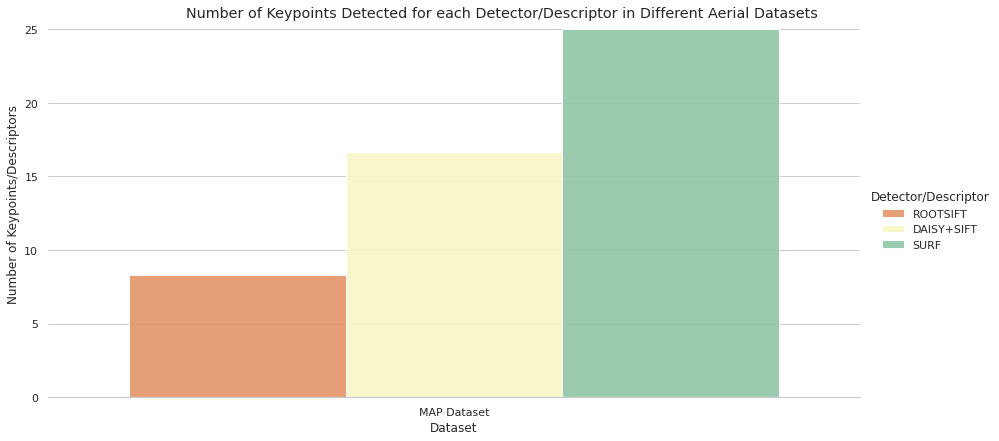

In [79]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_numkey_3, kind="bar",
    x="Dataset", y="Number of Keypoints", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=6, aspect=2
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Number of Keypoints/Descriptors")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Number of Keypoints Detected for each Detector/Descriptor in Different Aerial Datasets")

In [ ]:
g.savefig(f'drive/MyDrive/Num_Kypoints_6_{Dataset}.png')

In [80]:
df_numkey_3.to_csv(f'drive/MyDrive/Num_Kypoints_3_{Dataset}.csv')

In [ ]:
#print(len(num_matches_agast))

Total Number of Matches Detected for each Detector+Descriptor

In [81]:
#df_match_15['Number of Total Matches'] =  num_matches_agast + num_matches_akaze + num_matches_brisk + num_matches_daisy + num_matches_fast + num_matches_freak + num_matches_gftt + num_matches_kaze + num_matches_mser + num_matches_orb + num_matches_rootsift + num_matches_sift + num_matches_briefstar + num_matches_superpoint+ num_matches_surf+ num_matches_surfsift
d = {'Dataset': [f'{Dataset}']*(num_detectors*(len_files-1)), 'Number of Total Matches': num_matches_rootsift + num_matches_daisy + num_matches_surf, 'Detector/Descriptor': ['DAISY']*(len_files-1) + ['ROOTSIFT']*(len_files-1) + ['SURF']*(len_files-1)  }
df_match_3 = pd.DataFrame(data=d)
df_match_3['Number of Total Matches'] = df_match_3['Number of Total Matches']/(len_files-1)

Text(0.5, 0.98, 'Total Number of Matches Detected for each Detector/Descriptor in Different Aerial Datasets')

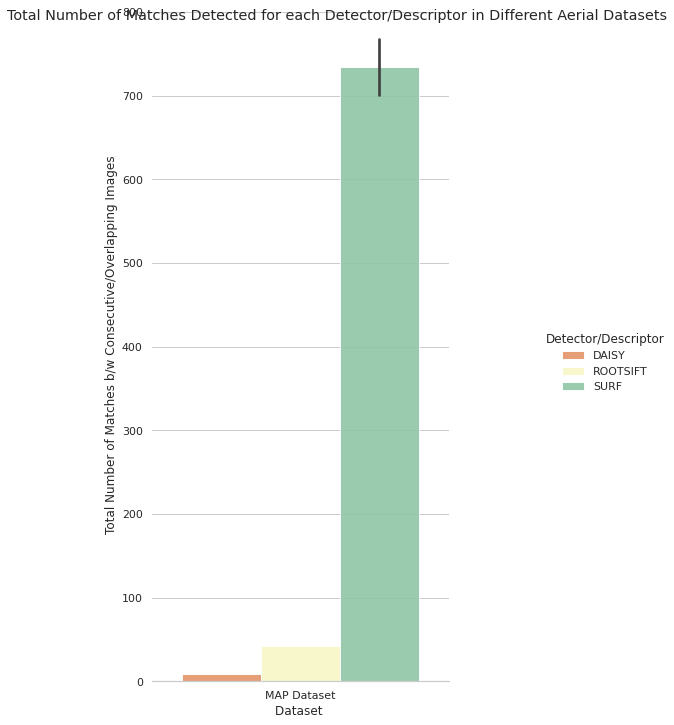

In [82]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_3, kind="bar",
    x="Dataset", y="Number of Total Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset ", "Total Number of Matches b/w Consecutive/Overlapping Images")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Total Number of Matches Detected for each Detector/Descriptor in Different Aerial Datasets")

In [ ]:
g.savefig(f'drive/MyDrive/Num_Matches_6_{Dataset}.png')

In [ ]:
#df_match_16.to_csv('drive/MyDrive/Num_Matches_16.csv')

Total Number of Good/Robust Matches (NN+Lowe+RANSAC) Detected for each Detector+Descriptor

In [83]:
df_match_3['Number of Good Matches'] = num_good_matches_rootsift + num_good_matches_daisy  + num_good_matches_surf
df_match_3['Number of Good Matches'] = df_match_3['Number of Good Matches']/(len_files-1)

Text(0.5, 0.98, 'Number of Good Matches (Lowe + RANSAC) Detected for each Detector/Descriptor in Different Aerial Datasets')

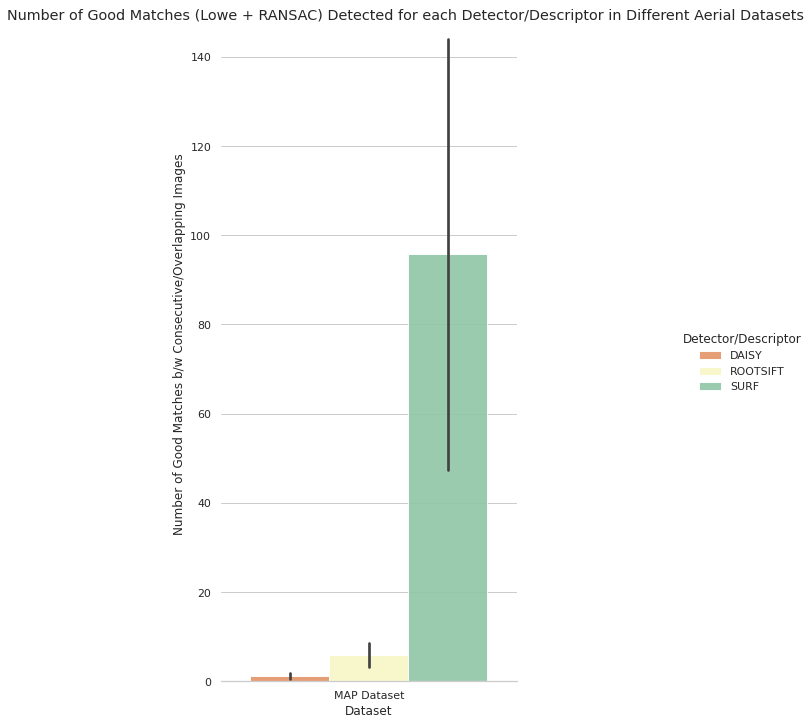

In [84]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_3, kind="bar",
    x="Dataset", y="Number of Good Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Number of Good Matches b/w Consecutive/Overlapping Images")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Number of Good Matches (Lowe + RANSAC) Detected for each Detector/Descriptor in Different Aerial Datasets")

In [ ]:
g.savefig('drive/MyDrive/Num_Good_Matches_6.png')

In [ ]:
#df_match_16.to_csv('drive/MyDrive/Num_Good_Matches_16.csv')

Recall Rate for each Detector+Descriptor

In [85]:
df_match_3['Recall Rate of Matches'] = df_match_3['Number of Good Matches']/df_match_3['Number of Total Matches']

Text(0.5, 0.98, 'Recall Rate of Matches Detected (Good/Total) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)')

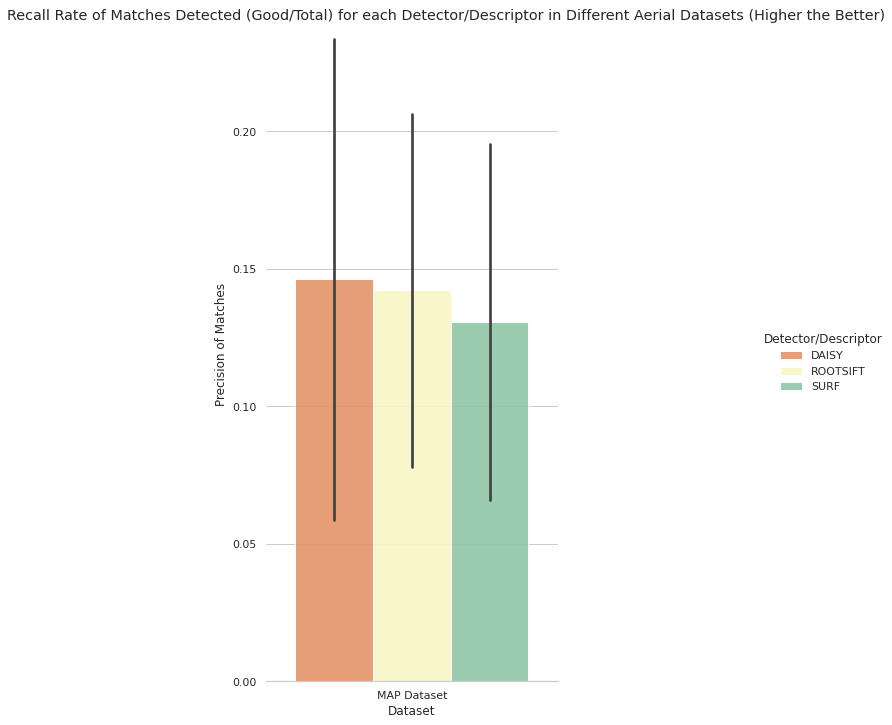

In [86]:
import seaborn as sns
sns.set_theme(style='whitegrid')


g = sns.catplot(
    data=df_match_3, kind="bar",
    x="Dataset", y="Recall Rate of Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Precision of Matches")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Recall Rate of Matches Detected (Good/Total) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)")

In [ ]:
g.savefig('drive/MyDrive/Recall_Rate_Matches_6.png')

1-Precision Rate for each Detector+Descriptor

In [87]:
df_match_3['1 - Precision Rate of Matches'] = (df_match_3['Number of Total Matches'] - df_match_3['Number of Good Matches'])/df_match_3['Number of Total Matches']

Text(0.5, 0.98, '1 - Precision rate of Matches Detected (False/Total Matches) for each Detector/Descriptor in Different Aerial Datasets (Lower the Better)')

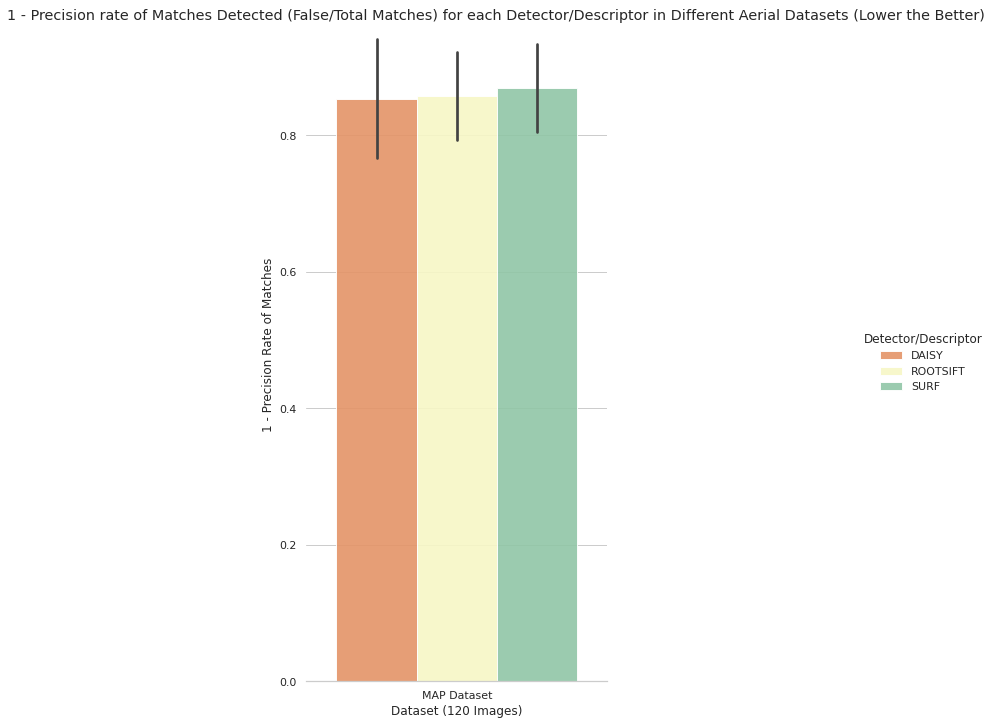

In [88]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_3, kind="bar",
    x="Dataset", y="1 - Precision Rate of Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset (120 Images)", "1 - Precision Rate of Matches")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("1 - Precision rate of Matches Detected (False/Total Matches) for each Detector/Descriptor in Different Aerial Datasets (Lower the Better)")

In [ ]:
g.savefig('drive/MyDrive/One_minus_Precision_Rate_Matches_6.png')

F-Score for each Detector+Descriptor

In [89]:
df_match_3['F-Score'] = (2* (1 - df_match_3['1 - Precision Rate of Matches']) * df_match_3['Recall Rate of Matches'])/((1 - df_match_3['1 - Precision Rate of Matches']) + df_match_3['Recall Rate of Matches'])

Text(0.5, 0.98, 'F-Score of Matches Detected (2*P*R/P+R) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)')

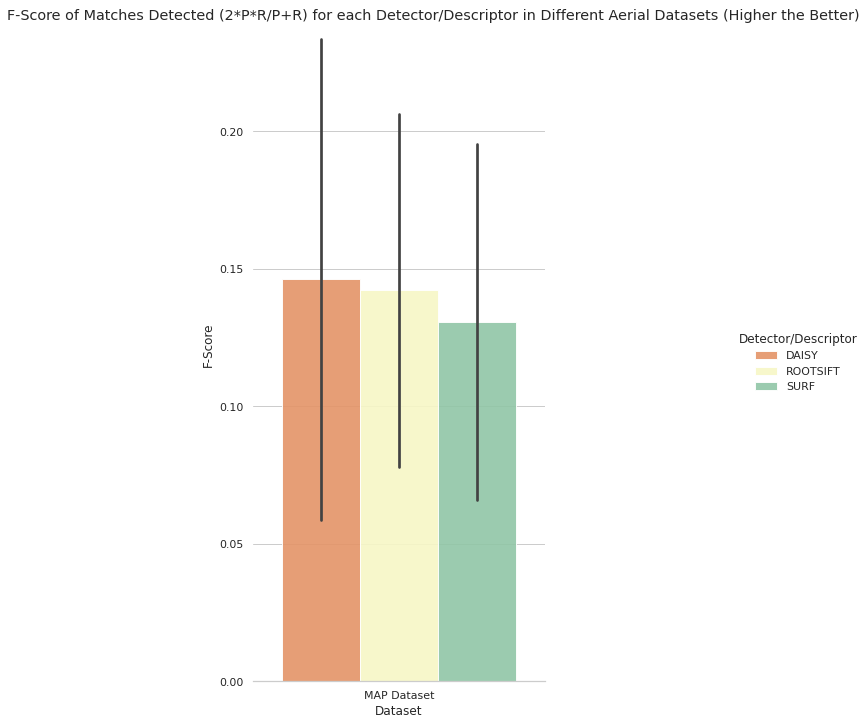

In [90]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_3, kind="bar",
    x="Dataset", y="F-Score", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "F-Score")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("F-Score of Matches Detected (2*P*R/P+R) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)")

In [ ]:
g.savefig('drive/MyDrive/F_Score_Rate_Matches_6.png')

In [91]:
df_match_3.to_csv('drive/MyDrive/All_metrics_3.csv')

Time for each Detector+Descriptor

In [92]:
d = {'Dataset': [f'{Dataset}']*(num_detectors), 'Time': [time_all[0]] +  [time_all[1]] + [time_all[2]], 'Detector/Descriptor': ['DAISY']*(1) + ['ROOTSIFT']*(1) + ['SURF']*(1) }
df_time_3 = pd.DataFrame(data=d)

In [93]:
print(df_time_3)

       Dataset        Time Detector/Descriptor
0  MAP Dataset  296.735687               DAISY
1  MAP Dataset  303.729496            ROOTSIFT
2  MAP Dataset  304.428185                SURF


Text(0.5, 0.98, 'Time taken during Feature Extraction by each Detector/Descriptor in Different Aerial Datasets (Lower the Better)')

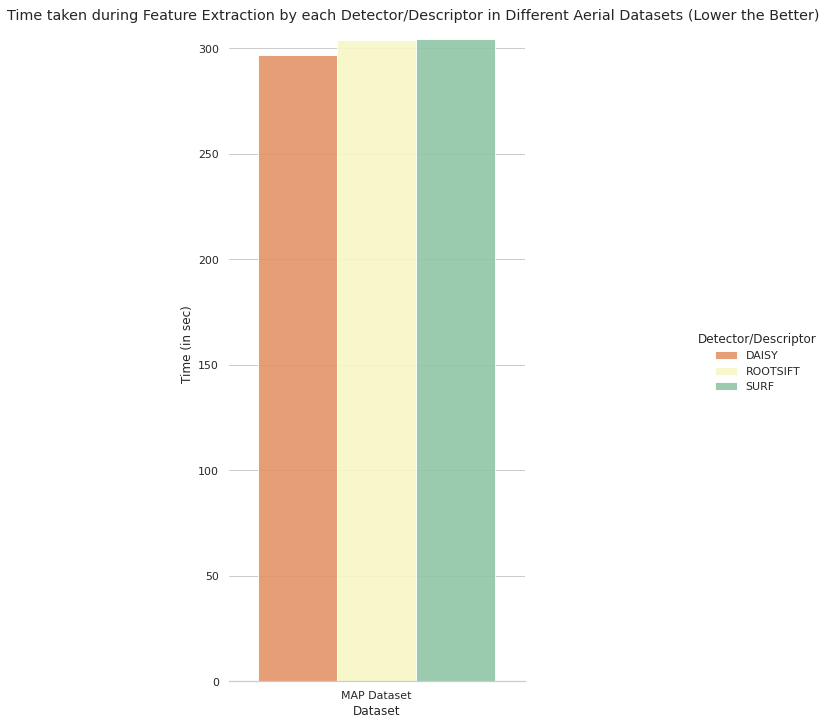

In [94]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_time_3, kind="bar",
    x="Dataset", y="Time", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Time (in sec)")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Time taken during Feature Extraction by each Detector/Descriptor in Different Aerial Datasets (Lower the Better)")

In [ ]:
g.savefig('drive/MyDrive/Time_6.png')

In [95]:
df_time_3.to_csv('drive/MyDrive/Time_3.csv')

Stitching with CPU